In [1]:
import numpy as np
import pandas as pd
import json
import scipy.stats
import time

from selfoptforest import *

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

In [2]:
ALGOS = ["rf", "lda", "pca"]
ALGO_NAMES = ["RF", "LDA RF", "PCA RF"]

In [3]:
df_benchmark = pd.read_csv("benchmark.csv")
df_benchmark

,openmlid,seed,size,train_time_rf,train_time_lda,train_time_pca,lc_rf_oob,lc_lda_oob,lc_pca_oob,lc_rf_test,lc_lda_test,lc_pca_test
0,3,12,1,0.4893,0.3173,1.2073,0.6287,0.6266,0.6095,0.9136,0.9237,0.8648
1,3,12,2,0.9709,0.4897,2.2059,0.7430,0.7438,0.7288,0.9036,0.9199,0.8861
2,3,12,3,1.4375,0.7608,3.6648,0.8102,0.8023,0.7889,0.9787,0.9512,0.9412
3,3,12,4,1.7601,0.9916,4.8049,0.8644,0.8527,0.8373,0.9725,0.9424,0.9412
4,3,12,5,2.1352,1.4220,6.3777,0.9011,0.8744,0.8602,0.9712,0.9549,0.9574
...,...,...,...,...,...,...,...,...,...,...,...,...
382195,42810,19,196,15720.1380,6027.5009,18431.4143,0.7453,0.6980,0.6333,0.7500,0.6950,0.6050
382196,42810,19,197,15795.7628,6056.6076,18529.1823,0.7460,0.6987,0.6337,0.7480,0.6950,0.6030
382197,42810,19,198,15873.0363,6086.4506,18625.2214,0.7463,0.6993,0.6347,0.7480,0.6960,0.6060
382198,42810,19,199,15953.9179,6117.9070,18716.1674,0.7460,0.6987,0.6340,0.7470,0.6940,0.6040


In [5]:
df_benchmark.query("openmlid == 60 and size == 100")

,openmlid,seed,size,train_time_rf,train_time_lda,train_time_pca,lc_rf_oob,lc_lda_oob,lc_pca_oob,lc_rf_test,lc_lda_test,lc_pca_test
40099,60,14,100,120.9197,61.0279,382.4704,0.8488,0.8629,0.8605,0.8400,0.8584,0.8560
40299,60,19,100,118.1104,60.1224,382.6457,0.8485,0.8621,0.8605,0.8384,0.8576,0.8520
40499,60,17,100,104.4722,52.2879,326.8966,0.8384,0.8605,0.8525,0.8488,0.8632,0.8592
40699,60,15,100,103.7865,50.3685,320.6876,0.8440,0.8539,0.8560,0.8584,0.8768,0.8688
40899,60,18,100,101.7331,51.9150,323.8291,0.8421,0.8557,0.8523,0.8544,0.8696,0.8664
41099,60,12,100,111.6248,52.7333,313.7294,0.8453,0.8624,0.8581,0.8488,0.8648,0.8624
41299,60,11,100,109.2082,60.1321,364.5447,0.8445,0.8595,0.8597,0.8536,0.8664,0.8592
41499,60,16,100,105.1657,58.5374,354.0603,0.8376,0.8637,0.8587,0.8512,0.8656,0.8560
41699,60,13,100,101.4261,50.2494,317.5177,0.8397,0.8549,0.8547,0.8608,0.8672,0.8664
41899,60,10,100,122.5886,56.6822,367.8852,0.8461,0.8648,0.8592,0.8352,0.8464,0.8512


In [4]:
bm = Benchmark(df_benchmark)


seeds = list(range(20))
datasets = sorted(pd.unique(df_benchmark["openmlid"]))

rows = []

MAX_TREES = 100

for i, openmlid in enumerate(tqdm(datasets)):
    for j, seed in enumerate(seeds):

        print(openmlid, " (seed " + str(seed) + ")\n-------------------------------")
        
        if np.count_nonzero((df_benchmark["openmlid"] == openmlid) & (df_benchmark["seed"] == seed)) == 0:
            print("Skipping, no data for this seed.")
            continue
        
        bm.reset(openmlid, seed)
        rf = SelfOptRF()
        rf.simulate_training_with_benchmark(bm, max_forest_size = MAX_TREES)
        
        try:
            choice = rf.choice
            print(f"CHOICE: {choice}")
            print("TRAIN TIME SELF OPT:", bm.get_current_train_time())
            print("TRAIN TIMES PURE RFS: ", [bm.get_train_time(name, MAX_TREES) for name in bm.algos])
            print("WORST CASE TIME: ", sum([bm.get_train_time(name, MAX_TREES) for name in bm.algos]))
            try:
                test_performance = np.round(np.mean([bm.get_test_performance_at_size(choice, MAX_TREES + i) for i in range(-2, 3)]), 4)
            except:
                print("error in retrieving performance, going to next dataset!")
                continue
            print(f"Test performance of choice: {test_performance}")

            best_performance_test = 0
            best_performance_oob = 0
            best_choice_test = None
            best_choice_oob = None
            rf_performance_test = 0
            rf_performance_oob = 0

            row = [openmlid, seed]
            for algo in bm.algos:
                performance_test = np.round(np.mean([bm.get_test_performance_at_size(algo, MAX_TREES + i) for i in range(-2,3)]), 4)
                performance_oob = np.round(np.mean([bm.get_oob_performance_at_size(algo, MAX_TREES + i) for i in range(-2,3)]), 4)
                row.append(performance_oob)
                row.append(performance_test)
                if algo == "rf":
                    rf_performance_test = performance_test
                    rf_performance_oob = performance_oob
                if performance_test > best_performance_test:
                    best_performance_test = performance_test
                    best_choice_test = algo
                if performance_oob > best_performance_oob:
                    best_performance_oob = performance_oob
                    best_choice_oob = algo

                print(algo + "\t" + str(performance_oob), performance_test, np.round(performance_test-  performance_oob, 3))

            gap = best_performance_test - test_performance
            improvement_over_rf = np.round(test_performance - rf_performance_test, 3)
            train_times = [bm.get_current_train_time(a) for a in bm.algos]
            trained_trees = [bm.indices[i] for i, a in enumerate(bm.algos)]
            max_train_times = [bm.get_train_time(a, MAX_TREES) for a in bm.algos]
            time_compression = np.round(sum(train_times) / sum(max_train_times), 2)
            
            print(f"Number of trained trees: {bm.indices}")
            print(f"Actual  Train Times: {train_times}")
            print(f"Maximum Train Times: {max_train_times}")
            print("Time compression:", np.round(time_compression, 2))
            
            # sanity check
            for k in range(3):
                if train_times[k] > max_train_times[k]:
                    raise Exception()

            rows.append(row + [choice, best_choice_oob, best_choice_test, gap, improvement_over_rf] + train_times + max_train_times + trained_trees)
            print("best choice found:", choice == best_choice_oob, choice == best_choice_test, f"Test gap to best: {np.round(gap, 4)}. Test improvement over RF: {improvement_over_rf}")
        except:
            
            print("!!!!!!!!1 DA IST WAS SCHIEFGEGANGEN!!!!!!!!!!")
            raise

  0%|          | 0/96 [00:00<?, ?it/s]

3  (seed 0)
-------------------------------
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9693799999999999 (at anchor 30. Projection: 0.985596305979746)
	lda: last value 0.9597 (at anchor 15. Projection: 0.9886376943197565)
	pca: last value 0.9718600000000001 (at anchor 46. Projection: 0.9757819019716583)
Repair phase finished. Summary: 
	rf: last value 0.96878 (at anchor 59. Projection: 0.9773046520013824)
	lda: last value 0.97454 (at anchor 59. Projection: 0.977405114717945)
	pca: last value 0.9718600000000001 (at anchor 46. Projection: 0.9757819019716583)
Learning curve is stale. Stopping!
stopped with curve size 72
CHOICE: lda
TRAIN TIME SELF OPT: 101.159
TRAIN TIMES PURE RFS:  [39.32270000000001, 24.3636, 112.84270000000004]
WORST CASE TIME:  176.52900000000005
Test performance of choice: 0.9733
rf	0.9742 0.9703 -0.004
lda	0.9752 0.9733 -0.002
pca	0.9737 0.9734 -0.0
Number 

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9725400000000001 (at anchor 36. Projection: 0.9849730145823434)
	lda: last value 0.96878 (at anchor 27. Projection: 0.9859401431565168)
	pca: last value 0.9589400000000001 (at anchor 15. Projection: 0.9762448768374363)
Repair phase finished. Summary: 
	rf: last value 0.9725400000000001 (at anchor 36. Projection: 0.9849730145823434)
	lda: last value 0.9730399999999999 (at anchor 36. Projection: 0.9858754916638865)
	pca: last value 0.9589400000000001 (at anchor 15. Projection: 0.9762448768374363)
Learning curve is stale. Stopping!
stopped with curve size 44
CHOICE: lda
TRAIN TIME SELF OPT: 46.95490000000001
TRAIN TIMES PURE RFS:  [40.2212, 24.47510000000001, 108.94119999999997]
WORST CASE TIME:  173.6375
Test performance of choice: 0.9753
rf	0.9725 0.9761 0.004
lda	0.9777 0.9753 -0.002
pca	0.9672 0.9676 0.0
Number of trained trees: [41

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.96912 (at anchor 28. Projection: 0.9810713215465467)
	lda: last value 0.9662000000000001 (at anchor 25. Projection: 0.9794646220463624)
	pca: last value 0.9498599999999999 (at anchor 21. Projection: 0.9570748476747287)
Learning curve is stale. Stopping!
stopped with curve size 39
CHOICE: rf
TRAIN TIME SELF OPT: 62.77610000000001
TRAIN TIMES PURE RFS:  [48.79020000000001, 28.278500000000005, 129.54940000000002]
WORST CASE TIME:  206.61810000000003
Test performance of choice: 0.9731
rf	0.98 0.9731 -0.007
lda	0.978 0.9756 -0.002
pca	0.9747 0.9663 -0.008
Number of trained trees: [39, 30, 26]
Actual  Train Times: [19.004300000000004, 8.6072, 35.1646]
Maximum Train Times: [48.79020000000001, 28.278500000000005, 129.54940000000002]
Time compression: 0.3
best choice found: True False Test gap to best: 0.0025. Test improvement over RF: 0.0


We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.90316 (at anchor 20. Projection: 0.9409071205857462)
	lda: last value 0.87096 (at anchor 13. Projection: 0.9457275888385783)
	pca: last value 0.8954400000000001 (at anchor 18. Projection: 0.9546982531241949)
Repair phase finished. Summary: 
	rf: last value 0.9098599999999999 (at anchor 24. Projection: 0.9408039811324479)
	lda: last value 0.87096 (at anchor 13. Projection: 0.9457275888385783)
	pca: last value 0.9106799999999999 (at anchor 24. Projection: 0.9547409883647159)
Learning curve is stale. Stopping!
stopped with curve size 89
CHOICE: pca
TRAIN TIME SELF OPT: 3781.6990000000014
TRAIN TIMES PURE RFS:  [309.8242, 431.3080000000003, 4084.1823000000013]
WORST CASE TIME:  4825.314500000001
Test performance of choice: 0.9495
rf	0.9458 0.9405 -0.005
lda	0.9588 0.947 -0.012
pca	0.9618 0.9495 -0.012
Number of trained trees: [29, 18, 89]
Actual  Train Times: [89.91290000000002, 77.31079999999999, 3614.47530

We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.89724 (at anchor 19. Projection: 0.9485725555746527)
	lda: last value 0.90292 (at anchor 22. Projection: 0.9524687081605173)
	pca: last value 0.9031 (at anchor 21. Projection: 0.9653336646139535)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: pca
TRAIN TIME SELF OPT: 4290.434900000001
TRAIN TIMES PURE RFS:  [334.08540000000005, 466.4132000000001, 4086.736800000001]
WORST CASE TIME:  4887.235400000001
Test performance of choice: 0.9501
rf	0.9502 0.9395 -0.011
lda	0.9593 0.9481 -0.011
pca	0.9568 0.9501 -0.007
Number of trained trees: [24, 27, 100]
Actual  Train Times: [77.0587, 126.6394, 4086.736800000001]
Maximum Train Times: [334.08540000000005, 466.4132000000001, 4086.736800000001]
Time compression: 0.88
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.011
6  (seed 10)
-------------------------------
We have a stable forecast. Stopping!
We ha

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8918600000000001 (at anchor 16. Projection: 0.9412350363587995)
	lda: last value 0.8992999999999999 (at anchor 20. Projection: 0.9593278782134858)
	pca: last value 0.92484 (at anchor 33. Projection: 0.9602221250074275)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: pca
TRAIN TIME SELF OPT: 4097.060499999998
TRAIN TIMES PURE RFS:  [302.82650000000007, 437.1240999999998, 3923.372499999998]
WORST CASE TIME:  4663.323099999998
Test performance of choice: 0.9491
rf	0.9493 0.9392 -0.01
lda	0.956 0.9489 -0.007
pca	0.957 0.9491 -0.008
Number of trained trees: [21, 25, 100]
Actual  Train Times: [62.668, 111.02, 3923.372499999998]
Maximum Train Times: [302.82650000000007, 437.1240999999998, 3923.372499999998]
Time compression: 0.88
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.01
6  (seed 18)
----------------------

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8483 (at anchor 43. Projection: 0.8817142717920451)
	lda: last value 0.8812 (at anchor 24. Projection: 0.9152416618707587)
	pca: last value 0.86966 (at anchor 27. Projection: 0.9147307454602406)
Learning curve is stale. Stopping!
stopped with curve size 29
CHOICE: lda
TRAIN TIME SELF OPT: 6.7585999999999995
TRAIN TIMES PURE RFS:  [3.2415999999999987, 5.4293999999999984, 10.819199999999995]
WORST CASE TIME:  19.490199999999994
Test performance of choice: 0.8978
rf	0.837 0.8393 0.002
lda	0.9032 0.8978 -0.005
pca	0.9108 0.8855 -0.025
Number of trained trees: [48, 29, 32]
Actual  Train Times: [1.5640999999999996, 1.5817999999999997, 3.6127000000000007]
Maximum Train Times: [3.2415999999999987, 5.4293999999999984, 10.819199999999995]
Time compression: 0.35
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.058
11

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.82264 (at anchor 19. Projection: 0.8412453045145593)
	lda: last value 0.9 (at anchor 33. Projection: 0.9258827022313729)
	pca: last value 0.89232 (at anchor 34. Projection: 0.9055903408434136)
Learning curve is stale. Stopping!
stopped with curve size 43
CHOICE: lda
TRAIN TIME SELF OPT: 6.4503
TRAIN TIMES PURE RFS:  [3.2661, 4.6474, 9.3597]
WORST CASE TIME:  17.2732
Test performance of choice: 0.9073
rf	0.8573 0.8675 0.01
lda	0.879 0.9073 0.028
pca	0.8815 0.9047 0.023
Number of trained trees: [24, 43, 39]
Actual  Train Times: [0.8417000000000001, 1.9751, 3.6335000000000006]
Maximum Train Times: [3.2661, 4.6474, 9.3597]
Time compression: 0.37
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.04
11  (seed 14)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. S

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9313400000000002 (at anchor 27. Projection: 0.9603900894038042)
	lda: last value 0.96186 (at anchor 20. Projection: 0.9744143308933684)
	pca: last value 0.9544 (at anchor 38. Projection: 0.970555402641554)
Learning curve is stale. Stopping!
stopped with curve size 47
CHOICE: lda
TRAIN TIME SELF OPT: 186.12240000000006
TRAIN TIMES PURE RFS:  [65.5517, 38.5132, 333.71700000000027]
WORST CASE TIME:  437.7819000000003
Test performance of choice: 0.9736
rf	0.9428 0.9587 0.016
lda	0.962 0.9736 0.012
pca	0.968 0.9701 0.002
Number of trained trees: [32, 47, 43]
Actual  Train Times: [21.093800000000005, 18.2848, 146.74380000000005]
Maximum Train Times: [65.5517, 38.5132, 333.71700000000027]
Time compression: 0.43
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.015
12  (seed 2)
-------------------------------

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.94628 (at anchor 31. Projection: 0.9776177010327733)
	lda: last value 0.9572 (at anchor 16. Projection: 0.9759534052967483)
	pca: last value 0.9401200000000001 (at anchor 20. Projection: 0.9716702576408194)
Repair phase finished. Summary: 
	rf: last value 0.9457599999999999 (at anchor 34. Projection: 0.9739396945927077)
	lda: last value 0.96706 (at anchor 34. Projection: 0.9745428516385473)
	pca: last value 0.9401200000000001 (at anchor 20. Projection: 0.9716702576408194)
Learning curve is stale. Stopping!
stopped with curve size 49
CHOICE: lda
TRAIN TIME SELF OPT: 136.9513
TRAIN TIMES PURE RFS:  [69.17049999999999, 41.0011, 364.1152]
WORST CASE TIME:  474.28679999999997
Test performance of choice: 0.9751
rf	0.9572 0.9591 0.002
lda	0.9716 0.9751 0.003
pca	0.9776 0.9681 -0.01
Number of trained trees: [39, 49, 25]
Actual  Train Times: [26.812500000000004, 20.0671, 90.07

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.93256 (at anchor 24. Projection: 0.9540837558277697)
	lda: last value 0.9548 (at anchor 30. Projection: 0.9646422044418047)
	pca: last value 0.93746 (at anchor 19. Projection: 0.9670839608170434)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.93256 (at anchor 24. Projection: 0.9540837558277697)
	lda: last value 0.9675800000000001 (at anchor 95. Projection: 0.9652978948102264)
	pca: last value 0.9641400000000001 (at anchor 95. Projection: 0.9660919858399492)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: lda
TRAIN TIME SELF OPT: 447.84929999999997
TRAIN TIMES PURE RFS:  [78.67470000000002, 39.944499999999984, 385.8565]
WORST CASE TIME:  504.47569999999996
Test performance of choice: 0.9679
rf	0.9592 0.9508 -0.008
lda	0.9776 0.9679 -0.01
pca	0.978 0.9648 -0.013
Number of trained trees: [29, 100, 100]
Actual  Train Tim

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.71682 (at anchor 11. Projection: 0.7229358140105799)
	lda: last value 0.7205600000000001 (at anchor 26. Projection: 0.6989991432587223)
	pca: last value 0.7018599999999999 (at anchor 14. Projection: 0.7099581488474391)
Repair phase finished. Summary: 
	rf: last value 0.7121600000000001 (at anchor 31. Projection: 0.718232331846159)
	lda: last value 0.70936 (at anchor 32. Projection: 0.6977601785766866)
	pca: last value 0.7018599999999999 (at anchor 14. Projection: 0.7099581488474391)
Learning curve is stale. Stopping!
stopped with curve size 36
CHOICE: rf
TRAIN TIME SELF OPT: 6.5921
TRAIN TIMES PURE RFS:  [4.960299999999998, 4.735400000000001, 15.645799999999996]
WORST CASE TIME:  25.341499999999996
Test performance of choice: 0.7028
rf	0.7639 0.7028 -0.061
lda	0.75 0.7075 -0.042
pca	0.7639 0.729 -0.035
Number of trained trees: [36, 37,

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.6925399999999999 (at anchor 10. Projection: 0.690247722716715)
	lda: last value 0.69718 (at anchor 12. Projection: 0.7021086539069847)
	pca: last value 0.7009399999999999 (at anchor 14. Projection: 0.6903286004771797)
Repair phase finished. Summary: 
	rf: last value 0.6925399999999999 (at anchor 10. Projection: 0.690247722716715)
	lda: last value 0.6841200000000001 (at anchor 16. Projection: 0.6762214512691527)
	pca: last value 0.7102999999999999 (at anchor 16. Projection: 0.6903507304732263)
Learning curve is stale. Stopping!
stopped with curve size 21
CHOICE: pca
TRAIN TIME SELF OPT: 4.1814
TRAIN TIMES PURE RFS:  [4.8386999999999984, 4.1616, 14.0474]
WORST CASE TIME:  23.0477
Test performance of choice: 0.743
rf	0.7361 0.7598 0.024
lda	0.7556 0.729 -0.027
pca	0.7139 0.743 0.029
Number of trained trees: [15, 21, 21]
Actual  Train Times:

Repair phase finished. Summary: 
	rf: last value 0.7140000000000001 (at anchor 20. Projection: 0.711784460271647)
	lda: last value 0.7588800000000001 (at anchor 21. Projection: 0.8585802730255184)
	pca: last value 0.69812 (at anchor 16. Projection: 0.6918840612915018)
Learning curve is stale. Stopping!
stopped with curve size 30
CHOICE: lda
TRAIN TIME SELF OPT: 5.910200000000001
TRAIN TIMES PURE RFS:  [5.883200000000002, 4.4217, 14.463400000000002]
WORST CASE TIME:  24.768300000000004
Test performance of choice: 0.7439
rf	0.625 0.7421 0.117
lda	0.6417 0.7439 0.102
pca	0.6278 0.7355 0.108
Number of trained trees: [25, 30, 21]
Actual  Train Times: [1.4569000000000003, 1.5155999999999996, 2.9377000000000004]
Maximum Train Times: [5.883200000000002, 4.4217, 14.463400000000002]
Time compression: 0.24
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.002
23  (seed 0)
-------------------------------
Learning curve is stale. Stopping!
Learning curve is stale. Stop

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.5098 (at anchor 41. Projection: 0.51225016794267)
	lda: last value 0.523 (at anchor 48. Projection: 0.5989503582408956)
	pca: last value 0.49639999999999995 (at anchor 15. Projection: 0.49862026823007916)
Learning curve is stale. Stopping!
stopped with curve size 53
CHOICE: lda
TRAIN TIME SELF OPT: 54.82340000000001
TRAIN TIMES PURE RFS:  [24.164799999999996, 36.96139999999999, 125.06489999999997]
WORST CASE TIME:  186.19109999999995
Test performance of choice: 0.5179
rf	0.5301 0.531 0.001
lda	0.5122 0.5179 0.006
pca	0.5528 0.5261 -0.027
Number of trained trees: [46, 53, 20]
Actual  Train Times: [9.9782, 19.0735, 25.77170000000001]
Maximum Train Times: [24.164799999999996, 36.96139999999999, 125.06489999999997]
Time compression: 0.29
best choice found: False False Test gap to best: 0.0131. Test improvement over RF: -0.013
23  (seed 8)
--

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.53458 (at anchor 47. Projection: 0.7104407568655527)
	lda: last value 0.53548 (at anchor 43. Projection: 0.6114106503833682)
	pca: last value 0.5268200000000001 (at anchor 28. Projection: 0.5338127779325396)
Repair phase finished. Summary: 
	rf: last value 0.5326 (at anchor 49. Projection: 0.6031592648841477)
	lda: last value 0.54098 (at anchor 49. Projection: 0.6034156052602977)
	pca: last value 0.5268200000000001 (at anchor 28. Projection: 0.5338127779325396)
Learning curve is stale. Stopping!
stopped with curve size 58
CHOICE: lda
TRAIN TIME SELF OPT: 64.20439999999999
TRAIN TIMES PURE RFS:  [21.8243, 30.71950000000001, 109.29980000000002]
WORST CASE TIME:  161.84360000000004
Test performance of choice: 0.5442
rf	0.5154 0.5418 0.026
lda	0.5046 0.5442 0.04
pca	0.5214 0.5417 0.02
Number of trained trees: [54, 58, 33]
Actual  Train Times

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.91278 (at anchor 10. Projection: 0.916447041799315)
	lda: last value 0.91776 (at anchor 12. Projection: 0.9023040572137547)
	pca: last value 0.92994 (at anchor 20. Projection: 0.9390478310356225)
Learning curve is stale. Stopping!
stopped with curve size 25
CHOICE: pca
TRAIN TIME SELF OPT: 10.597000000000001
TRAIN TIMES PURE RFS:  [5.2513, 6.815, 28.341000000000022]
WORST CASE TIME:  40.40730000000002
Test performance of choice: 0.9255
rf	0.9068 0.9112 0.004
lda	0.9108 0.9121 0.001
pca	0.9251 0.9255 0.0
Number of trained trees: [15, 17, 25]
Actual  Train Times: [0.7027, 1.2614000000000003, 8.632900000000001]
Maximum Train Times: [5.2513, 6.815, 28.341000000000022]
Time compression: 0.26
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.014
30  (seed 3)
-------------------------------
Learning curve is stale.

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.92344 (at anchor 18. Projection: 0.9403958463691876)
	lda: last value 0.90412 (at anchor 8. Projection: 0.9034396031926878)
	pca: last value 0.91034 (at anchor 15. Projection: 0.9104202603820456)
Learning curve is stale. Stopping!
stopped with curve size 23
CHOICE: rf
TRAIN TIME SELF OPT: 6.6061
TRAIN TIMES PURE RFS:  [5.479800000000004, 6.620999999999999, 23.80720000000001]
WORST CASE TIME:  35.908000000000015
Test performance of choice: 0.904
rf	0.8994 0.904 0.005
lda	0.8926 0.9029 0.01
pca	0.8926 0.9018 0.009
Number of trained trees: [23, 13, 20]
Actual  Train Times: [1.2718, 0.8201999999999999, 4.5141]
Maximum Train Times: [5.479800000000004, 6.620999999999999, 23.80720000000001]
Time compression: 0.18
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
30  (seed 12)
-------------------------------
Lea

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9226599999999999 (at anchor 14. Projection: 0.922066223663836)
	lda: last value 0.9205599999999998 (at anchor 17. Projection: 0.9210123835716271)
	pca: last value 0.9145999999999999 (at anchor 19. Projection: 0.9165653592521772)
Learning curve is stale. Stopping!
stopped with curve size 19
CHOICE: rf
TRAIN TIME SELF OPT: 10.141
TRAIN TIMES PURE RFS:  [5.816600000000004, 6.576799999999998, 26.5159]
WORST CASE TIME:  38.9093
Test performance of choice: 0.9031
rf	0.8904 0.9031 0.013
lda	0.8904 0.9005 0.01
pca	0.8904 0.9006 0.01
Number of trained trees: [19, 22, 24]
Actual  Train Times: [1.5701, 1.8228, 6.7481]
Maximum Train Times: [5.816600000000004, 6.576799999999998, 26.5159]
Time compression: 0.26
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
31  (seed 0)
-------------------------------
Learning curve 

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7090799999999999 (at anchor 23. Projection: 0.7158499347060049)
	lda: last value 0.71546 (at anchor 59. Projection: 0.7640303721185239)
	pca: last value 0.71014 (at anchor 33. Projection: 0.8052349101059746)
Repair phase finished. Summary: 
	rf: last value 0.7090799999999999 (at anchor 23. Projection: 0.7158499347060049)
	lda: last value 0.71546 (at anchor 59. Projection: 0.7640303721185239)
	pca: last value 0.7053200000000001 (at anchor 59. Projection: 0.7170714270159211)
Learning curve is stale. Stopping!
stopped with curve size 64
CHOICE: lda
TRAIN TIME SELF OPT: 65.7483
TRAIN TIMES PURE RFS:  [28.042500000000004, 14.8651, 75.28840000000002]
WORST CASE TIME:  118.19600000000003
Test performance of choice: 0.7368
rf	0.7952 0.7384 -0.057
lda	0.7808 0.7368 -0.044
pca	0.776 0.7243 -0.052
Number of trained trees: [28, 64, 64]
Actual  Train Times: [7.8965999999999985, 9.6637

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7370599999999999 (at anchor 45. Projection: 0.7756466039901124)
	lda: last value 0.71918 (at anchor 23. Projection: 0.7230954804871792)
	pca: last value 0.732 (at anchor 25. Projection: 0.7477479292444938)
Learning curve is stale. Stopping!
stopped with curve size 50
CHOICE: rf
TRAIN TIME SELF OPT: 32.544799999999995
TRAIN TIMES PURE RFS:  [22.92170000000001, 12.343600000000004, 58.894499999999994]
WORST CASE TIME:  94.1598
Test performance of choice: 0.7413
rf	0.7584 0.7413 -0.017
lda	0.744 0.72 -0.024
pca	0.7568 0.7485 -0.008
Number of trained trees: [50, 28, 30]
Actual  Train Times: [11.524200000000002, 3.5512000000000006, 17.469399999999997]
Maximum Train Times: [22.92170000000001, 12.343600000000004, 58.894499999999994]
Time compression: 0.35
best choice found: True False Test gap to best: 0.0072. Test improvement over RF: 0.0
3

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.72744 (at anchor 23. Projection: 0.7525377689660243)
	lda: last value 0.7861 (at anchor 57. Projection: 0.8136399613535448)
	pca: last value 0.7583599999999999 (at anchor 23. Projection: 0.7800635494100968)
Learning curve is stale. Stopping!
stopped with curve size 72
CHOICE: lda
TRAIN TIME SELF OPT: 27.347
TRAIN TIMES PURE RFS:  [13.633100000000008, 14.4232, 48.1911]
WORST CASE TIME:  76.2474
Test performance of choice: 0.7811
rf	0.7339 0.7439 0.01
lda	0.8038 0.7811 -0.023
pca	0.7849 0.7773 -0.008
Number of trained trees: [28, 72, 28]
Actual  Train Times: [3.4148000000000014, 10.3047, 13.6275]
Maximum Train Times: [13.633100000000008, 14.4232, 48.1911]
Time compression: 0.36
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.037
54  (seed 4)
-------------------------------
Learning curve is stale. Stoppi

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7552199999999999 (at anchor 32. Projection: 0.7661332076164247)
	lda: last value 0.77066 (at anchor 31. Projection: 0.8272641564640669)
	pca: last value 0.7785599999999999 (at anchor 37. Projection: 0.7936052541206559)
Repair phase finished. Summary: 
	rf: last value 0.7552199999999999 (at anchor 32. Projection: 0.7661332076164247)
	lda: last value 0.7665599999999999 (at anchor 50. Projection: 0.7927987744008467)
	pca: last value 0.7795 (at anchor 50. Projection: 0.7934980980865943)
Learning curve is stale. Stopping!
stopped with curve size 55
CHOICE: pca
TRAIN TIME SELF OPT: 40.71180000000001
TRAIN TIMES PURE RFS:  [14.314200000000005, 14.187699999999996, 50.819400000000016]
WORST CASE TIME:  79.32130000000001
Test performance of choice: 0.7877
rf	0.7462 0.7653 0.019
lda	0.7849 0.7836 -0.001
pca	0.7849 0.7877 0.003
Number of trained

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.74574 (at anchor 30. Projection: 0.767832140455446)
	lda: last value 0.77286 (at anchor 31. Projection: 0.8005081608183902)
	pca: last value 0.7517400000000001 (at anchor 25. Projection: 0.7716263876540255)
Learning curve is stale. Stopping!
stopped with curve size 36
CHOICE: lda
TRAIN TIME SELF OPT: 24.68
TRAIN TIMES PURE RFS:  [14.0086, 13.622399999999995, 47.9402]
WORST CASE TIME:  75.57119999999999
Test performance of choice: 0.7808
rf	0.7151 0.7517 0.037
lda	0.7613 0.7808 0.02
pca	0.7708 0.7855 0.015
Number of trained trees: [35, 36, 30]
Actual  Train Times: [5.1113, 4.784100000000001, 14.7846]
Maximum Train Times: [14.0086, 13.622399999999995, 47.9402]
Time compression: 0.33
best choice found: False False Test gap to best: 0.0047. Test improvement over RF: 0.029
55  (seed 0)
-------------------------------
Learning curve is stale

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.84824 (at anchor 35. Projection: 0.8798903440601055)
	lda: last value 0.88102 (at anchor 44. Projection: 0.8966722818819663)
	pca: last value 0.83104 (at anchor 20. Projection: 0.8339997174097835)
Learning curve is stale. Stopping!
stopped with curve size 49
CHOICE: lda
TRAIN TIME SELF OPT: 1.2968000000000002
TRAIN TIMES PURE RFS:  [0.8288999999999996, 0.7412999999999997, 2.2674]
WORST CASE TIME:  3.8375999999999992
Test performance of choice: 0.8845
rf	0.7692 0.8362 0.067
lda	0.7692 0.8845 0.115
pca	0.7949 0.8793 0.084
Number of trained trees: [40, 49, 25]
Actual  Train Times: [0.3464999999999999, 0.3889, 0.5614000000000001]
Maximum Train Times: [0.8288999999999996, 0.7412999999999997, 2.2674]
Time compression: 0.34
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.048
55  (seed 8)
----------------------

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.85 (at anchor 33. Projection: 0.8518337405414448)
	lda: last value 0.8448 (at anchor 25. Projection: 0.856507687966774)
	pca: last value 0.8551400000000001 (at anchor 21. Projection: 0.8778934833019532)
Learning curve is stale. Stopping!
stopped with curve size 26
CHOICE: pca
TRAIN TIME SELF OPT: 1.4331
TRAIN TIMES PURE RFS:  [1.1096, 0.9800999999999996, 2.9402000000000017]
WORST CASE TIME:  5.029900000000001
Test performance of choice: 0.8621
rf	0.8205 0.8638 0.043
lda	0.8205 0.831 0.01
pca	0.8205 0.8621 0.042
Number of trained trees: [38, 30, 26]
Actual  Train Times: [0.4006999999999999, 0.2831, 0.7493000000000002]
Maximum Train Times: [1.1096, 0.9800999999999996, 2.9402000000000017]
Time compression: 0.28
best choice found: False False Test gap to best: 0.0017. Test improvement over RF: -0.002
55  (seed 16)
-------------------------

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8309999999999998 (at anchor 35. Projection: 0.8448961933342333)
	lda: last value 0.84124 (at anchor 25. Projection: 0.8584565842471364)
	pca: last value 0.8342 (at anchor 28. Projection: 0.8536366279012007)
Learning curve is stale. Stopping!
stopped with curve size 48
CHOICE: lda
TRAIN TIME SELF OPT: 164.781
TRAIN TIMES PURE RFS:  [100.01479999999997, 49.1288, 312.2143]
WORST CASE TIME:  461.3579
Test performance of choice: 0.8615
rf	0.8394 0.8461 0.007
lda	0.8546 0.8615 0.007
pca	0.8522 0.8564 0.004
Number of trained trees: [40, 48, 33]
Actual  Train Times: [39.83659999999999, 23.503500000000006, 101.4409]
Maximum Train Times: [100.01479999999997, 49.1288, 312.2143]
Time compression: 0.36
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.015
60  (seed 4)
-------------------------------
We have a stabl

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8281600000000001 (at anchor 31. Projection: 0.8425122849689077)
	lda: last value 0.8489000000000001 (at anchor 35. Projection: 0.8681295237294404)
	pca: last value 0.8426 (at anchor 38. Projection: 0.8779493483218198)
Repair phase finished. Summary: 
	rf: last value 0.8281600000000001 (at anchor 31. Projection: 0.8425122849689077)
	lda: last value 0.8579399999999999 (at anchor 64. Projection: 0.866433296102286)
	pca: last value 0.8470599999999999 (at anchor 64. Projection: 0.8662925894452627)
Learning curve is stale. Stopping!
stopped with curve size 77
CHOICE: lda
TRAIN TIME SELF OPT: 334.75030000000004
TRAIN TIMES PURE RFS:  [109.2082, 60.1321, 364.5447]
WORST CASE TIME:  533.885
Test performance of choice: 0.8593
rf	0.8539 0.8451 -0.009
lda	0.8651 0.8593 -0.006
pca	0.8589 0.8581 -0.001
Number of trained trees: [36, 77, 69]
Actual  Train Times: [38.7906, 46.7368, 249.

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8265800000000001 (at anchor 27. Projection: 0.8472681689385577)
	lda: last value 0.84154 (at anchor 34. Projection: 0.8533374304298111)
	pca: last value 0.8472999999999999 (at anchor 43. Projection: 0.8643115583370972)
Learning curve is stale. Stopping!
stopped with curve size 80
CHOICE: pca
TRAIN TIME SELF OPT: 364.897
TRAIN TIMES PURE RFS:  [118.11039999999998, 60.12239999999999, 382.64569999999986]
WORST CASE TIME:  560.8784999999998
Test performance of choice: 0.8599
rf	0.8378 0.8476 0.01
lda	0.8566 0.8609 0.004
pca	0.8526 0.8599 0.007
Number of trained trees: [32, 39, 80]
Actual  Train Times: [36.78740000000001, 23.667999999999992, 304.4416]
Maximum Train Times: [118.11039999999998, 60.12239999999999, 382.64569999999986]
Time compression: 0.65
best choice found: False False Test gap to best: 0.001. Test improvement over RF: 0.

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.59372 (at anchor 41. Projection: 0.6080320196916087)
	lda: last value 0.60722 (at anchor 37. Projection: 0.6409005511341561)
	pca: last value 0.59102 (at anchor 34. Projection: 0.6020453982447649)
Learning curve is stale. Stopping!
stopped with curve size 42
CHOICE: lda
TRAIN TIME SELF OPT: 65.8012
TRAIN TIMES PURE RFS:  [18.41270000000001, 37.13600000000002, 105.87290000000004]
WORST CASE TIME:  161.42160000000007
Test performance of choice: 0.6233
rf	0.6383 0.6117 -0.027
lda	0.6258 0.6233 -0.003
pca	0.6162 0.6176 0.001
Number of trained trees: [46, 42, 39]
Actual  Train Times: [8.430399999999999, 15.368000000000002, 42.0028]
Maximum Train Times: [18.41270000000001, 37.13600000000002, 105.87290000000004]
Time compression: 0.41
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.012
181  (seed 8)
----------

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.60002 (at anchor 53. Projection: 0.6232596350609024)
	lda: last value 0.5912 (at anchor 46. Projection: 0.6378245316128074)
	pca: last value 0.5726600000000001 (at anchor 24. Projection: 0.5950170189991241)
Repair phase finished. Summary: 
	rf: last value 0.60002 (at anchor 53. Projection: 0.6232596350609024)
	lda: last value 0.60074 (at anchor 53. Projection: 0.6406630964624875)
	pca: last value 0.5726600000000001 (at anchor 24. Projection: 0.5950170189991241)
Learning curve is stale. Stopping!
stopped with curve size 66
CHOICE: lda
TRAIN TIME SELF OPT: 58.6055
TRAIN TIMES PURE RFS:  [17.586799999999997, 32.033100000000005, 94.9023]
WORST CASE TIME:  144.5222
Test performance of choice: 0.6016
rf	0.6011 0.6108 0.01
lda	0.6253 0.6016 -0.024
pca	0.6157 0.6056 -0.01
Number of trained trees: [58, 66, 29]
Actual  Train Times: [10.0845999

We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.83606 (at anchor 18. Projection: 0.8427448626152988)
	lda: last value 0.8326399999999999 (at anchor 18. Projection: 0.8440869540460492)
	pca: last value 0.8309200000000001 (at anchor 24. Projection: 0.8369737657184143)
Repair phase finished. Summary: 
	rf: last value 0.8386800000000001 (at anchor 26. Projection: 0.8427761322498313)
	lda: last value 0.83538 (at anchor 26. Projection: 0.8427480950930063)
	pca: last value 0.8309200000000001 (at anchor 24. Projection: 0.8369737657184143)
Learning curve is stale. Stopping!
stopped with curve size 36
CHOICE: rf
TRAIN TIME SELF OPT: 671.0010000000001
TRAIN TIMES PURE RFS:  [236.57279999999997, 241.7713, 1749.706200000001]
WORST CASE TIME:  2228.050300000001
Test performance of choice: 0.8381
rf	0.8464 0.8381 -0.008
lda	0.8439 0.8376 -0.006
pca	0.8393 0.8319 -0.007
Number of trained trees: [36, 31, 29]
Actual  Train Times: [85.94260000000004, 75.9821, 509.076300

We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.83532 (at anchor 16. Projection: 0.83868580337378)
	lda: last value 0.8313 (at anchor 11. Projection: 0.8424552671542949)
	pca: last value 0.8297599999999999 (at anchor 22. Projection: 0.8731716008839717)
Repair phase finished. Summary: 
	rf: last value 0.8433200000000001 (at anchor 55. Projection: 0.8420729994548535)
	lda: last value 0.83948 (at anchor 54. Projection: 0.8408242563656201)
	pca: last value 0.8317 (at anchor 54. Projection: 0.8420171238844976)
Learning curve is stale. Stopping!
stopped with curve size 66
CHOICE: rf
TRAIN TIME SELF OPT: 1132.6281000000001
TRAIN TIMES PURE RFS:  [208.72980000000007, 214.41690000000003, 1491.3844000000006]
WORST CASE TIME:  1914.5311000000006
Test performance of choice: 0.842
rf	0.8428 0.842 -0.001
lda	0.8392 0.8397 0.001
pca	0.8323 0.8324 0.0
Number of trained trees: [66, 59, 59]
Actual  Train Times: [139.2348, 126.5351, 866.8582000000001]
Maximum Train Time

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.84346 (at anchor 46. Projection: 0.8584142223712679)
	lda: last value 0.83776 (at anchor 19. Projection: 0.8548163698541196)
	pca: last value 0.8324999999999999 (at anchor 33. Projection: 0.8458520904084551)
Learning curve is stale. Stopping!
stopped with curve size 51
CHOICE: rf
TRAIN TIME SELF OPT: 839.1485
TRAIN TIMES PURE RFS:  [249.87129999999996, 244.9455999999999, 1722.4836999999993]
WORST CASE TIME:  2217.300599999999
Test performance of choice: 0.8412
rf	0.8423 0.8412 -0.001
lda	0.8382 0.8394 0.001
pca	0.8335 0.8332 -0.0
Number of trained trees: [51, 24, 38]
Actual  Train Times: [131.91550000000004, 58.8914, 648.3416]
Maximum Train Times: [249.87129999999996, 244.9455999999999, 1722.4836999999993]
Time compression: 0.38
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
201  (seed 19)
-----------

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.67928 (at anchor 42. Projection: 1.177620408392063)
	lda: last value 0.7815000000000001 (at anchor 33. Projection: 0.8175450723254573)
	pca: last value 0.81554 (at anchor 40. Projection: 0.9345603226323467)
Repair phase finished. Summary: 
	rf: last value 0.7236800000000001 (at anchor 91. Projection: 0.8857099581549123)
	lda: last value 0.7815000000000001 (at anchor 33. Projection: 0.8175450723254573)
	pca: last value 0.8473599999999999 (at anchor 91. Projection: 0.888038151308636)
Learning curve is stale. Stopping!
stopped with curve size 96
CHOICE: pca
TRAIN TIME SELF OPT: 63.143900000000016
TRAIN TIMES PURE RFS:  [12.1882, 9.074299999999996, 50.05900000000001]
WORST CASE TIME:  71.32150000000001
Test performance of choice: 0.8563
rf	0.72 0.7333 0.013
lda	0.8778 0.8281 -0.05
pca	0.8466 0.8563 0.01
Number of trained trees: [96, 38, 96

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7185 (at anchor 64. Projection: 0.7550281145552645)
	lda: last value 0.80296 (at anchor 60. Projection: 0.922380491508448)
	pca: last value 0.82516 (at anchor 50. Projection: 0.839629614575915)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.7185 (at anchor 64. Projection: 0.7550281145552645)
	lda: last value 0.82072 (at anchor 95. Projection: 0.8970313483835477)
	pca: last value 0.83552 (at anchor 95. Projection: 0.83599462204677)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: pca
TRAIN TIME SELF OPT: 67.60700000000003
TRAIN TIMES PURE RFS:  [12.0235, 9.2983, 50.07270000000002]
WORST CASE TIME:  71.39450000000002
Test performance of choice: 0.837
rf	0.7111 0.734 0.023
lda	0.8734 0.8222 -0.051
pca	0.8556 0.837 -0.019
Number of trained trees: [69, 100, 100]
Actual  Train Times: [8.23

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.817 (at anchor 14. Projection: 0.8268921826303979)
	lda: last value 0.828 (at anchor 28. Projection: 0.8503799956058752)
	pca: last value 0.82 (at anchor 35. Projection: 0.8579872640696146)
Repair phase finished. Summary: 
	rf: last value 0.817 (at anchor 14. Projection: 0.8268921826303979)
	lda: last value 0.817 (at anchor 39. Projection: 0.8382344836267291)
	pca: last value 0.818 (at anchor 38. Projection: 0.8562094422933048)
Learning curve is stale. Stopping!
stopped with curve size 43
CHOICE: pca
TRAIN TIME SELF OPT: 4.551
TRAIN TIMES PURE RFS:  [2.080000000000001, 2.0986000000000007, 7.5508000000000015]
WORST CASE TIME:  11.729400000000002
Test performance of choice: 0.815
rf	0.8358 0.838 0.002
lda	0.8209 0.828 0.007
pca	0.8358 0.815 -0.021
Number of trained trees: [19, 44, 43]
Actual  Train Times: [0.4208, 0.8882000000000001, 3.242]
Maximum Train Times: [2.0800000

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.796 (at anchor 20. Projection: 0.823722481546192)
	lda: last value 0.775 (at anchor 18. Projection: 0.7897613637896308)
	pca: last value 0.7969999999999999 (at anchor 51. Projection: 0.8230413593448574)
Repair phase finished. Summary: 
	rf: last value 0.791 (at anchor 51. Projection: 0.8025593329040409)
	lda: last value 0.775 (at anchor 18. Projection: 0.7897613637896308)
	pca: last value 0.7969999999999999 (at anchor 51. Projection: 0.8230413593448574)
Learning curve is stale. Stopping!
stopped with curve size 56
CHOICE: pca
TRAIN TIME SELF OPT: 5.8020000000000005
TRAIN TIMES PURE RFS:  [2.4005, 2.1659, 6.757200000000003]
WORST CASE TIME:  11.323600000000003
Test performance of choice: 0.807
rf	0.8657 0.803 -0.063
lda	0.8717 0.794 -0.078
pca	0.8657 0.807 -0.059
Number of trained trees: [56, 23, 56]
Actual  Train Times: [1.4583, 0.544599

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8009999999999999 (at anchor 31. Projection: 0.802118941116485)
	lda: last value 0.792 (at anchor 21. Projection: 0.7976544237204761)
	pca: last value 0.8149999999999998 (at anchor 20. Projection: 0.8244481271195723)
Learning curve is stale. Stopping!
stopped with curve size 26
CHOICE: pca
TRAIN TIME SELF OPT: 3.1484000000000005
TRAIN TIMES PURE RFS:  [2.133300000000001, 2.0478, 6.4681000000000015]
WORST CASE TIME:  10.649200000000002
Test performance of choice: 0.815
rf	0.8657 0.813 -0.053
lda	0.8657 0.8 -0.066
pca	0.8687 0.815 -0.054
Number of trained trees: [36, 26, 26]
Actual  Train Times: [0.7785, 0.5898000000000001, 1.7801000000000002]
Maximum Train Times: [2.133300000000001, 2.0478, 6.4681000000000015]
Time compression: 0.3
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.002
336  (seed 19)
------

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.5026999999999999 (at anchor 10. Projection: 0.5307943592055047)
	lda: last value 0.42702 (at anchor 10. Projection: 0.41728280097486853)
	pca: last value 0.4162 (at anchor 10. Projection: 0.3448867375008427)
Learning curve is stale. Stopping!
stopped with curve size 15
CHOICE: rf
TRAIN TIME SELF OPT: 0.5854999999999999
TRAIN TIMES PURE RFS:  [0.5202000000000001, 0.9210000000000004, 1.7472000000000008]
WORST CASE TIME:  3.1884000000000015
Test performance of choice: 0.3622
rf	0.4615 0.3622 -0.099
lda	0.3846 0.4054 0.021
pca	0.3077 0.4 0.092
Number of trained trees: [15, 15, 15]
Actual  Train Times: [0.0766, 0.2517, 0.2572]
Maximum Train Times: [0.5202000000000001, 0.9210000000000004, 1.7472000000000008]
Time compression: 0.18
best choice found: True False Test gap to best: 0.0432. Test improvement over RF: 0.0
346  (seed 8)
-------------------------------
Learning curve is

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.4324199999999999 (at anchor 16. Projection: 0.4459628882106781)
	lda: last value 0.37839999999999996 (at anchor 14. Projection: 0.3857713388969466)
	pca: last value 0.41624 (at anchor 11. Projection: 0.38721584539445064)
Learning curve is stale. Stopping!
stopped with curve size 21
CHOICE: rf
TRAIN TIME SELF OPT: 0.5669000000000001
TRAIN TIMES PURE RFS:  [0.6055000000000003, 0.8203, 1.7244999999999997]
WORST CASE TIME:  3.1502999999999997
Test performance of choice: 0.4919
rf	0.4615 0.4919 0.03
lda	0.3846 0.2973 -0.087
pca	0.3846 0.4487 0.064
Number of trained trees: [21, 19, 16]
Actual  Train Times: [0.14340000000000006, 0.1512, 0.2723]
Maximum Train Times: [0.6055000000000003, 0.8203, 1.7244999999999997]
Time compression: 0.18
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
346  (seed 16)
-------------

Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.6667 (at anchor 95. Projection: 0.6667000004973815)
	lda: last value 0.6667 (at anchor 95. Projection: 0.6695009449942473)
	pca: last value 0.6088799999999999 (at anchor 14. Projection: 0.6087069074078679)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 5.360999999999999
TRAIN TIMES PURE RFS:  [2.7055999999999987, 1.9198, 4.1313]
WORST CASE TIME:  8.756699999999999
Test performance of choice: 0.6667
rf	0.5625 0.6667 0.104
lda	0.5625 0.6667 0.104
pca	0.5625 0.6667 0.104
Number of trained trees: [100, 100, 19]
Actual  Train Times: [2.7055999999999987, 1.9198, 0.7355999999999999]
Maximum Train Times: [2.7055999999999987, 1.9198, 4.1313]
Time compression: 0.61
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
380  (seed 3)
-------------------------------
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Learning cur

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.6667 (at anchor 8. Projection: 0.6667000003585309)
	lda: last value 0.6667 (at anchor 20. Projection: 0.6328368226402529)
	pca: last value 0.6667 (at anchor 18. Projection: 0.6587633610783629)
Learning curve is stale. Stopping!
stopped with curve size 15
CHOICE: rf
TRAIN TIME SELF OPT: 2.196
TRAIN TIMES PURE RFS:  [2.7404, 2.2701, 5.442299999999999]
WORST CASE TIME:  10.4528
Test performance of choice: 0.6667
rf	0.5625 0.6667 0.104
lda	0.5625 0.6667 0.104
pca	0.5625 0.6667 0.104
Number of trained trees: [15, 25, 23]
Actual  Train Times: [0.4431, 0.552, 1.2009]
Maximum Train Times: [2.7404, 2.2701, 5.442299999999999]
Time compression: 0.21
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
380  (seed 12)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.6444 (at anchor 8. Projection: 0.6444000003272077)
	lda: last value 0.6444 (at anchor 13. Projection: 0.6145450920543265)
	pca: last value 0.54222 (at anchor 10. Projection: 0.5620979822117618)
Learning curve is stale. Stopping!
stopped with curve size 15
CHOICE: rf
TRAIN TIME SELF OPT: 1.5113
TRAIN TIMES PURE RFS:  [2.9075999999999995, 1.8912999999999995, 4.0787]
WORST CASE TIME:  8.8776
Test performance of choice: 0.6444
rf	0.625 0.6444 0.019
lda	0.625 0.6444 0.019
pca	0.625 0.6444 0.019
Number of trained trees: [15, 18, 15]
Actual  Train Times: [0.615, 0.2981, 0.5982000000000001]
Maximum Train Times: [2.9075999999999995, 1.8912999999999995, 4.0787]
Time compression: 0.17
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
446  (seed 0)
-------------------------------
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Lea

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.86134 (at anchor 28. Projection: 0.8792798216111269)
	lda: last value 0.97732 (at anchor 23. Projection: 1.0179756591232354)
	pca: last value 0.97732 (at anchor 22. Projection: 0.9965051379223562)
Learning curve is stale. Stopping!
stopped with curve size 28
CHOICE: lda
TRAIN TIME SELF OPT: 1.3087
TRAIN TIMES PURE RFS:  [1.4414, 0.9652000000000008, 1.6573999999999989]
WORST CASE TIME:  4.064
Test performance of choice: 0.98
rf	0.86 0.868 0.008
lda	1.0 0.98 -0.02
pca	1.0 0.9827 -0.017
Number of trained trees: [33, 28, 27]
Actual  Train Times: [0.5379999999999999, 0.3664000000000001, 0.4042999999999999]
Maximum Train Times: [1.4414, 0.9652000000000008, 1.6573999999999989]
Time compression: 0.32
best choice found: True False Test gap to best: 0.0027. Test improvement over RF: 0.112
446  (seed 8)
-------------------------------
Learning cu

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8933200000000001 (at anchor 45. Projection: 1.026211728560273)
	lda: last value 0.97866 (at anchor 20. Projection: 0.9839740653862579)
	pca: last value 1.0 (at anchor 31. Projection: 0.9978070256333286)
Repair phase finished. Summary: 
	rf: last value 0.8853200000000001 (at anchor 51. Projection: 0.9657412637724526)
	lda: last value 0.97866 (at anchor 20. Projection: 0.9839740653862579)
	pca: last value 1.0 (at anchor 51. Projection: 0.9986999176562094)
Learning curve is stale. Stopping!
stopped with curve size 56
CHOICE: pca
TRAIN TIME SELF OPT: 1.7628000000000006
TRAIN TIMES PURE RFS:  [1.2691000000000003, 0.7976000000000004, 1.5493]
WORST CASE TIME:  3.6160000000000005
Test performance of choice: 1.0
rf	0.968 0.8627 -0.105
lda	1.0 0.9867 -0.013
pca	1.0 1.0 0.0
Number of trained trees: [56, 25, 56]
Actual  Train Times: [0.7242000

Repair phase finished. Summary: 
	rf: last value 0.9224 (at anchor 78. Projection: 0.9217809846472749)
	lda: last value 0.88842 (at anchor 30. Projection: 0.9146503169492475)
	pca: last value 0.90564 (at anchor 77. Projection: 0.9215029101455984)
Learning curve is stale. Stopping!
stopped with curve size 94
CHOICE: rf
TRAIN TIME SELF OPT: 870.3251000000001
TRAIN TIMES PURE RFS:  [241.11889999999997, 100.70089999999996, 734.0296]
WORST CASE TIME:  1075.8493999999998
Test performance of choice: 0.9254
rf	0.9204 0.9254 0.005
lda	0.8978 0.8978 0.0
pca	0.9091 0.9118 0.003
Number of trained trees: [94, 35, 82]
Actual  Train Times: [226.79519999999997, 35.5477, 607.9822000000001]
Maximum Train Times: [241.11889999999997, 100.70089999999996, 734.0296]
Time compression: 0.81
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1042  (seed 3)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Learning curve is st

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9061199999999999 (at anchor 24. Projection: 0.9245651222117253)
	lda: last value 0.87034 (at anchor 18. Projection: 0.8877274407822973)
	pca: last value 0.88796 (at anchor 36. Projection: 0.8956407911975175)
Learning curve is stale. Stopping!
stopped with curve size 50
CHOICE: rf
TRAIN TIME SELF OPT: 487.3553000000001
TRAIN TIMES PURE RFS:  [280.0017, 109.6291, 798.7668000000001]
WORST CASE TIME:  1188.3976000000002
Test performance of choice: 0.9228
rf	0.929 0.9228 -0.006
lda	0.9079 0.9005 -0.007
pca	0.9153 0.9046 -0.011
Number of trained trees: [50, 23, 41]
Actual  Train Times: [139.6451, 25.805000000000003, 321.9052000000001]
Maximum Train Times: [280.0017, 109.6291, 798.7668000000001]
Time compression: 0.41
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1042  (seed 11)
-------------------------------
We have a stable forecast. St

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9063399999999999 (at anchor 26. Projection: 0.91677859752063)
	lda: last value 0.8942 (at anchor 26. Projection: 0.9030335342987184)
	pca: last value 0.8917999999999999 (at anchor 36. Projection: 0.9140894687812446)
Learning curve is stale. Stopping!
stopped with curve size 59
CHOICE: rf
TRAIN TIME SELF OPT: 451.6189999999999
TRAIN TIMES PURE RFS:  [230.63890000000006, 92.2072, 729.7836999999997]
WORST CASE TIME:  1052.6297999999997
Test performance of choice: 0.9214
rf	0.9135 0.9214 0.008
lda	0.9093 0.904 -0.005
pca	0.92 0.9034 -0.017
Number of trained trees: [59, 31, 41]
Actual  Train Times: [137.61710000000002, 27.6039, 286.3979999999999]
Maximum Train Times: [230.63890000000006, 92.2072, 729.7836999999997]
Time compression: 0.43
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.0
1042  (seed 19)
-------------------------------
We hav

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9001000000000001 (at anchor 25. Projection: 0.9032025100841118)
	lda: last value 0.90668 (at anchor 27. Projection: 0.971995003210712)
	pca: last value 0.8998999999999999 (at anchor 16. Projection: 0.9004590448005838)
Learning curve is stale. Stopping!
stopped with curve size 32
CHOICE: lda
TRAIN TIME SELF OPT: 14.1515
TRAIN TIMES PURE RFS:  [13.204299999999998, 5.861999999999997, 37.54769999999999]
WORST CASE TIME:  56.61399999999999
Test performance of choice: 0.9043
rf	0.8712 0.9035 0.032
lda	0.8827 0.9043 0.022
pca	0.886 0.899 0.013
Number of trained trees: [30, 32, 21]
Actual  Train Times: [3.9701, 2.1627, 8.0187]
Maximum Train Times: [13.204299999999998, 5.861999999999997, 37.54769999999999]
Time compression: 0.25
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.001
1049  (seed 8)
-------------------

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.88948 (at anchor 9. Projection: 0.8786539402077949)
	lda: last value 0.90428 (at anchor 32. Projection: 377.17090582623234)
	pca: last value 0.9011800000000001 (at anchor 25. Projection: 0.9047715543288998)
Learning curve is stale. Stopping!
stopped with curve size 37
CHOICE: lda
TRAIN TIME SELF OPT: 14.0501
TRAIN TIMES PURE RFS:  [12.122899999999998, 5.884299999999999, 35.5752]
WORST CASE TIME:  53.5824
Test performance of choice: 0.9025
rf	0.8762 0.9089 0.033
lda	0.8827 0.9025 0.02
pca	0.8822 0.9017 0.019
Number of trained trees: [14, 37, 30]
Actual  Train Times: [1.6108000000000002, 2.1119, 10.3274]
Maximum Train Times: [12.122899999999998, 5.884299999999999, 35.5752]
Time compression: 0.26
best choice found: True False Test gap to best: 0.0064. Test improvement over RF: -0.006
1049  (seed 16)
-------------------------------
Learnin

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8614599999999999 (at anchor 18. Projection: 0.8632942415522036)
	lda: last value 0.86868 (at anchor 32. Projection: 0.8877334827526289)
	pca: last value 0.87174 (at anchor 37. Projection: 0.9083723185552744)
Learning curve is stale. Stopping!
stopped with curve size 42
CHOICE: pca
TRAIN TIME SELF OPT: 26.6048
TRAIN TIMES PURE RFS:  [16.828700000000005, 10.5815, 44.28379999999999]
WORST CASE TIME:  71.69399999999999
Test performance of choice: 0.8705
rf	0.8325 0.8635 0.031
lda	0.8382 0.8669 0.029
pca	0.8394 0.8705 0.031
Number of trained trees: [23, 37, 42]
Actual  Train Times: [3.6581, 4.0097000000000005, 18.937]
Maximum Train Times: [16.828700000000005, 10.5815, 44.28379999999999]
Time compression: 0.37
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.007
1067  (seed 4)
-------------------------------
Le

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8659000000000001 (at anchor 20. Projection: 0.8656765604147071)
	lda: last value 0.86464 (at anchor 20. Projection: 0.866019000952201)
	pca: last value 0.86592 (at anchor 22. Projection: 0.8670351634154074)
Learning curve is stale. Stopping!
stopped with curve size 28
CHOICE: pca
TRAIN TIME SELF OPT: 21.8794
TRAIN TIMES PURE RFS:  [21.3789, 11.1428, 52.0303]
WORST CASE TIME:  84.55199999999999
Test performance of choice: 0.8688
rf	0.8489 0.8679 0.019
lda	0.8534 0.8646 0.011
pca	0.858 0.8688 0.011
Number of trained trees: [25, 25, 28]
Actual  Train Times: [5.5127000000000015, 2.8092, 13.5575]
Maximum Train Times: [21.3789, 11.1428, 52.0303]
Time compression: 0.26
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.001
1067  (seed 12)
-------------------------------
We have a stable forecast. Stopping!
Learn

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8541399999999999 (at anchor 13. Projection: 0.8553327485540945)
	lda: last value 0.865 (at anchor 14. Projection: 0.8629471706698099)
	pca: last value 0.8549 (at anchor 24. Projection: 0.8564315839397427)
Learning curve is stale. Stopping!
stopped with curve size 39
CHOICE: lda
TRAIN TIME SELF OPT: 19.040499999999998
TRAIN TIMES PURE RFS:  [15.9508, 9.869000000000003, 43.06910000000002]
WORST CASE TIME:  68.88890000000002
Test performance of choice: 0.8605
rf	0.8647 0.8566 -0.008
lda	0.8754 0.8605 -0.015
pca	0.8678 0.8621 -0.006
Number of trained trees: [18, 39, 29]
Actual  Train Times: [2.9277999999999995, 4.011099999999999, 12.1016]
Maximum Train Times: [15.9508, 9.869000000000003, 43.06910000000002]
Time compression: 0.28
best choice found: True False Test gap to best: 0.0016. Test improvement over RF: 0.004
1083  (seed 0)
---------

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.60622 (at anchor 28. Projection: 1.1323189160172609)
	lda: last value 0.55626 (at anchor 30. Projection: 0.604502631658229)
	pca: last value 0.6275000000000001 (at anchor 43. Projection: 0.8573959611656744)
Repair phase finished. Summary: 
	rf: last value 0.65622 (at anchor 43. Projection: 1.131778444149903)
	lda: last value 0.55626 (at anchor 30. Projection: 0.604502631658229)
	pca: last value 0.6275000000000001 (at anchor 43. Projection: 0.8573959611656744)
Learning curve is stale. Stopping!
stopped with curve size 53
CHOICE: rf
TRAIN TIME SELF OPT: 583.0433
TRAIN TIMES PURE RFS:  [434.75599999999986, 325.6493000000001, 473.046]
WORST CASE TIME:  1233.4513
Test performance of choice: 0.66
rf	0.5778 0.66 0.082
lda	0.6 0.6 0.0
pca	0.5444 0.6438 0.099
Number of trained trees: [53, 35, 48]
Actual  Train Times: [231.65119999999996, 115.3442

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.6037600000000001 (at anchor 39. Projection: 1.0279539128262833)
	lda: last value 0.5425 (at anchor 43. Projection: 1.3340623611807187)
	pca: last value 0.5475000000000001 (at anchor 32. Projection: 0.5847469280099535)
Repair phase finished. Summary: 
	rf: last value 0.6175200000000001 (at anchor 44. Projection: 1.0195940756758306)
	lda: last value 0.54124 (at anchor 44. Projection: 0.929842032719017)
	pca: last value 0.5475000000000001 (at anchor 32. Projection: 0.5847469280099535)
Learning curve is stale. Stopping!
stopped with curve size 56
CHOICE: rf
TRAIN TIME SELF OPT: 614.2669999999999
TRAIN TIMES PURE RFS:  [470.6487, 344.23769999999985, 505.0229999999997]
WORST CASE TIME:  1319.9093999999996
Test performance of choice: 0.6325
rf	0.7148 0.6325 -0.082
lda	0.6889 0.5625 -0.126
pca	0.7259 0.62 -0.106
Number of trained trees: [56, 49,

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7770000000000001 (at anchor 34. Projection: 0.8374912512799515)
	lda: last value 0.84848 (at anchor 30. Projection: 0.9300711771247293)
	pca: last value 0.7757800000000001 (at anchor 30. Projection: 0.7837063788178072)
Learning curve is stale. Stopping!
stopped with curve size 35
CHOICE: lda
TRAIN TIME SELF OPT: 150.38029999999998
TRAIN TIMES PURE RFS:  [155.14039999999997, 83.32440000000005, 172.57989999999995]
WORST CASE TIME:  411.0447
Test performance of choice: 0.8788
rf	0.8218 0.7794 -0.042
lda	0.9273 0.8788 -0.048
pca	0.8182 0.7551 -0.063
Number of trained trees: [39, 35, 35]
Actual  Train Times: [60.70779999999997, 29.458499999999994, 60.21400000000002]
Maximum Train Times: [155.14039999999997, 83.32440000000005, 172.57989999999995]
Time compression: 0.37
best choice found: True True Test gap to best: 0.0. Test improvement over R

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.80968 (at anchor 25. Projection: 0.8946735112964393)
	lda: last value 0.85574 (at anchor 27. Projection: 0.897816609721793)
	pca: last value 0.8291000000000001 (at anchor 26. Projection: 0.8542949736756249)
Learning curve is stale. Stopping!
stopped with curve size 44
CHOICE: lda
TRAIN TIME SELF OPT: 151.8741
TRAIN TIMES PURE RFS:  [164.8025, 95.85880000000004, 201.22850000000003]
WORST CASE TIME:  461.88980000000004
Test performance of choice: 0.9188
rf	0.8 0.8049 0.005
lda	0.8727 0.9188 0.046
pca	0.7636 0.7927 0.029
Number of trained trees: [30, 44, 31]
Actual  Train Times: [46.678700000000006, 42.6721, 62.523300000000006]
Maximum Train Times: [164.8025, 95.85880000000004, 201.22850000000003]
Time compression: 0.33
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.114
1084  (seed 13)
--------------------

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.59324 (at anchor 17. Projection: 0.6017195216535939)
	lda: last value 0.5243599999999999 (at anchor 10. Projection: 0.5518310057540765)
	pca: last value 0.5209999999999999 (at anchor 11. Projection: 0.5207067434050844)
Learning curve is stale. Stopping!
stopped with curve size 22
CHOICE: rf
TRAIN TIME SELF OPT: 157.46050000000002
TRAIN TIMES PURE RFS:  [336.31500000000005, 203.9355, 342.8691]
WORST CASE TIME:  883.1196000000001
Test performance of choice: 0.5882
rf	0.615 0.5882 -0.027
lda	0.59 0.563 -0.027
pca	0.575 0.5764 0.001
Number of trained trees: [22, 15, 16]
Actual  Train Times: [72.79360000000003, 30.338, 54.3289]
Maximum Train Times: [336.31500000000005, 203.9355, 342.8691]
Time compression: 0.18
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1085  (seed 1)
-------------------------------
Lear

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.53612 (at anchor 10. Projection: 0.5591924977686905)
	lda: last value 0.50252 (at anchor 10. Projection: 0.4056138425873775)
	pca: last value 0.5730799999999998 (at anchor 20. Projection: 0.6282649306093785)
Learning curve is stale. Stopping!
stopped with curve size 25
CHOICE: pca
TRAIN TIME SELF OPT: 177.9694
TRAIN TIMES PURE RFS:  [356.117, 211.5181000000001, 373.5765]
WORST CASE TIME:  941.2116000000001
Test performance of choice: 0.568
rf	0.6 0.5462 -0.054
lda	0.64 0.5546 -0.085
pca	0.585 0.568 -0.017
Number of trained trees: [15, 15, 25]
Actual  Train Times: [53.9294, 32.3351, 91.7049]
Maximum Train Times: [356.117, 211.5181000000001, 373.5765]
Time compression: 0.19
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.022
1085  (seed 9)
-------------------------------
Learning curve is stale. Stopping!
L

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.56468 (at anchor 15. Projection: 0.5521802671264543)
	lda: last value 0.55964 (at anchor 10. Projection: 0.6097757979946498)
	pca: last value 0.4706 (at anchor 10. Projection: 0.46968190626341266)
Repair phase finished. Summary: 
	rf: last value 0.56468 (at anchor 15. Projection: 0.5521802671264543)
	lda: last value 0.53948 (at anchor 15. Projection: 0.4684335687771397)
	pca: last value 0.4706 (at anchor 10. Projection: 0.46968190626341266)
Learning curve is stale. Stopping!
stopped with curve size 26
CHOICE: rf
TRAIN TIME SELF OPT: 167.4443
TRAIN TIMES PURE RFS:  [320.1198, 188.56539999999993, 314.2127000000001]
WORST CASE TIME:  822.8978999999999
Test performance of choice: 0.5462
rf	0.59 0.5462 -0.044
lda	0.625 0.5008 -0.124
pca	0.61 0.4975 -0.112
Number of trained trees: [26, 20, 15]
Actual  Train Times: [83.0416, 37.87109999999999, 46.53160000000001]
Maximum Train Ti

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8802199999999999 (at anchor 25. Projection: 0.8935309640871463)
	lda: last value 0.87356 (at anchor 23. Projection: 0.8940311743455155)
	pca: last value 0.89338 (at anchor 16. Projection: 0.9030626545562105)
Learning curve is stale. Stopping!
stopped with curve size 40
CHOICE: pca
TRAIN TIME SELF OPT: 267.12489999999997
TRAIN TIMES PURE RFS:  [276.4876, 244.31750000000008, 301.2317000000001]
WORST CASE TIME:  822.0368000000001
Test performance of choice: 0.8887
rf	0.8873 0.8679 -0.019
lda	0.8986 0.8679 -0.031
pca	0.9014 0.8887 -0.013
Number of trained trees: [30, 28, 40]
Actual  Train Times: [85.09459999999999, 67.4739, 114.5564]
Maximum Train Times: [276.4876, 244.31750000000008, 301.2317000000001]
Time compression: 0.32
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.021
1086  (seed 5)
----------------

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.88774 (at anchor 18. Projection: 0.8908550507098839)
	lda: last value 0.8849199999999999 (at anchor 17. Projection: 0.8904690086530626)
	pca: last value 0.8943200000000001 (at anchor 18. Projection: 0.9005825713853894)
Learning curve is stale. Stopping!
stopped with curve size 23
CHOICE: pca
TRAIN TIME SELF OPT: 178.62339999999995
TRAIN TIMES PURE RFS:  [274.6866, 224.53230000000005, 290.2175000000001]
WORST CASE TIME:  789.4364000000002
Test performance of choice: 0.8906
rf	0.9296 0.8821 -0.047
lda	0.9296 0.8971 -0.032
pca	0.9155 0.8906 -0.025
Number of trained trees: [23, 22, 23]
Actual  Train Times: [64.73969999999998, 48.73199999999999, 65.15169999999999]
Maximum Train Times: [274.6866, 224.53230000000005, 290.2175000000001]
Time compression: 0.23
best choice found: False False Test gap to best: 0.0065. Test improvement over RF: 

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8886800000000001 (at anchor 19. Projection: 0.8998719586961778)
	lda: last value 0.88304 (at anchor 23. Projection: 0.9185587868529971)
	pca: last value 0.8726 (at anchor 19. Projection: 0.8808910161521306)
Repair phase finished. Summary: 
	rf: last value 0.8821 (at anchor 23. Projection: 0.893328899514276)
	lda: last value 0.88304 (at anchor 23. Projection: 0.9185587868529971)
	pca: last value 0.8726 (at anchor 19. Projection: 0.8808910161521306)
Learning curve is stale. Stopping!
stopped with curve size 28
CHOICE: lda
TRAIN TIME SELF OPT: 179.54920000000004
TRAIN TIMES PURE RFS:  [229.08110000000008, 210.66179999999997, 243.76109999999997]
WORST CASE TIME:  683.504
Test performance of choice: 0.8783
rf	0.8592 0.8726 0.013
lda	0.8788 0.8783 -0.001
pca	0.8451 0.8726 0.028
Number of trained trees: [28, 28, 24]
Actual  Train Times: [65.8555, 57.4152, 56.27850000000002]
Ma

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8962 (at anchor 24. Projection: 0.8948770050374469)
	lda: last value 0.86884 (at anchor 21. Projection: 0.8923301128030121)
	pca: last value 0.8774 (at anchor 17. Projection: 0.8910323291873834)
Learning curve is stale. Stopping!
stopped with curve size 29
CHOICE: rf
TRAIN TIME SELF OPT: 201.54889999999997
TRAIN TIMES PURE RFS:  [279.5341000000001, 210.5274, 276.90830000000005]
WORST CASE TIME:  766.9698000000001
Test performance of choice: 0.8821
rf	0.8788 0.8821 0.003
lda	0.8592 0.866 0.007
pca	0.8732 0.8651 -0.008
Number of trained trees: [29, 26, 22]
Actual  Train Times: [86.8013, 55.73759999999999, 59.00999999999999]
Maximum Train Times: [279.5341000000001, 210.5274, 276.90830000000005]
Time compression: 0.26
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1087  (seed 9)
-------------------------------
Learning curve is stale. Stoppi

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.89528 (at anchor 21. Projection: 0.9071850386695653)
	lda: last value 0.8849199999999999 (at anchor 25. Projection: 0.9060986731121611)
	pca: last value 0.8764000000000001 (at anchor 16. Projection: 0.8965173365224123)
Learning curve is stale. Stopping!
stopped with curve size 26
CHOICE: rf
TRAIN TIME SELF OPT: 235.93199999999996
TRAIN TIMES PURE RFS:  [306.682, 253.91419999999997, 331.4778999999998]
WORST CASE TIME:  892.0740999999998
Test performance of choice: 0.899
rf	0.8873 0.899 0.012
lda	0.8732 0.9009 0.028
pca	0.8873 0.8924 0.005
Number of trained trees: [26, 30, 21]
Actual  Train Times: [84.15030000000002, 76.09819999999998, 75.6835]
Maximum Train Times: [306.682, 253.91419999999997, 331.4778999999998]
Time compression: 0.26
best choice found: True False Test gap to best: 0.0019. Test improvement over RF: 0.0
1087  (seed 17)
-------------------------------
Learni

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7498 (at anchor 33. Projection: 1.1525052737994568)
	lda: last value 0.72614 (at anchor 61. Projection: 0.7903855620407666)
	pca: last value 0.72126 (at anchor 33. Projection: 0.7434951853244398)
Learning curve is stale. Stopping!
stopped with curve size 38
CHOICE: rf
TRAIN TIME SELF OPT: 1176.2921999999999
TRAIN TIMES PURE RFS:  [976.0181, 670.9449000000002, 981.3292999999996]
WORST CASE TIME:  2628.2923
Test performance of choice: 0.7854
rf	0.8896 0.7854 -0.104
lda	0.8042 0.7415 -0.063
pca	0.8125 0.738 -0.075
Number of trained trees: [38, 66, 38]
Actual  Train Times: [358.56639999999993, 441.0268, 376.699]
Maximum Train Times: [976.0181, 670.9449000000002, 981.3292999999996]
Time compression: 0.45
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1088  (seed 5)
-------------------------------
We have a s

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.777 (at anchor 59. Projection: 0.7961900461962927)
	lda: last value 0.7024199999999999 (at anchor 41. Projection: 0.8287075468387746)
	pca: last value 0.7136 (at anchor 30. Projection: 0.7522755031983143)
Repair phase finished. Summary: 
	rf: last value 0.777 (at anchor 59. Projection: 0.7961900461962927)
	lda: last value 0.71918 (at anchor 59. Projection: 0.7909581685039151)
	pca: last value 0.7136 (at anchor 30. Projection: 0.7522755031983143)
Learning curve is stale. Stopping!
stopped with curve size 71
CHOICE: rf
TRAIN TIME SELF OPT: 1518.7983000000004
TRAIN TIMES PURE RFS:  [1006.6119000000003, 691.2263999999999, 1010.2170000000003]
WORST CASE TIME:  2708.055300000001
Test performance of choice: 0.7923
rf	0.825 0.7923 -0.033
lda	0.725 0.7373 0.012
pca	0.7833 0.724 -0.059
Number of trained trees: [71, 64, 35]
Actual  Train Times: [

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.95164 (at anchor 22. Projection: 0.967991874628276)
	lda: last value 0.96512 (at anchor 30. Projection: 0.9758804515317404)
	pca: last value 0.89068 (at anchor 34. Projection: 0.8970773260400213)
Learning curve is stale. Stopping!
stopped with curve size 35
CHOICE: lda
TRAIN TIME SELF OPT: 480.40100000000007
TRAIN TIMES PURE RFS:  [460.8928, 237.96940000000004, 684.8085000000002]
WORST CASE TIME:  1383.6707000000001
Test performance of choice: 0.9694
rf	0.9535 0.9439 -0.01
lda	0.9742 0.9694 -0.005
pca	0.906 0.8877 -0.018
Number of trained trees: [27, 35, 39]
Actual  Train Times: [135.3471, 83.01039999999998, 262.04350000000005]
Maximum Train Times: [460.8928, 237.96940000000004, 684.8085000000002]
Time compression: 0.35
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.026
1128  (seed 1)
-------------------------------
We have a stable fore

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.94802 (at anchor 23. Projection: 0.9581376660563876)
	lda: last value 0.96478 (at anchor 16. Projection: 0.9793837922119831)
	pca: last value 0.88652 (at anchor 24. Projection: 0.8963333240124811)
Learning curve is stale. Stopping!
stopped with curve size 46
CHOICE: lda
TRAIN TIME SELF OPT: 459.69999999999993
TRAIN TIMES PURE RFS:  [464.1248999999999, 256.4493999999999, 740.5874000000003]
WORST CASE TIME:  1461.1617
Test performance of choice: 0.9755
rf	0.9483 0.9496 0.001
lda	0.9638 0.9755 0.012
pca	0.8811 0.894 0.013
Number of trained trees: [28, 46, 29]
Actual  Train Times: [132.9656, 123.43999999999996, 203.2944]
Maximum Train Times: [464.1248999999999, 256.4493999999999, 740.5874000000003]
Time compression: 0.31
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.026
1128  (seed 18)
-------------------------------
Learning curve is sta

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9197 (at anchor 24. Projection: 0.9273703437370522)
	lda: last value 0.9197 (at anchor 24. Projection: 0.9271190151062573)
	pca: last value 0.9197 (at anchor 25. Projection: 0.9270716499439724)
Learning curve is stale. Stopping!
stopped with curve size 29
CHOICE: rf
TRAIN TIME SELF OPT: 109.03380000000001
TRAIN TIMES PURE RFS:  [118.0736, 122.80930000000004, 122.9337]
WORST CASE TIME:  363.81660000000005
Test performance of choice: 0.9197
rf	0.9147 0.9197 0.005
lda	0.9147 0.9197 0.005
pca	0.9147 0.9197 0.005
Number of trained trees: [29, 29, 30]
Actual  Train Times: [35.88800000000001, 34.45890000000001, 38.68689999999999]
Maximum Train Times: [118.0736, 122.80930000000004, 122.9337]
Time compression: 0.3
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1130  (seed 6)
-------------------------------
Learning curve is stale. Stopping!
Lea

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9154 (at anchor 19. Projection: 0.9234981167195072)
	lda: last value 0.9154 (at anchor 19. Projection: 0.9234981167195072)
	pca: last value 0.9154 (at anchor 19. Projection: 0.9234981167195072)
Learning curve is stale. Stopping!
stopped with curve size 24
CHOICE: rf
TRAIN TIME SELF OPT: 91.1705
TRAIN TIMES PURE RFS:  [142.76690000000005, 127.9023, 137.40030000000002]
WORST CASE TIME:  408.06950000000006
Test performance of choice: 0.9154
rf	0.9276 0.9154 -0.012
lda	0.9276 0.9154 -0.012
pca	0.9276 0.9154 -0.012
Number of trained trees: [24, 24, 24]
Actual  Train Times: [33.389700000000005, 29.460200000000004, 28.3206]
Maximum Train Times: [142.76690000000005, 127.9023, 137.40030000000002]
Time compression: 0.22
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1130  (seed 14)
-------------------------------

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9608000000000001 (at anchor 19. Projection: 0.9722906882134401)
	lda: last value 0.9861800000000001 (at anchor 23. Projection: 0.9930152306370116)
	pca: last value 0.94664 (at anchor 19. Projection: 0.9584545875513502)
Learning curve is stale. Stopping!
stopped with curve size 33
CHOICE: lda
TRAIN TIME SELF OPT: 259.2365
TRAIN TIMES PURE RFS:  [314.28789999999987, 225.89739999999995, 440.49279999999993]
WORST CASE TIME:  980.6780999999999
Test performance of choice: 0.9851
rf	0.9638 0.9627 -0.001
lda	0.9897 0.9851 -0.005
pca	0.9612 0.9554 -0.006
Number of trained trees: [24, 33, 24]
Actual  Train Times: [79.13329999999998, 74.64869999999998, 105.4545]
Maximum Train Times: [314.28789999999987, 225.89739999999995, 440.49279999999993]
Time compression: 0.26
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.02

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9682000000000001 (at anchor 24. Projection: 0.9753671114077281)
	lda: last value 0.98826 (at anchor 19. Projection: 0.9943172443962824)
	pca: last value 0.94594 (at anchor 28. Projection: 0.9460263323675459)
Learning curve is stale. Stopping!
stopped with curve size 32
CHOICE: lda
TRAIN TIME SELF OPT: 317.20419999999996
TRAIN TIMES PURE RFS:  [314.5166000000001, 236.9942, 458.7872]
WORST CASE TIME:  1010.2980000000001
Test performance of choice: 0.9879
rf	0.9587 0.9675 0.009
lda	0.9819 0.9879 0.006
pca	0.9499 0.9514 0.002
Number of trained trees: [29, 32, 33]
Actual  Train Times: [92.4878, 73.71329999999998, 151.0031]
Maximum Train Times: [314.5166000000001, 236.9942, 458.7872]
Time compression: 0.31
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.02
1134  (seed 12)
-------------------------------
Learning curve is stale. Stopping!
We h

We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9197 (at anchor 8. Projection: 0.9197000005113676)
	lda: last value 0.9197 (at anchor 8. Projection: 0.9197000005113676)
	pca: last value 0.9197 (at anchor 8. Projection: 0.9197000005113676)
Learning curve is stale. Stopping!
stopped with curve size 15
CHOICE: rf
TRAIN TIME SELF OPT: 47.3534
TRAIN TIMES PURE RFS:  [112.4161, 117.0549, 117.1019]
WORST CASE TIME:  346.5729
Test performance of choice: 0.9197
rf	0.9199 0.9197 -0.0
lda	0.9199 0.9197 -0.0
pca	0.9199 0.9197 -0.0
Number of trained trees: [15, 13, 13]
Actual  Train Times: [16.855, 15.2557, 15.2427]
Maximum Train Times: [112.4161, 117.0549, 117.1019]
Time compression: 0.14
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1138  (seed 1)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last v

Learning curve is stale. Stopping!
stopped with curve size 15
CHOICE: rf
TRAIN TIME SELF OPT: 47.94670000000001
TRAIN TIMES PURE RFS:  [114.66420000000002, 117.82810000000003, 119.04240000000006]
WORST CASE TIME:  351.5347000000001
Test performance of choice: 0.924
rf	0.907 0.924 0.017
lda	0.907 0.924 0.017
pca	0.907 0.924 0.017
Number of trained trees: [15, 13, 13]
Actual  Train Times: [17.1926, 15.2702, 15.483900000000002]
Maximum Train Times: [114.66420000000002, 117.82810000000003, 119.04240000000006]
Time compression: 0.14
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1138  (seed 9)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9292 (at anchor 8. Projection: 0.9292000005318877)
	lda: last value 0.9292 (at anchor 8. Projection: 0.9292000005318877)
	pca: last value 0.9292 (at anchor 8. Projection: 0.9292000

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9197 (at anchor 8. Projection: 0.9197000005113676)
	lda: last value 0.9197 (at anchor 13. Projection: 0.9185567929608928)
	pca: last value 0.9197 (at anchor 10. Projection: 0.9197713265216283)
Repair phase finished. Summary: 
	rf: last value 0.9197 (at anchor 11. Projection: 0.9197000005323219)
	lda: last value 0.9197 (at anchor 13. Projection: 0.9185567929608928)
	pca: last value 0.9197 (at anchor 11. Projection: 0.8992282187955171)
Learning curve is stale. Stopping!
stopped with curve size 16
CHOICE: rf
TRAIN TIME SELF OPT: 69.47640000000001
TRAIN TIMES PURE RFS:  [118.05539999999998, 130.4178, 132.16619999999998]
WORST CASE TIME:  380.6393999999999
Test performance of choice: 0.9197
rf	0.9199 0.9197 -0.0
lda	0.9199 0.9197 -0.0
pca	0.9199 0.9197 -0.0
Number of trained trees: [16, 18, 16]
Actual  Train Times: [21.3273, 24.69090000000001, 23.4582]
Maximum Train Times: [

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9534 (at anchor 24. Projection: 0.96123513150364)
	lda: last value 0.9534 (at anchor 24. Projection: 0.96123513150364)
	pca: last value 0.9534 (at anchor 24. Projection: 0.96123513150364)
Learning curve is stale. Stopping!
stopped with curve size 29
CHOICE: rf
TRAIN TIME SELF OPT: 103.80370000000002
TRAIN TIMES PURE RFS:  [116.6197, 121.8722, 120.5295]
WORST CASE TIME:  359.02139999999997
Test performance of choice: 0.9534
rf	0.9406 0.9534 0.013
lda	0.9406 0.9534 0.013
pca	0.9406 0.9534 0.013
Number of trained trees: [29, 29, 29]
Actual  Train Times: [33.7728, 34.94850000000001, 35.0824]
Maximum Train Times: [116.6197, 121.8722, 120.5295]
Time compression: 0.29
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1139  (seed 6)
-------------------------------
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve 

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9534 (at anchor 21. Projection: 0.9659703806869548)
	lda: last value 0.9534 (at anchor 21. Projection: 0.9659703806869548)
	pca: last value 0.9534 (at anchor 21. Projection: 0.9659703806869548)
Learning curve is stale. Stopping!
stopped with curve size 26
CHOICE: rf
TRAIN TIME SELF OPT: 100.6837
TRAIN TIMES PURE RFS:  [118.5959, 123.48840000000004, 144.16300000000004]
WORST CASE TIME:  386.2473000000001
Test performance of choice: 0.9534
rf	0.9406 0.9534 0.013
lda	0.9406 0.9534 0.013
pca	0.9406 0.9534 0.013
Number of trained trees: [26, 26, 26]
Actual  Train Times: [31.897, 30.689100000000003, 38.0976]
Maximum Train Times: [118.5959, 123.48840000000004, 144.16300000000004]
Time compression: 0.26
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1139  (seed 15)
-------------------------------
Learning curve is stale. Stopping!
Learning curve

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9568 (at anchor 20. Projection: 0.9651490492076344)
	lda: last value 0.9568 (at anchor 20. Projection: 0.9651490492076344)
	pca: last value 0.9568 (at anchor 20. Projection: 0.9651490492076344)
Learning curve is stale. Stopping!
stopped with curve size 25
CHOICE: rf
TRAIN TIME SELF OPT: 85.63480000000001
TRAIN TIMES PURE RFS:  [111.91310000000004, 114.91389999999996, 115.99659999999994]
WORST CASE TIME:  342.82359999999994
Test performance of choice: 0.9568
rf	0.9716 0.9568 -0.015
lda	0.9716 0.9568 -0.015
pca	0.9716 0.9568 -0.015
Number of trained trees: [25, 25, 25]
Actual  Train Times: [27.990800000000004, 28.6273, 29.0167]
Maximum Train Times: [111.91310000000004, 114.91389999999996, 115.99659999999994]
Time compression: 0.25
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1142  (seed 4)
-------------------------------
Learning curve i

Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9620000000000001 (at anchor 24. Projection: 0.974066468617352)
	lda: last value 0.9620000000000001 (at anchor 24. Projection: 0.974066468617352)
	pca: last value 0.9620000000000001 (at anchor 24. Projection: 0.974066468617352)
Learning curve is stale. Stopping!
stopped with curve size 29
CHOICE: rf
TRAIN TIME SELF OPT: 109.45119999999999
TRAIN TIMES PURE RFS:  [131.17020000000002, 128.5414, 135.45000000000005]
WORST CASE TIME:  395.1616000000001
Test performance of choice: 0.962
rf	0.9561 0.962 0.006
lda	0.9561 0.962 0.006
pca	0.9561 0.962 0.006
Number of trained trees: [29, 29, 29]
Actual  Train Times: [36.89059999999999, 35.9378, 36.6228]
Maximum Train Times: [131.17020000000002, 128.5414, 135.45000000000005]
Time compression: 0.28
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1142  (seed 12)
-------------------------------
Learning curve is stale. Stopping!
Learning c

We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9559999999999998 (at anchor 8. Projection: 0.9560000005159147)
	lda: last value 0.9559999999999998 (at anchor 8. Projection: 0.9560000005159147)
	pca: last value 0.9559999999999998 (at anchor 8. Projection: 0.9560000005159147)
Learning curve is stale. Stopping!
stopped with curve size 15
CHOICE: rf
TRAIN TIME SELF OPT: 57.9748
TRAIN TIMES PURE RFS:  [139.4434, 142.54980000000006, 144.95500000000004]
WORST CASE TIME:  426.9482000000001
Test performance of choice: 0.956
rf	0.9535 0.956 0.002
lda	0.9535 0.956 0.002
pca	0.9535 0.956 0.002
Number of trained trees: [15, 13, 13]
Actual  Train Times: [20.9333, 18.179, 18.8625]
Maximum Train Times: [139.4434, 142.54980000000006, 144.95500000000004]
Time compression: 0.14
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1146  (seed 1)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. St

Learning curve is stale. Stopping!
stopped with curve size 15
CHOICE: rf
TRAIN TIME SELF OPT: 52.88770000000001
TRAIN TIMES PURE RFS:  [125.3189, 122.37940000000008, 133.76059999999993]
WORST CASE TIME:  381.45889999999997
Test performance of choice: 0.9551
rf	0.9561 0.9551 -0.001
lda	0.9561 0.9551 -0.001
pca	0.9561 0.9551 -0.001
Number of trained trees: [15, 13, 13]
Actual  Train Times: [19.7161, 15.2822, 17.889400000000006]
Maximum Train Times: [125.3189, 122.37940000000008, 133.76059999999993]
Time compression: 0.14
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1146  (seed 9)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9602999999999999 (at anchor 8. Projection: 0.9603000005330751)
	lda: last value 0.9602999999999999 (at anchor 8. Projection: 0.9603000005330751)
	pca: last value 0.9602999999999999 (at anch

Learning curve is stale. Stopping!
stopped with curve size 15
CHOICE: rf
TRAIN TIME SELF OPT: 51.4539
TRAIN TIMES PURE RFS:  [125.66110000000002, 125.75380000000004, 125.5]
WORST CASE TIME:  376.91490000000005
Test performance of choice: 0.9542
rf	0.9587 0.9542 -0.004
lda	0.9587 0.9542 -0.004
pca	0.9587 0.9542 -0.004
Number of trained trees: [15, 13, 13]
Actual  Train Times: [19.4531, 15.758399999999998, 16.242399999999996]
Maximum Train Times: [125.66110000000002, 125.75380000000004, 125.5]
Time compression: 0.14
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1146  (seed 17)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9559999999999998 (at anchor 8. Projection: 0.9560000005159147)
	lda: last value 0.9559999999999998 (at anchor 8. Projection: 0.9560000005159147)
	pca: last value 0.9559999999999998 (at anchor 8

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9614800000000001 (at anchor 29. Projection: 0.9727913761656611)
	lda: last value 0.96478 (at anchor 22. Projection: 0.9716951379098925)
	pca: last value 0.91448 (at anchor 20. Projection: 0.9248739854489644)
Repair phase finished. Summary: 
	rf: last value 0.9613200000000001 (at anchor 42. Projection: 0.9693286663924232)
	lda: last value 0.9666600000000001 (at anchor 42. Projection: 0.9695080600358911)
	pca: last value 0.91448 (at anchor 20. Projection: 0.9248739854489644)
Learning curve is stale. Stopping!
stopped with curve size 52
CHOICE: lda
TRAIN TIME SELF OPT: 484.13790000000006
TRAIN TIMES PURE RFS:  [401.36899999999986, 257.5854, 603.0828000000004]
WORST CASE TIME:  1262.0372000000002
Test performance of choice: 0.9674
rf	0.9561 0.9597 0.004
lda	0.9638 0.9674 0.004
pca	0.8744 0.9014 0.027
Number of trained trees: [47, 52, 25]

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9497399999999999 (at anchor 18. Projection: 0.9655548740464216)
	lda: last value 0.96234 (at anchor 21. Projection: 0.9683980969560113)
	pca: last value 0.8842800000000001 (at anchor 22. Projection: 0.8943075666899322)
Learning curve is stale. Stopping!
stopped with curve size 33
CHOICE: lda
TRAIN TIME SELF OPT: 312.9486999999999
TRAIN TIMES PURE RFS:  [349.955, 248.8745, 556.2124000000003]
WORST CASE TIME:  1155.0419000000004
Test performance of choice: 0.9663
rf	0.9612 0.9555 -0.006
lda	0.9757 0.9663 -0.009
pca	0.892 0.8943 0.002
Number of trained trees: [23, 33, 27]
Actual  Train Times: [79.2608, 82.89919999999998, 150.78869999999995]
Maximum Train Times: [349.955, 248.8745, 556.2124000000003]
Time compression: 0.27
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.011
1161  (seed 14)
-------------------------------
We have a stable fore

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.4483 (at anchor 51. Projection: 0.48498023511153443)
	lda: last value 0.5505599999999999 (at anchor 41. Projection: 0.6016432785326301)
	pca: last value 0.27569999999999995 (at anchor 25. Projection: 0.16457353424242527)
Learning curve is stale. Stopping!
stopped with curve size 46
CHOICE: lda
TRAIN TIME SELF OPT: 706.9695999999999
TRAIN TIMES PURE RFS:  [633.1617999999999, 221.68310000000008, 838.5595999999997]
WORST CASE TIME:  1693.4044999999996
Test performance of choice: 0.5864
rf	0.4878 0.4783 -0.01
lda	0.6337 0.5864 -0.047
pca	0.4228 0.3652 -0.058
Number of trained trees: [56, 46, 30]
Actual  Train Times: [346.13489999999985, 101.6877, 259.147]
Maximum Train Times: [633.1617999999999, 221.68310000000008, 838.5595999999997]
Time compression: 0.42
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.108
1233  (seed 2)
--------------------

Repair phase finished. Summary: 
	rf: last value 0.4582 (at anchor 84. Projection: 0.5830708353455124)
	lda: last value 0.5915199999999999 (at anchor 84. Projection: 0.6728182211478032)
	pca: last value 0.3486 (at anchor 61. Projection: 0.17771205051054667)
Learning curve is stale. Stopping!
stopped with curve size 89
CHOICE: lda
TRAIN TIME SELF OPT: 1201.8497000000002
TRAIN TIMES PURE RFS:  [576.0246000000002, 207.1362, 777.5813999999997]
WORST CASE TIME:  1560.7422
Test performance of choice: 0.6006
rf	0.5536 0.4554 -0.098
lda	0.6118 0.6006 -0.011
pca	0.4928 0.3794 -0.113
Number of trained trees: [89, 89, 66]
Actual  Train Times: [511.51800000000014, 184.5727, 505.759]
Maximum Train Times: [576.0246000000002, 207.1362, 777.5813999999997]
Time compression: 0.77
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.145
1233  (seed 9)
-------------------------------
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast.

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.47404 (at anchor 64. Projection: 87.66444394406993)
	lda: last value 0.5146999999999999 (at anchor 37. Projection: 0.6403097850045438)
	pca: last value 0.30368 (at anchor 22. Projection: 0.2199101410999803)
Repair phase finished. Summary: 
	rf: last value 0.48308 (at anchor 91. Projection: 0.6277862629433852)
	lda: last value 0.5697599999999999 (at anchor 91. Projection: 0.6286943267722107)
	pca: last value 0.30368 (at anchor 22. Projection: 0.2199101410999803)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: lda
TRAIN TIME SELF OPT: 1127.5850999999998
TRAIN TIMES PURE RFS:  [665.3429999999997, 247.7089, 864.7510999999994]
WORST CASE TIME:  1777.802999999999
Test performance of choice: 0.567
rf	0.508 0.4898 -0.018
lda	0.6388 0.567 -0.072
pca	0.3941 0.3845 -0.01
Number of trained trees: [96, 100, 27]
Actual  

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8587 (at anchor 18. Projection: 0.8485842852044516)
	lda: last value 0.8413200000000002 (at anchor 10. Projection: 0.8354860958564966)
	pca: last value 0.8369800000000002 (at anchor 10. Projection: 0.795748159685859)
Learning curve is stale. Stopping!
stopped with curve size 23
CHOICE: rf
TRAIN TIME SELF OPT: 0.6428
TRAIN TIMES PURE RFS:  [0.9505, 0.5655999999999997, 2.1072999999999995]
WORST CASE TIME:  3.6233999999999993
Test performance of choice: 0.8587
rf	0.871 0.8587 -0.012
lda	0.871 0.8587 -0.012
pca	0.871 0.8696 -0.001
Number of trained trees: [23, 15, 15]
Actual  Train Times: [0.2083, 0.1295, 0.305]
Maximum Train Times: [0.9505, 0.5655999999999997, 2.1072999999999995]
Time compression: 0.18
best choice found: True False Test gap to best: 0.0109. Test improvement over RF: 0.0
1441  (seed 5)
-------------------------------
Learnin

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.86958 (at anchor 10. Projection: 0.8454401497956892)
	lda: last value 0.8782399999999999 (at anchor 19. Projection: 0.8762497647658691)
	pca: last value 0.8804000000000001 (at anchor 24. Projection: 0.9340685472201018)
Learning curve is stale. Stopping!
stopped with curve size 29
CHOICE: pca
TRAIN TIME SELF OPT: 0.4863
TRAIN TIMES PURE RFS:  [0.5181000000000001, 0.3398000000000003, 1.1503999999999983]
WORST CASE TIME:  2.008299999999999
Test performance of choice: 0.8804
rf	0.8065 0.8587 0.052
lda	0.8129 0.8696 0.057
pca	0.8387 0.8804 0.042
Number of trained trees: [15, 24, 29]
Actual  Train Times: [0.07880000000000001, 0.102, 0.3055]
Maximum Train Times: [0.5181000000000001, 0.3398000000000003, 1.1503999999999983]
Time compression: 0.24
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.022
1441  (seed 13)
-

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7848200000000001 (at anchor 13. Projection: 0.780894265776357)
	lda: last value 0.8234600000000001 (at anchor 11. Projection: 0.8256782609323238)
	pca: last value 0.8027599999999999 (at anchor 20. Projection: 0.7903935386061101)
Learning curve is stale. Stopping!
stopped with curve size 16
CHOICE: lda
TRAIN TIME SELF OPT: 1.8714999999999997
TRAIN TIMES PURE RFS:  [1.9236000000000004, 1.3329, 5.033999999999999]
WORST CASE TIME:  8.2905
Test performance of choice: 0.811
rf	0.7877 0.7862 -0.001
lda	0.7959 0.811 0.015
pca	0.7959 0.8248 0.029
Number of trained trees: [18, 16, 25]
Actual  Train Times: [0.33640000000000003, 0.2251, 1.3099999999999998]
Maximum Train Times: [1.9236000000000004, 1.3329, 5.033999999999999]
Time compression: 0.23
best choice found: True False Test gap to best: 0.0138. Test improvement over RF: 0.025
1448  (seed 1)

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.81656 (at anchor 9. Projection: 0.8189516720486132)
	lda: last value 0.8593399999999999 (at anchor 14. Projection: 0.863228700494654)
	pca: last value 0.84968 (at anchor 10. Projection: 0.860492032048217)
Learning curve is stale. Stopping!
stopped with curve size 19
CHOICE: lda
TRAIN TIME SELF OPT: 1.0646
TRAIN TIMES PURE RFS:  [1.7043999999999997, 0.8955999999999995, 4.0485]
WORST CASE TIME:  6.6484999999999985
Test performance of choice: 0.8414
rf	0.7143 0.8276 0.113
lda	0.7143 0.8414 0.127
pca	0.7143 0.8483 0.134
Number of trained trees: [14, 19, 15]
Actual  Train Times: [0.2608, 0.1785, 0.6253]
Maximum Train Times: [1.7043999999999997, 0.8955999999999995, 4.0485]
Time compression: 0.16
best choice found: False False Test gap to best: 0.0069. Test improvement over RF: 0.014
1448  (seed 9)
-------------------------------
Learning curve is stale. Stopping!
We have a stab

Learning curve is stale. Stopping!
stopped with curve size 41
CHOICE: lda
TRAIN TIME SELF OPT: 2.446
TRAIN TIMES PURE RFS:  [2.2442, 1.1644, 5.1457000000000015]
WORST CASE TIME:  8.554300000000001
Test performance of choice: 0.8179
rf	0.8163 0.7917 -0.025
lda	0.8163 0.8179 0.002
pca	0.8367 0.8069 -0.03
Number of trained trees: [15, 41, 32]
Actual  Train Times: [0.3529, 0.4973000000000001, 1.5958]
Maximum Train Times: [2.2442, 1.1644, 5.1457000000000015]
Time compression: 0.29
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.026
1448  (seed 16)
-------------------------------
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7862 (at anchor 10. Projection: 0.778235558833854)
	lda: last value 0.75722 (at anchor 10. Projection: 0.7492804464486156)
	pca: last value 0.78896 (at anchor 21. Projection: 0.7858228198052327)
Learning curve is stale. Stopping!
stopp

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.6795800000000001 (at anchor 14. Projection: 0.677891666130743)
	lda: last value 0.6580999999999999 (at anchor 12. Projection: 0.6786885784610647)
	pca: last value 0.70108 (at anchor 16. Projection: 0.7090660069953362)
Learning curve is stale. Stopping!
stopped with curve size 21
CHOICE: pca
TRAIN TIME SELF OPT: 1.9243999999999999
TRAIN TIMES PURE RFS:  [2.0161, 1.3016, 5.3160000000000025]
WORST CASE TIME:  8.633700000000003
Test performance of choice: 0.6774
rf	0.7188 0.6903 -0.028
lda	0.75 0.6624 -0.088
pca	0.7188 0.6774 -0.041
Number of trained trees: [19, 17, 21]
Actual  Train Times: [0.4727, 0.2483, 1.2034]
Maximum Train Times: [2.0161, 1.3016, 5.3160000000000025]
Time compression: 0.22
best choice found: False False Test gap to best: 0.0129. Test improvement over RF: -0.013
1450  (seed 5)
-------------------------------
Learning curve is stale. Stopping!
Learning cur

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.64518 (at anchor 32. Projection: 0.7486879933692185)
	lda: last value 0.66882 (at anchor 18. Projection: 0.6677691382568675)
	pca: last value 0.61292 (at anchor 13. Projection: 0.6201559001217747)
Repair phase finished. Summary: 
	rf: last value 0.6452 (at anchor 69. Projection: 0.6756421440422106)
	lda: last value 0.6452 (at anchor 69. Projection: 0.665760094507542)
	pca: last value 0.61292 (at anchor 13. Projection: 0.6201559001217747)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 4.194100000000001
TRAIN TIMES PURE RFS:  [2.442400000000001, 1.2016999999999995, 5.256800000000001]
WORST CASE TIME:  8.900900000000002
Test performance of choice: 0.6753
rf	0.7812 0.6753 -0.106
lda	0.7625 0.6559 -0.107
pca	0.6875 0.6882 0.001
Number of trained trees: [100, 74, 18]
Actual  Train Times: [2

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.15342 (at anchor 25. Projection: 0.04657470269591391)
	lda: last value 0.13618000000000002 (at anchor 29. Projection: 0.028476430619756892)
	pca: last value 0.12016 (at anchor 38. Projection: 0.026906033851948112)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 2565.5687
TRAIN TIMES PURE RFS:  [1397.1711999999993, 1521.6026000000006, 1567.7827999999995]
WORST CASE TIME:  4486.5566
Test performance of choice: 0.2953
rf	0.4789 0.2953 -0.184
lda	0.3104 0.21 -0.1
pca	0.2629 0.1726 -0.09
Number of trained trees: [100, 34, 43]
Actual  Train Times: [1397.1711999999993, 498.25010000000015, 670.1474000000002]
Maximum Train Times: [1397.1711999999993, 1521.6026000000006, 1567.7827999999995]
Time compression: 0.57
best choice found: True True Test gap to best: 0.0. Test improvement over RF:

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.26488 (at anchor 69. Projection: 0.032211932620642106)
	lda: last value 0.18258000000000002 (at anchor 57. Projection: 0.04256210862064338)
	pca: last value 0.14916000000000001 (at anchor 45. Projection: 0.034185835125781015)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.29958 (at anchor 95. Projection: 0.03644009915202999)
	lda: last value 0.22222 (at anchor 95. Projection: 0.041123147003602964)
	pca: last value 0.14916000000000001 (at anchor 45. Projection: 0.034185835125781015)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 3431.9016999999994
TRAIN TIMES PURE RFS:  [1233.7450999999996, 1400.0877999999998, 1649.0559000000012]
WORST CASE TIME:  4282.888800000001
Test performance of choice: 0.3012
rf	0.4315 0.3012 -0.13
lda	0.2709 0.2229 -0.048
pca	0.2704

Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 2412.7268999999997
TRAIN TIMES PURE RFS:  [1297.2004, 1435.1417999999994, 1522.0078999999996]
WORST CASE TIME:  4254.350099999999
Test performance of choice: 0.3079
rf	0.4368 0.3079 -0.129
lda	0.2837 0.2149 -0.069
pca	0.2501 0.1938 -0.056
Number of trained trees: [100, 32, 44]
Actual  Train Times: [1297.2004, 445.92039999999986, 669.6061000000002]
Maximum Train Times: [1297.2004, 1435.1417999999994, 1522.0078999999996]
Time compression: 0.57
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1457  (seed 14)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.1696 (at anchor 23. Projection: 0.03191492446222859)
	lda: last value 0.16126000000000001 (at anchor 41. Projection: 0.020658886271919284)
	pca: last value 0.11254 (at 

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8931000000000001 (at anchor 18. Projection: 0.894178665025228)
	lda: last value 0.8905999999999998 (at anchor 14. Projection: 0.8904693294898992)
	pca: last value 0.89008 (at anchor 11. Projection: 0.8901571834126882)
Learning curve is stale. Stopping!
stopped with curve size 23
CHOICE: rf
TRAIN TIME SELF OPT: 271.28060000000005
TRAIN TIMES PURE RFS:  [342.1821999999998, 194.8927, 926.8484]
WORST CASE TIME:  1463.9233
Test performance of choice: 0.8931
rf	0.8957 0.8931 -0.003
lda	0.8929 0.8917 -0.001
pca	0.8924 0.8906 -0.002
Number of trained trees: [23, 19, 16]
Actual  Train Times: [76.4002, 40.8263, 154.05410000000003]
Maximum Train Times: [342.1821999999998, 194.8927, 926.8484]
Time compression: 0.19
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1461  (seed 2)
-------------------------------
We ha

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8938200000000001 (at anchor 18. Projection: 0.8966229505531054)
	lda: last value 0.8936399999999999 (at anchor 18. Projection: 0.8937801700048461)
	pca: last value 0.8930199999999999 (at anchor 12. Projection: 0.8939523320410876)
Learning curve is stale. Stopping!
stopped with curve size 23
CHOICE: rf
TRAIN TIME SELF OPT: 279.92539999999997
TRAIN TIMES PURE RFS:  [338.11999999999995, 198.46609999999995, 893.6374000000002]
WORST CASE TIME:  1430.2235
Test performance of choice: 0.8958
rf	0.8885 0.8958 0.007
lda	0.8867 0.8946 0.008
pca	0.887 0.8938 0.007
Number of trained trees: [23, 23, 17]
Actual  Train Times: [77.6279, 42.535400000000024, 159.76209999999998]
Maximum Train Times: [338.11999999999995, 198.46609999999995, 893.6374000000002]
Time compression: 0.2
best choice found: True True Test gap to best: 0.0. Test improvement over RF

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8914200000000001 (at anchor 18. Projection: 0.8926159762768117)
	lda: last value 0.8903400000000001 (at anchor 19. Projection: 0.8912368830481847)
	pca: last value 0.89192 (at anchor 18. Projection: 0.9015974254019556)
Learning curve is stale. Stopping!
stopped with curve size 24
CHOICE: pca
TRAIN TIME SELF OPT: 315.7569
TRAIN TIMES PURE RFS:  [302.0173999999999, 168.07040000000003, 855.6756999999999]
WORST CASE TIME:  1325.7634999999998
Test performance of choice: 0.8918
rf	0.8964 0.8926 -0.004
lda	0.8954 0.8926 -0.003
pca	0.8948 0.8918 -0.003
Number of trained trees: [23, 24, 24]
Actual  Train Times: [75.0118, 41.766999999999996, 198.9781]
Maximum Train Times: [302.0173999999999, 168.07040000000003, 855.6756999999999]
Time compression: 0.24
best choice found: False False Test gap to best: 0.0008. Test improvement over RF: -0.001
14

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7836000000000001 (at anchor 27. Projection: 0.7658263092592084)
	lda: last value 0.77898 (at anchor 19. Projection: 0.7960597625130154)
	pca: last value 0.77432 (at anchor 26. Projection: 0.7514257546470433)
Repair phase finished. Summary: 
	rf: last value 0.7836000000000001 (at anchor 27. Projection: 0.7658263092592084)
	lda: last value 0.7828799999999999 (at anchor 27. Projection: 0.7654834710094783)
	pca: last value 0.77432 (at anchor 26. Projection: 0.7514257546470433)
Learning curve is stale. Stopping!
stopped with curve size 32
CHOICE: rf
TRAIN TIME SELF OPT: 8.3915
TRAIN TIMES PURE RFS:  [4.627700000000001, 7.434100000000003, 14.5378]
WORST CASE TIME:  26.599600000000002
Test performance of choice: 0.7857
rf	0.7636 0.7857 0.022
lda	0.7647 0.7825 0.018
pca	0.769 0.7718 0.003
Number of trained trees: [32, 32, 31]
Actual  Train Tim

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.78718 (at anchor 18. Projection: 0.7867319756937735)
	lda: last value 0.78718 (at anchor 24. Projection: 0.7873963957170612)
	pca: last value 0.7614799999999999 (at anchor 14. Projection: 0.76921516099783)
Repair phase finished. Summary: 
	rf: last value 0.79252 (at anchor 24. Projection: 0.7928071388014494)
	lda: last value 0.78718 (at anchor 24. Projection: 0.7873963957170612)
	pca: last value 0.7614799999999999 (at anchor 14. Projection: 0.76921516099783)
Learning curve is stale. Stopping!
stopped with curve size 35
CHOICE: rf
TRAIN TIME SELF OPT: 6.504
TRAIN TIMES PURE RFS:  [4.605299999999998, 6.858799999999998, 15.4102]
WORST CASE TIME:  26.874299999999995
Test performance of choice: 0.7793
rf	0.7861 0.7793 -0.007
lda	0.7754 0.7839 0.009
pca	0.7882 0.7847 -0.004
Number of trained trees: [35, 29, 19]
Actual  Train Times: [1.6299, 1.9899, 2.8842]
Maximum Train Times

Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.41265999999999997 (at anchor 35. Projection: 0.8454912910020467)
	lda: last value 0.38986 (at anchor 15. Projection: 0.4019346948415914)
	pca: last value 0.4253 (at anchor 24. Projection: 0.4386481803714169)
Repair phase finished. Summary: 
	rf: last value 0.4152 (at anchor 49. Projection: 0.7160609536275319)
	lda: last value 0.38986 (at anchor 15. Projection: 0.4019346948415914)
	pca: last value 0.4152 (at anchor 49. Projection: 0.4352849567729067)
Learning curve is stale. Stopping!
stopped with curve size 72
CHOICE: rf
TRAIN TIME SELF OPT: 4.6213000000000015
TRAIN TIMES PURE RFS:  [1.4840000000000009, 2.698100000000001, 5.106999999999998]
WORST CASE TIME:  9.289100000000001
Test performance of choice: 0.4253
rf	0.2963 0.4253 0.129
lda	0.3407 0.4734 0.133
pca	0.3481 0.3949 0.047
Number of trained trees: [72, 20, 54]
Actual  Train Times: [1.0962000000000005, 0.778, 2.747100000000001]
Maximum Train Times: [

Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.41265999999999997 (at anchor 21. Projection: 0.426176288835459)
	lda: last value 0.42026 (at anchor 30. Projection: 0.48160548591091606)
	pca: last value 0.43542 (at anchor 27. Projection: 0.5095347193366515)
Learning curve is stale. Stopping!
stopped with curve size 32
CHOICE: pca
TRAIN TIME SELF OPT: 3.3613
TRAIN TIMES PURE RFS:  [1.5444999999999995, 2.806900000000001, 6.032099999999998]
WORST CASE TIME:  10.383499999999998
Test performance of choice: 0.4304
rf	0.2593 0.476 0.217
lda	0.3037 0.519 0.215
pca	0.3852 0.4304 0.045
Number of trained trees: [26, 35, 32]
Actual  Train Times: [0.4054, 0.9919, 1.964]
Maximum Train Times: [1.5444999999999995, 2.806900000000001, 6.032099999999998]
Time compression: 0.32
best choice found: True False Test gap to best: 0.0886. Test improvement over RF: -0.046
1465  (seed 10)
-------------------------------
Learning curve is stale. Stopping!
Learning curve is stale. St

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.29872 (at anchor 15. Projection: 0.3133099931096591)
	lda: last value 0.31900000000000006 (at anchor 20. Projection: 0.23711212453608724)
	pca: last value 0.19998 (at anchor 10. Projection: 0.23248640757422542)
Repair phase finished. Summary: 
	rf: last value 0.35947999999999997 (at anchor 20. Projection: 0.35064357010470937)
	lda: last value 0.31900000000000006 (at anchor 20. Projection: 0.23711212453608724)
	pca: last value 0.19998 (at anchor 10. Projection: 0.23248640757422542)
Learning curve is stale. Stopping!
stopped with curve size 38
CHOICE: rf
TRAIN TIME SELF OPT: 2.4073
TRAIN TIMES PURE RFS:  [1.779, 2.5459, 6.271500000000001]
WORST CASE TIME:  10.596400000000001
Test performance of choice: 0.3848
rf	0.4074 0.3848 -0.023
lda	0.4592 0.3595 -0.1
pca	0.4889 0.3696 -0.119
Number of trained trees: [38, 25, 15]
Actual  Train Times: [

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Forest has reach maximum size. Stopping.
Phase 1 finished. Summary: 
	rf: last value 0.8568 (at anchor 28. Projection: 0.8824975589986696)
	lda: last value 0.8725799999999999 (at anchor 33. Projection: 0.943704449941864)
	pca: last value 0.87012 (at anchor 95. Projection: 0.9987995412103275)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.8568 (at anchor 28. Projection: 0.8824975589986696)
	lda: last value 0.91356 (at anchor 95. Projection: 0.9398214437372485)
	pca: last value 0.87012 (at anchor 95. Projection: 0.9987995412103275)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: lda
TRAIN TIME SELF OPT: 882.4821000000001
TRAIN TIMES PURE RFS:  [224.16479999999996, 132.21309999999997, 680.9941000000001]
WORST CASE TIME:  1037.372
Test performance of choice: 0.915
rf	0.9 0.8951 -0.005
lda	0.9333 0.915 -0.018
pca	0.92 0.8724 -0.048
Number of trained trees: [33, 100, 

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.85136 (at anchor 28. Projection: 0.8689322049711478)
	lda: last value 0.8715999999999999 (at anchor 50. Projection: 0.9256133336615824)
	pca: last value 0.81456 (at anchor 60. Projection: 1.2488487085497502)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.85136 (at anchor 28. Projection: 0.8689322049711478)
	lda: last value 0.90298 (at anchor 95. Projection: 0.9245127538009988)
	pca: last value 0.85434 (at anchor 95. Projection: 1.0300268806445145)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: lda
TRAIN TIME SELF OPT: 802.3748000000002
TRAIN TIMES PURE RFS:  [216.23410000000007, 115.70730000000002, 615.0446000000002]
WORST CASE TIME:  946.9860000000003
Test performance of choice: 0.9032
rf	0.8933 0.8842 -0.009
lda	0.9215 0.9032 -0.018
pca	0.9052 0.858 -0.047
Number of trained trees: 

Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.8824799999999999 (at anchor 41. Projection: 0.9331579019776889)
	lda: last value 0.9079 (at anchor 95. Projection: 0.9422012098752961)
	pca: last value 0.86692 (at anchor 95. Projection: 1.0196667453157855)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: lda
TRAIN TIME SELF OPT: 832.9734000000001
TRAIN TIMES PURE RFS:  [204.0591000000001, 113.9095, 625.4151]
WORST CASE TIME:  943.3837000000001
Test performance of choice: 0.9069
rf	0.8985 0.9025 0.004
lda	0.9118 0.9069 -0.005
pca	0.9185 0.8709 -0.048
Number of trained trees: [46, 100, 100]
Actual  Train Times: [93.6488, 113.9095, 625.4151]
Maximum Train Times: [204.0591000000001, 113.9095, 625.4151]
Time compression: 0.88
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.004
1475  (seed 0)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stabl

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.58848 (at anchor 40. Projection: 0.6086915505118403)
	lda: last value 0.58584 (at anchor 38. Projection: 0.6316403305033736)
	pca: last value 0.5904999999999999 (at anchor 46. Projection: 0.616016042772099)
Repair phase finished. Summary: 
	rf: last value 0.58848 (at anchor 40. Projection: 0.6086915505118403)
	lda: last value 0.59102 (at anchor 46. Projection: 0.6321508364092576)
	pca: last value 0.5904999999999999 (at anchor 46. Projection: 0.616016042772099)
Learning curve is stale. Stopping!
stopped with curve size 76
CHOICE: lda
TRAIN TIME SELF OPT: 777.8196
TRAIN TIMES PURE RFS:  [210.48839999999996, 198.95180000000008, 1035.2268000000004]
WORST CASE TIME:  1444.6670000000004
Test performance of choice: 0.604
rf	0.6116 0.6018 -0.01
lda	0.6065 0.604 -0.003
pca	0.6096 0.6014 -0.008
Number of trained trees: [45, 76, 51]
Actual  T

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.5717399999999999 (at anchor 21. Projection: 0.6000924199318326)
	lda: last value 0.5856000000000001 (at anchor 38. Projection: 0.6066332107069637)
	pca: last value 0.59012 (at anchor 34. Projection: 0.6279751697220178)
Learning curve is stale. Stopping!
stopped with curve size 69
CHOICE: pca
TRAIN TIME SELF OPT: 868.2066999999998
TRAIN TIMES PURE RFS:  [215.99839999999998, 201.9392, 1051.7734999999998]
WORST CASE TIME:  1469.7110999999998
Test performance of choice: 0.6075
rf	0.6139 0.604 -0.01
lda	0.619 0.603 -0.016
pca	0.6152 0.6075 -0.008
Number of trained trees: [26, 43, 69]
Actual  Train Times: [57.06699999999999, 87.16639999999997, 723.9732999999999]
Maximum Train Times: [215.99839999999998, 201.9392, 1051.7734999999998]
Time compression: 0.59
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.004
1475  (seed 15)
-------------------

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9701600000000001 (at anchor 18. Projection: 0.9811863071444664)
	lda: last value 0.98742 (at anchor 33. Projection: 0.9962609633063025)
	pca: last value 0.98698 (at anchor 23. Projection: 0.9970377127867341)
Repair phase finished. Summary: 
	rf: last value 0.9701600000000001 (at anchor 18. Projection: 0.9811863071444664)
	lda: last value 0.9890799999999998 (at anchor 50. Projection: 0.9947547693384424)
	pca: last value 0.9907 (at anchor 50. Projection: 0.9947572560877356)
Learning curve is stale. Stopping!
stopped with curve size 55
CHOICE: pca
TRAIN TIME SELF OPT: 1036.6374000000003
TRAIN TIMES PURE RFS:  [407.81779999999986, 168.80420000000004, 1570.27]
WORST CASE TIME:  2146.892
Test performance of choice: 0.9917
rf	0.9865 0.9834 -0.003
lda	0.9912 0.9895 -0.002
pca	0.994 0.9917 -0.002
Number of trained trees: [23, 55, 55]
Actual  Train Times: [94.66250000000002, 88

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9767399999999998 (at anchor 23. Projection: 0.9887785930440626)
	lda: last value 0.9824000000000002 (at anchor 22. Projection: 0.9922730599414059)
	pca: last value 0.98862 (at anchor 24. Projection: 0.9973140677443945)
Learning curve is stale. Stopping!
stopped with curve size 41
CHOICE: pca
TRAIN TIME SELF OPT: 703.6735000000001
TRAIN TIMES PURE RFS:  [397.327, 151.1479000000001, 1379.4496999999994]
WORST CASE TIME:  1927.9245999999996
Test performance of choice: 0.9913
rf	0.989 0.9842 -0.005
lda	0.9936 0.9896 -0.004
pca	0.9949 0.9913 -0.004
Number of trained trees: [28, 27, 41]
Actual  Train Times: [111.528, 39.94650000000001, 552.1990000000001]
Maximum Train Times: [397.327, 151.1479000000001, 1379.4496999999994]
Time compression: 0.36
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.007
1477  (seed 10)
-------------------------------

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.97858 (at anchor 23. Projection: 0.9897831523136243)
	lda: last value 0.9836600000000001 (at anchor 19. Projection: 0.9953850806561092)
	pca: last value 0.9875999999999999 (at anchor 21. Projection: 0.9966847274858951)
Learning curve is stale. Stopping!
stopped with curve size 45
CHOICE: pca
TRAIN TIME SELF OPT: 793.8008
TRAIN TIMES PURE RFS:  [432.3854999999999, 158.67699999999994, 1426.5847999999994]
WORST CASE TIME:  2017.6472999999992
Test performance of choice: 0.9922
rf	0.9858 0.9836 -0.002
lda	0.9922 0.9895 -0.003
pca	0.9938 0.9922 -0.002
Number of trained trees: [28, 24, 45]
Actual  Train Times: [120.57919999999996, 38.6416, 634.58]
Maximum Train Times: [432.3854999999999, 158.67699999999994, 1426.5847999999994]
Time compression: 0.39
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.009
1477  (seed 18)
---------------------------

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.5353600000000001 (at anchor 10. Projection: 0.522707773127717)
	lda: last value 0.8726199999999998 (at anchor 35. Projection: 0.936495283953775)
	pca: last value 0.8990199999999999 (at anchor 44. Projection: 0.9552488436807675)
Learning curve is stale. Stopping!
stopped with curve size 67
CHOICE: pca
TRAIN TIME SELF OPT: 76.9376
TRAIN TIMES PURE RFS:  [98.04509999999998, 12.094900000000004, 84.24260000000002]
WORST CASE TIME:  194.38260000000002
Test performance of choice: 0.9212
rf	0.575 0.5519 -0.023
lda	0.9492 0.9184 -0.031
pca	0.9393 0.9212 -0.018
Number of trained trees: [15, 40, 67]
Actual  Train Times: [15.023, 4.9178000000000015, 56.99680000000001]
Maximum Train Times: [98.04509999999998, 12.094900000000004, 84.24260000000002]
Time compression: 0.4
best choice found: False True Test gap to best: 0.0. Test improvement over RF:

Repair phase finished. Summary: 
	rf: last value 0.54438 (at anchor 10. Projection: 0.5438522828331073)
	lda: last value 0.9212400000000001 (at anchor 81. Projection: 0.9733417215446437)
	pca: last value 0.9093600000000001 (at anchor 81. Projection: 0.938166598512244)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: lda
TRAIN TIME SELF OPT: 119.6851
TRAIN TIMES PURE RFS:  [123.69379999999998, 15.0463, 100.3142]
WORST CASE TIME:  239.05429999999998
Test performance of choice: 0.9298
rf	0.5802 0.5633 -0.017
lda	0.9452 0.9298 -0.015
pca	0.9347 0.9177 -0.017
Number of trained trees: [15, 100, 86]
Actual  Train Times: [18.87, 15.0463, 85.7688]
Maximum Train Times: [123.69379999999998, 15.0463, 100.3142]
Time compression: 0.5
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.366
1479  (seed 13)
-------------------------------
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Pha

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.64104 (at anchor 31. Projection: 0.6703452575139672)
	lda: last value 0.56974 (at anchor 33. Projection: 0.6769336673311069)
	pca: last value 0.5281 (at anchor 15. Projection: 0.5275548369029815)
Repair phase finished. Summary: 
	rf: last value 0.64492 (at anchor 34. Projection: 0.6724876207053143)
	lda: last value 0.5693400000000001 (at anchor 34. Projection: 0.670918986866214)
	pca: last value 0.5281 (at anchor 15. Projection: 0.5275548369029815)
Learning curve is stale. Stopping!
stopped with curve size 57
CHOICE: rf
TRAIN TIME SELF OPT: 318.0673
TRAIN TIMES PURE RFS:  [263.8167, 73.8713, 692.8551000000003]
WORST CASE TIME:  1030.5431000000003
Test performance of choice: 0.6677
rf	0.6972 0.6677 -0.03
lda	0.5865 0.5925 0.006
pca	0.6231 0.5695 -0.054
Number of trained trees: [57, 39, 20]
Actual  Train Times: [151.1976, 29.0576000000

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.62944 (at anchor 30. Projection: 0.6744515815449725)
	lda: last value 0.53722 (at anchor 21. Projection: 0.5142666741026296)
	pca: last value 0.57386 (at anchor 28. Projection: 0.6821233402232041)
Repair phase finished. Summary: 
	rf: last value 0.636 (at anchor 49. Projection: 0.6498912546409878)
	lda: last value 0.53722 (at anchor 21. Projection: 0.5142666741026296)
	pca: last value 0.5903600000000001 (at anchor 49. Projection: 0.5946198916893659)
Learning curve is stale. Stopping!
stopped with curve size 81
CHOICE: rf
TRAIN TIME SELF OPT: 639.5672999999998
TRAIN TIMES PURE RFS:  [270.7905, 78.69499999999995, 737.8173999999998]
WORST CASE TIME:  1087.3028999999997
Test performance of choice: 0.6611
rf	0.7046 0.6611 -0.043
lda	0.5732 0.5686 -0.005
pca	0.6083 0.5955 -0.013
Number of trained trees: [81, 26, 54]
Actual  Train Times: [222.3

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.6769200000000001 (at anchor 48. Projection: 11213.783307978581)
	lda: last value 0.53118 (at anchor 9. Projection: 0.531380508682395)
	pca: last value 0.55046 (at anchor 30. Projection: 0.496732261520685)
Learning curve is stale. Stopping!
stopped with curve size 53
CHOICE: rf
TRAIN TIME SELF OPT: 454.9134
TRAIN TIMES PURE RFS:  [289.4493000000001, 84.45990000000002, 812.4919999999997]
WORST CASE TIME:  1186.4011999999998
Test performance of choice: 0.6928
rf	0.7329 0.6928 -0.04
lda	0.6108 0.5706 -0.04
pca	0.5966 0.5736 -0.023
Number of trained trees: [53, 14, 35]
Actual  Train Times: [154.15310000000005, 12.452799999999998, 288.3075]
Maximum Train Times: [289.4493000000001, 84.45990000000002, 812.4919999999997]
Time compression: 0.38
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1485  (seed 17)
----

Learning curve is stale. Stopping!
stopped with curve size 15
CHOICE: rf
TRAIN TIME SELF OPT: 0.6497999999999999
TRAIN TIMES PURE RFS:  [1.5236999999999992, 1.458499999999999, 1.4553999999999991]
WORST CASE TIME:  4.437599999999997
Test performance of choice: 0.9447
rf	0.9132 0.9447 0.031
lda	0.9132 0.9447 0.031
pca	0.9132 0.9447 0.031
Number of trained trees: [15, 13, 13]
Actual  Train Times: [0.26899999999999996, 0.1916, 0.1892]
Maximum Train Times: [1.5236999999999992, 1.458499999999999, 1.4553999999999991]
Time compression: 0.15
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1487  (seed 5)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9384 (at anchor 8. Projection: 0.9384000005137467)
	lda: last value 0.9384 (at anchor 8. Projection: 0.9384000005137467)
	pca: last value 0.9384 (at anchor 8. Projection: 0.93

We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9374 (at anchor 8. Projection: 0.9374000004973806)
	lda: last value 0.9374 (at anchor 8. Projection: 0.9374000004973806)
	pca: last value 0.9374 (at anchor 8. Projection: 0.9374000004973806)
Learning curve is stale. Stopping!
stopped with curve size 15
CHOICE: rf
TRAIN TIME SELF OPT: 0.5883
TRAIN TIMES PURE RFS:  [1.443499999999999, 1.4288999999999992, 1.403100000000001]
WORST CASE TIME:  4.275499999999999
Test performance of choice: 0.9374
rf	0.9353 0.9374 0.002
lda	0.9353 0.9374 0.002
pca	0.9353 0.9374 0.002
Number of trained trees: [15, 13, 13]
Actual  Train Times: [0.21899999999999997, 0.1874, 0.18190000000000006]
Maximum Train Times: [1.443499999999999, 1.4288999999999992, 1.403100000000001]
Time compression: 0.14
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1487  (seed 14)
-------------------------------
We have a stable forecast. Stopping!
We have a stable fore

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8918000000000001 (at anchor 23. Projection: 0.9181758980143396)
	lda: last value 0.8698799999999999 (at anchor 20. Projection: 0.8662755673752941)
	pca: last value 0.89178 (at anchor 22. Projection: 0.9267612557742987)
Repair phase finished. Summary: 
	rf: last value 0.8917999999999999 (at anchor 26. Projection: 0.9170731935098885)
	lda: last value 0.8698799999999999 (at anchor 20. Projection: 0.8662755673752941)
	pca: last value 0.8890399999999999 (at anchor 26. Projection: 0.916386128760186)
Learning curve is stale. Stopping!
stopped with curve size 31
CHOICE: rf
TRAIN TIME SELF OPT: 1.6903000000000001
TRAIN TIMES PURE RFS:  [1.1817999999999995, 1.0165999999999995, 3.107600000000001]
WORST CASE TIME:  5.306
Test performance of choice: 0.885
rf	0.8694 0.885 0.016
lda	0.7755 0.8699 0.094
pca	0.8571 0.8685 0.011
Number of trained trees:

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9082399999999999 (at anchor 30. Projection: 0.9132396104035058)
	lda: last value 0.8548 (at anchor 14. Projection: 0.8747843787034336)
	pca: last value 0.8602799999999998 (at anchor 30. Projection: 0.8656501781024685)
Learning curve is stale. Stopping!
stopped with curve size 35
CHOICE: rf
TRAIN TIME SELF OPT: 1.9302000000000001
TRAIN TIMES PURE RFS:  [1.2748999999999993, 1.0801, 3.3745999999999987]
WORST CASE TIME:  5.729599999999998
Test performance of choice: 0.8945
rf	0.8776 0.8945 0.017
lda	0.9388 0.8808 -0.058
pca	0.898 0.8877 -0.01
Number of trained trees: [35, 19, 35]
Actual  Train Times: [0.4488999999999999, 0.2179, 1.2634]
Maximum Train Times: [1.2748999999999993, 1.0801, 3.3745999999999987]
Time compression: 0.34
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.0
1488  (seed 11)
-------------------------------
Learning curve is

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.85754 (at anchor 20. Projection: 0.8922178147792965)
	lda: last value 0.8644000000000001 (at anchor 22. Projection: 0.8756118143649532)
	pca: last value 0.85756 (at anchor 23. Projection: 0.8767871953318696)
Repair phase finished. Summary: 
	rf: last value 0.86304 (at anchor 26. Projection: 0.879838024332922)
	lda: last value 0.86302 (at anchor 27. Projection: 0.8719538851733907)
	pca: last value 0.85756 (at anchor 23. Projection: 0.8767871953318696)
Learning curve is stale. Stopping!
stopped with curve size 31
CHOICE: rf
TRAIN TIME SELF OPT: 1.5008
TRAIN TIMES PURE RFS:  [1.1531000000000002, 0.9541, 2.9775000000000005]
WORST CASE TIME:  5.084700000000001
Test performance of choice: 0.8836
rf	0.8776 0.8836 0.006
lda	0.8776 0.8699 -0.008
pca	0.8776 0.8699 -0.008
Number of trained trees: [31, 32, 28]
Actual  Train Times: [0.3469, 0.31559999999999994, 0.8382999999999999]
Max

Repair phase finished. Summary: 
	rf: last value 0.8725400000000001 (at anchor 30. Projection: 0.884716890775681)
	lda: last value 0.8843 (at anchor 58. Projection: 0.8964562698459297)
	pca: last value 0.88414 (at anchor 58. Projection: 0.8882223536504639)
Learning curve is stale. Stopping!
stopped with curve size 77
CHOICE: lda
TRAIN TIME SELF OPT: 112.2265
TRAIN TIMES PURE RFS:  [36.86010000000001, 42.08310000000001, 109.45219999999996]
WORST CASE TIME:  188.3954
Test performance of choice: 0.8895
rf	0.8796 0.8819 0.002
lda	0.893 0.8895 -0.004
pca	0.8992 0.8867 -0.012
Number of trained trees: [35, 77, 63]
Actual  Train Times: [11.966799999999996, 31.777399999999997, 68.48230000000001]
Maximum Train Times: [36.86010000000001, 42.08310000000001, 109.45219999999996]
Time compression: 0.6
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.008
1489  (seed 6)
-------------------------------
Learning curve is stale. Stopping!
We have a stable forecast. Stopping

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.86806 (at anchor 30. Projection: 0.8781416595782134)
	lda: last value 0.8777800000000001 (at anchor 43. Projection: 0.9067452088258534)
	pca: last value 0.87034 (at anchor 20. Projection: 0.8807956461450231)
Learning curve is stale. Stopping!
stopped with curve size 48
CHOICE: lda
TRAIN TIME SELF OPT: 52.47710000000001
TRAIN TIMES PURE RFS:  [32.868199999999995, 36.0459, 94.0528]
WORST CASE TIME:  162.9669
Test performance of choice: 0.8864
rf	0.8885 0.8767 -0.012
lda	0.894 0.8864 -0.008
pca	0.8906 0.8828 -0.008
Number of trained trees: [35, 48, 25]
Actual  Train Times: [11.469000000000005, 17.459500000000002, 23.5486]
Maximum Train Times: [32.868199999999995, 36.0459, 94.0528]
Time compression: 0.32
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.01
1489  (seed 14)
-------------------------------
We have a stable forecast. Stopping!
We h

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.866 (at anchor 22. Projection: 0.873250207491841)
	lda: last value 0.87354 (at anchor 23. Projection: 0.8830680034806068)
	pca: last value 0.87004 (at anchor 27. Projection: 0.8752954772382011)
Learning curve is stale. Stopping!
stopped with curve size 28
CHOICE: lda
TRAIN TIME SELF OPT: 15.482899999999999
TRAIN TIMES PURE RFS:  [12.235399999999998, 5.9529, 32.419799999999995]
WORST CASE TIME:  50.60809999999999
Test performance of choice: 0.8685
rf	0.85 0.8625 0.013
lda	0.8447 0.8685 0.024
pca	0.8447 0.8733 0.029
Number of trained trees: [27, 28, 32]
Actual  Train Times: [3.3469, 1.7348, 10.4012]
Maximum Train Times: [12.235399999999998, 5.9529, 32.419799999999995]
Time compression: 0.31
best choice found: False False Test gap to best: 0.0048. Test improvement over RF: 0.006
1494  (seed 2)
-------------------------------
We have a stable forecast. Stopping!
Learning cu

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.86094 (at anchor 29. Projection: 0.8802567106901176)
	lda: last value 0.8745800000000001 (at anchor 28. Projection: 0.8864316965686554)
	pca: last value 0.8518399999999999 (at anchor 28. Projection: 0.8636916112369577)
Learning curve is stale. Stopping!
stopped with curve size 41
CHOICE: lda
TRAIN TIME SELF OPT: 18.380699999999997
TRAIN TIMES PURE RFS:  [12.1016, 6.230500000000001, 36.7156]
WORST CASE TIME:  55.047700000000006
Test performance of choice: 0.8705
rf	0.8515 0.8705 0.019
lda	0.8606 0.8705 0.01
pca	0.8613 0.8612 -0.0
Number of trained trees: [34, 41, 33]
Actual  Train Times: [4.1102, 2.5364, 11.734099999999998]
Maximum Train Times: [12.1016, 6.230500000000001, 36.7156]
Time compression: 0.33
best choice found: False False Test gap to best: 0.0. Test improvement over RF: 0.0
1494  (seed 10)
-------------------------------


Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.907 (at anchor 36. Projection: 0.9287141816994969)
	lda: last value 0.92484 (at anchor 19. Projection: 0.939809549318398)
	pca: last value 0.8981 (at anchor 27. Projection: 0.9119131629810966)
Learning curve is stale. Stopping!
stopped with curve size 24
CHOICE: lda
TRAIN TIME SELF OPT: 1.3524
TRAIN TIMES PURE RFS:  [0.8569999999999997, 1.1584000000000003, 2.5009]
WORST CASE TIME:  4.5163
Test performance of choice: 0.9363
rf	0.9245 0.9172 -0.007
lda	0.9434 0.9363 -0.007
pca	0.9434 0.9299 -0.014
Number of trained trees: [41, 24, 32]
Actual  Train Times: [0.3319, 0.3011, 0.7194]
Maximum Train Times: [0.8569999999999997, 1.1584000000000003, 2.5009]
Time compression: 0.3
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.019
1499  (seed 5)
-------------------------------
Learning curve is stale. Stopping!
Lear

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9057600000000001 (at anchor 16. Projection: 0.9116936463882924)
	lda: last value 0.9172 (at anchor 24. Projection: 0.9194614474198156)
	pca: last value 0.92994 (at anchor 21. Projection: 0.9329676929266449)
Learning curve is stale. Stopping!
stopped with curve size 26
CHOICE: pca
TRAIN TIME SELF OPT: 0.9532
TRAIN TIMES PURE RFS:  [0.7765000000000002, 0.9618999999999998, 2.035100000000001]
WORST CASE TIME:  3.7735000000000007
Test performance of choice: 0.9299
rf	0.9245 0.9236 -0.001
lda	0.9245 0.9363 0.012
pca	0.9245 0.9299 0.005
Number of trained trees: [21, 29, 26]
Actual  Train Times: [0.17570000000000005, 0.2896, 0.4879]
Maximum Train Times: [0.7765000000000002, 0.9618999999999998, 2.035100000000001]
Time compression: 0.25
best choice found: False False Test gap to best: 0.0064. Test improvement over RF: 0.006
1499  (seed 13)
-------------------------------
Learning c

We have a stable forecast. Stopping!
Forest has reach maximum size. Stopping.
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8430199999999999 (at anchor 63. Projection: 0.9906680638783404)
	lda: last value 0.69954 (at anchor 95. Projection: -0.2811567689770104)
	pca: last value 0.7139999999999999 (at anchor 55. Projection: 0.7784044231910928)
Learning curve is stale. Stopping!
stopped with curve size 70
CHOICE: rf
TRAIN TIME SELF OPT: 218.5706
TRAIN TIMES PURE RFS:  [89.5959, 62.699, 154.72639999999996]
WORST CASE TIME:  307.02129999999994
Test performance of choice: 0.8537
rf	0.8601 0.8537 -0.006
lda	0.7301 0.7033 -0.027
pca	0.8154 0.7808 -0.035
Number of trained trees: [70, 100, 60]
Actual  Train Times: [62.7426, 62.699, 93.129]
Maximum Train Times: [89.5959, 62.699, 154.72639999999996]
Time compression: 0.71
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1515  (seed 1)
-------------------------------
Learning cur

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7626 (at anchor 37. Projection: 0.8345105704593468)
	lda: last value 0.60606 (at anchor 63. Projection: 0.7699418195729301)
	pca: last value 0.68272 (at anchor 47. Projection: 0.7610572363426974)
Learning curve is stale. Stopping!
stopped with curve size 73
CHOICE: rf
TRAIN TIME SELF OPT: 180.80709999999993
TRAIN TIMES PURE RFS:  [83.86480000000002, 58.9189, 151.84729999999996]
WORST CASE TIME:  294.631
Test performance of choice: 0.8117
rf	0.8238 0.8117 -0.012
lda	0.7021 0.6659 -0.036
pca	0.7538 0.7631 0.009
Number of trained trees: [73, 68, 52]
Actual  Train Times: [61.22409999999999, 39.98570000000001, 79.59729999999995]
Maximum Train Times: [83.86480000000002, 58.9189, 151.84729999999996]
Time compression: 0.61
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1515  (seed 9)
-------------------------

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Forest has reach maximum size. Stopping.
Phase 1 finished. Summary: 
	rf: last value 0.82196 (at anchor 57. Projection: 0.9134290398034023)
	lda: last value 0.6196200000000001 (at anchor 82. Projection: 0.7037780067200919)
	pca: last value 0.7415999999999999 (at anchor 95. Projection: -1.7621692484289044)
Learning curve is stale. Stopping!
stopped with curve size 62
CHOICE: rf
TRAIN TIME SELF OPT: 267.72529999999995
TRAIN TIMES PURE RFS:  [88.32790000000001, 59.75530000000001, 160.69669999999996]
WORST CASE TIME:  308.7799
Test performance of choice: 0.8294
rf	0.8951 0.8294 -0.066
lda	0.751 0.6472 -0.104
pca	0.828 0.7439 -0.084
Number of trained trees: [62, 87, 100]
Actual  Train Times: [54.91180000000002, 52.1168, 160.69669999999996]
Maximum Train Times: [88.32790000000001, 59.75530000000001, 160.69669999999996]
Time compression: 0.87
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0


Test performance of choice: 1.0
rf	0.5974 0.5939 -0.004
lda	1.0 1.0 0.0
pca	1.0 1.0 0.0
Number of trained trees: [23, 43, 16]
Actual  Train Times: [22.7686, 2.8919999999999995, 4.9882]
Maximum Train Times: [98.45190000000004, 5.110999999999997, 31.9078]
Time compression: 0.23
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.406
1566  (seed 3)
-------------------------------
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.58596 (at anchor 30. Projection: 0.614143145984606)
	lda: last value 0.99384 (at anchor 12. Projection: 1.0032978169467501)
	pca: last value 0.99472 (at anchor 26. Projection: 0.9958813160427799)
Repair phase finished. Summary: 
	rf: last value 0.58596 (at anchor 30. Projection: 0.614143145984606)
	lda: last value 0.9975799999999999 (at anchor 26. Projection: 1.000836033648904)
	pca: last value 0.99472 (at anchor 26. Projection: 0.99

Learning curve is stale. Stopping!
stopped with curve size 41
CHOICE: lda
TRAIN TIME SELF OPT: 38.8707
TRAIN TIMES PURE RFS:  [104.79149999999996, 2.8597999999999995, 29.19689999999999]
WORST CASE TIME:  136.84819999999993
Test performance of choice: 1.0
rf	0.6489 0.578 -0.071
lda	1.0 1.0 0.0
pca	1.0 1.0 0.0
Number of trained trees: [28, 41, 29]
Actual  Train Times: [29.6491, 1.2623, 7.959299999999999]
Maximum Train Times: [104.79149999999996, 2.8597999999999995, 29.19689999999999]
Time compression: 0.28
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.422
1566  (seed 11)
-------------------------------
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.58398 (at anchor 36. Projection: 21.283586601240938)
	lda: last value 0.99472 (at anchor 21. Projection: 0.9982599345614097)
	pca: last value 0.9958199999999999 (at anchor 19. Projection: 1.0101827656841

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.58178 (at anchor 22. Projection: 0.5907077195404616)
	lda: last value 0.99648 (at anchor 16. Projection: 1.0034206163708022)
	pca: last value 0.9989000000000001 (at anchor 30. Projection: 1.0073236432954067)
Learning curve is stale. Stopping!
stopped with curve size 35
CHOICE: pca
TRAIN TIME SELF OPT: 39.5894
TRAIN TIMES PURE RFS:  [107.07080000000002, 3.0165000000000006, 30.882400000000004]
WORST CASE TIME:  140.96970000000005
Test performance of choice: 1.0
rf	0.5829 0.5972 0.014
lda	1.0 1.0 0.0
pca	1.0 1.0 0.0
Number of trained trees: [27, 21, 35]
Actual  Train Times: [28.767199999999995, 0.6580000000000001, 10.164200000000003]
Maximum Train Times: [107.07080000000002, 3.0165000000000006, 30.882400000000004]
Time compression: 0.28
best choice found: False False Test gap to best: 0.0. Test improvement over RF: 0.403
1566  (seed 19)
-

Repair phase finished. Summary: 
	rf: last value 0.81326 (at anchor 79. Projection: 0.8167810536700859)
	lda: last value 0.8089400000000001 (at anchor 79. Projection: 0.8167502266554888)
	pca: last value 0.77044 (at anchor 35. Projection: 0.8037237680463093)
Learning curve is stale. Stopping!
stopped with curve size 93
CHOICE: rf
TRAIN TIME SELF OPT: 7776.8012
TRAIN TIMES PURE RFS:  [2659.6421999999993, 1931.9755999999993, 9119.889999999998]
WORST CASE TIME:  13711.507799999996
Test performance of choice: 0.8135
rf	0.8159 0.8135 -0.002
lda	0.8159 0.8103 -0.006
pca	0.7911 0.7866 -0.005
Number of trained trees: [93, 84, 40]
Actual  Train Times: [2469.7291000000005, 1603.9514, 3703.1207]
Maximum Train Times: [2659.6421999999993, 1931.9755999999993, 9119.889999999998]
Time compression: 0.57
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
1591  (seed 7)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7909200000000001 (at anchor 21. Projection: 0.814591049766014)
	lda: last value 0.8001799999999999 (at anchor 32. Projection: 0.8167317647785631)
	pca: last value 0.7748999999999999 (at anchor 44. Projection: 0.8013328841573624)
Learning curve is stale. Stopping!
stopped with curve size 87
CHOICE: lda
TRAIN TIME SELF OPT: 6313.849900000001
TRAIN TIMES PURE RFS:  [2797.4923000000013, 1773.0248000000006, 8561.627599999996]
WORST CASE TIME:  13132.144699999997
Test performance of choice: 0.8128
rf	0.8172 0.8108 -0.006
lda	0.8167 0.8128 -0.004
pca	0.794 0.7872 -0.007
Number of trained trees: [26, 87, 49]
Actual  Train Times: [722.6196000000001, 1542.7249000000006, 4048.5054]
Maximum Train Times: [2797.4923000000013, 1773.0248000000006, 8561.627599999996]
Time compression: 0.48
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.002
1591  (seed

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.78096 (at anchor 29. Projection: 0.801648027591576)
	lda: last value 0.75634 (at anchor 30. Projection: 0.7847481779671116)
	pca: last value 0.74376 (at anchor 30. Projection: 0.7830342117514013)
Learning curve is stale. Stopping!
stopped with curve size 75
CHOICE: rf
TRAIN TIME SELF OPT: 1430.5243
TRAIN TIMES PURE RFS:  [912.0176000000004, 311.5465000000001, 1843.333799999999]
WORST CASE TIME:  3066.8978999999995
Test performance of choice: 0.797
rf	0.7902 0.797 0.007
lda	0.7972 0.7762 -0.021
pca	0.7821 0.765 -0.017
Number of trained trees: [75, 35, 35]
Actual  Train Times: [678.1247999999998, 113.02299999999997, 639.3765000000002]
Maximum Train Times: [912.0176000000004, 311.5465000000001, 1843.333799999999]
Time compression: 0.47
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.0
4134  (seed 2)
--

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.77844 (at anchor 38. Projection: 0.8077209670771046)
	lda: last value 0.75458 (at anchor 30. Projection: 0.7902499737183298)
	pca: last value 0.75252 (at anchor 45. Projection: 0.7737984657553035)
Learning curve is stale. Stopping!
stopped with curve size 79
CHOICE: rf
TRAIN TIME SELF OPT: 1668.8525999999997
TRAIN TIMES PURE RFS:  [866.1207000000003, 289.6802999999999, 1764.0083000000004]
WORST CASE TIME:  2919.809300000001
Test performance of choice: 0.7889
rf	0.7832 0.7889 0.006
lda	0.7667 0.7693 0.003
pca	0.7597 0.7566 -0.003
Number of trained trees: [79, 35, 50]
Actual  Train Times: [694.4608000000002, 102.46279999999996, 871.9289999999997]
Maximum Train Times: [866.1207000000003, 289.6802999999999, 1764.0083000000004]
Time compression: 0.57
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
4134  (

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7593799999999999 (at anchor 33. Projection: 0.7783319101993623)
	lda: last value 0.7635400000000001 (at anchor 54. Projection: 0.8102402784062191)
	pca: last value 0.74106 (at anchor 46. Projection: 0.8202021676181536)
Repair phase finished. Summary: 
	rf: last value 0.7593799999999999 (at anchor 33. Projection: 0.7783319101993623)
	lda: last value 0.7635400000000001 (at anchor 57. Projection: 0.8097830069236978)
	pca: last value 0.748 (at anchor 57. Projection: 0.8089221121726653)
Learning curve is stale. Stopping!
stopped with curve size 62
CHOICE: lda
TRAIN TIME SELF OPT: 1582.4308
TRAIN TIMES PURE RFS:  [845.1168000000001, 285.5766999999998, 1770.3208999999995]
WORST CASE TIME:  2901.014399999999
Test performance of choice: 0.7677
rf	0.819 0.774 -0.045
lda	0.7949 0.7677 -0.027
pca	0.7949 0.7581 -0.037
Number of trained trees: [38, 62

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9002000000000001 (at anchor 10. Projection: 0.9003572060555305)
	lda: last value 0.9002000000000001 (at anchor 17. Projection: 0.9030766015898124)
	pca: last value 0.9009199999999999 (at anchor 19. Projection: 0.9026863212382145)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.9002000000000001 (at anchor 95. Projection: 0.9002815841266993)
	lda: last value 0.9002000000000001 (at anchor 95. Projection: 0.9010550284311272)
	pca: last value 0.9002000000000001 (at anchor 75. Projection: 0.900972734269232)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 3632.1194000000005
TRAIN TIMES PURE RFS:  [1209.1038000000005, 1287.2221999999992, 1393.5392]
WORST CASE TIME:  3889.8652
Test performance of choice: 0.9002
rf	0.9097 0.9002 -0.009
lda	0.9097 0.9002 -0.009
pca	0.9097 0.

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.89702 (at anchor 10. Projection: 0.9858416803432086)
	lda: last value 0.8979199999999998 (at anchor 15. Projection: 0.895333088139074)
	pca: last value 0.89656 (at anchor 9. Projection: 0.8961233520388923)
Repair phase finished. Summary: 
	rf: last value 0.8968 (at anchor 41. Projection: 0.8955683019013988)
	lda: last value 0.89724 (at anchor 41. Projection: 0.8966819379813732)
	pca: last value 0.89656 (at anchor 9. Projection: 0.8961233520388923)
Learning curve is stale. Stopping!
stopped with curve size 46
CHOICE: lda
TRAIN TIME SELF OPT: 1703.1681999999996
TRAIN TIMES PURE RFS:  [1631.9355999999998, 1543.3264999999994, 1626.4226]
WORST CASE TIME:  4801.684699999999
Test performance of choice: 0.897
rf	0.9201 0.8968 -0.023
lda	0.9201 0.897 -0.023
pca	0.9201 0.8968 -0.023
Number of trained trees: [46, 46, 14]
Actual  Train Times: [792.3694999999999, 697.1008999999998

Repair phase finished. Summary: 
	rf: last value 0.9037 (at anchor 30. Projection: 0.9027255523009482)
	lda: last value 0.9037 (at anchor 30. Projection: 0.8940965832453915)
	pca: last value 0.9030199999999999 (at anchor 8. Projection: 0.9016051912867371)
Learning curve is stale. Stopping!
stopped with curve size 35
CHOICE: rf
TRAIN TIME SELF OPT: 868.7909000000001
TRAIN TIMES PURE RFS:  [1174.8316, 1011.0070999999997, 1077.7944000000002]
WORST CASE TIME:  3263.6331
Test performance of choice: 0.9037
rf	0.8993 0.9037 0.004
lda	0.8993 0.9037 0.004
pca	0.8993 0.9037 0.004
Number of trained trees: [35, 35, 13]
Actual  Train Times: [428.5346, 306.1672, 134.0891]
Maximum Train Times: [1174.8316, 1011.0070999999997, 1077.7944000000002]
Time compression: 0.27
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
4534  (seed 0)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stoppin

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.93492 (at anchor 21. Projection: 0.9413012601608384)
	lda: last value 0.94726 (at anchor 25. Projection: 0.9550783934525955)
	pca: last value 0.94256 (at anchor 21. Projection: 0.9534897992742204)
Learning curve is stale. Stopping!
stopped with curve size 45
CHOICE: lda
TRAIN TIME SELF OPT: 127.18560000000001
TRAIN TIMES PURE RFS:  [105.75000000000004, 57.1452, 282.5868999999998]
WORST CASE TIME:  445.48209999999983
Test performance of choice: 0.953
rf	0.956 0.9452 -0.011
lda	0.9631 0.953 -0.01
pca	0.9569 0.947 -0.01
Number of trained trees: [26, 45, 26]
Actual  Train Times: [26.6289, 25.354500000000005, 75.2022]
Maximum Train Times: [105.75000000000004, 57.1452, 282.5868999999998]
Time compression: 0.29
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.008
4534  (seed 8)
-------------------------------
We have a stable forecast. Stopping

We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.93356 (at anchor 18. Projection: 0.9405455797477534)
	lda: last value 0.9472999999999999 (at anchor 15. Projection: 0.9580990454465534)
	pca: last value 0.9385600000000001 (at anchor 14. Projection: 0.951936114475546)
Learning curve is stale. Stopping!
stopped with curve size 33
CHOICE: lda
TRAIN TIME SELF OPT: 102.49770000000001
TRAIN TIMES PURE RFS:  [107.6523, 55.60129999999998, 295.2136000000001]
WORST CASE TIME:  458.46720000000005
Test performance of choice: 0.9533
rf	0.9472 0.9477 0.0
lda	0.9525 0.9533 0.001
pca	0.947 0.9504 0.003
Number of trained trees: [23, 33, 19]
Actual  Train Times: [24.9315, 19.236400000000003, 58.3298]
Maximum Train Times: [107.6523, 55.60129999999998, 295.2136000000001]
Time compression: 0.22
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.006
4534  (seed 16)
-------------------------------
We have a stable forecast. Stopping!
We have a sta

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.61442 (at anchor 59. Projection: 0.6621658430447319)
	lda: last value 0.57966 (at anchor 35. Projection: 0.6412601579879585)
	pca: last value 0.5957600000000001 (at anchor 42. Projection: 0.6416374314678344)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 1049.2931999999998
TRAIN TIMES PURE RFS:  [325.4903, 297.2508999999999, 1285.7272999999998]
WORST CASE TIME:  1908.4684999999997
Test performance of choice: 0.6303
rf	0.6516 0.6303 -0.021
lda	0.6479 0.6126 -0.035
pca	0.65 0.6233 -0.027
Number of trained trees: [100, 40, 47]
Actual  Train Times: [325.4903, 119.10109999999996, 604.7017999999998]
Maximum Train Times: [325.4903, 297.2508999999999, 1285.7272999999998]
Time compression: 0.55
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
4538  (seed 

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.61392 (at anchor 49. Projection: 0.7051234307392727)
	lda: last value 0.57754 (at anchor 34. Projection: 0.6446874309393037)
	pca: last value 0.5908599999999999 (at anchor 37. Projection: 0.6396486653128515)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 953.4415999999998
TRAIN TIMES PURE RFS:  [313.7571999999999, 291.5652000000001, 1267.3923999999995]
WORST CASE TIME:  1872.7147999999995
Test performance of choice: 0.6307
rf	0.6552 0.6307 -0.024
lda	0.6401 0.6146 -0.025
pca	0.6497 0.6225 -0.027
Number of trained trees: [100, 39, 42]
Actual  Train Times: [313.7571999999999, 113.68460000000002, 525.9997999999998]
Maximum Train Times: [313.7571999999999, 291.5652000000001, 1267.3923999999995]
Time compression: 0.51
best choice found: True True Test gap to best: 0.0. Test improveme

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.6220600000000001 (at anchor 57. Projection: 0.663841910458974)
	lda: last value 0.6180199999999999 (at anchor 90. Projection: 0.6547648358246073)
	pca: last value 0.5872400000000001 (at anchor 33. Projection: 0.6618100083354745)
Learning curve is stale. Stopping!
stopped with curve size 79
CHOICE: rf
TRAIN TIME SELF OPT: 1026.8112000000003
TRAIN TIMES PURE RFS:  [317.91269999999986, 300.9641, 1275.3839000000012]
WORST CASE TIME:  1894.260700000001
Test performance of choice: 0.6356
rf	0.6443 0.6356 -0.009
lda	0.6373 0.6191 -0.018
pca	0.6327 0.6182 -0.015
Number of trained trees: [79, 95, 38]
Actual  Train Times: [251.16589999999997, 285.9007000000001, 489.74460000000016]
Maximum Train Times: [317.91269999999986, 300.9641, 1275.3839000000012]
Time compression: 0.54
best choice found: True True Test gap to best: 0.0. Test improvement

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.6341800000000001 (at anchor 51. Projection: 0.6452806464514635)
	lda: last value 0.6371 (at anchor 36. Projection: 0.6644077956042816)
	pca: last value 0.62586 (at anchor 21. Projection: 0.6564301130275618)
Learning curve is stale. Stopping!
stopped with curve size 62
CHOICE: lda
TRAIN TIME SELF OPT: 227.1005
TRAIN TIMES PURE RFS:  [85.45689999999998, 126.8358, 389.00710000000015]
WORST CASE TIME:  601.2998000000001
Test performance of choice: 0.6639
rf	0.6768 0.6537 -0.023
lda	0.6883 0.6639 -0.024
pca	0.69 0.6637 -0.026
Number of trained trees: [56, 62, 26]
Actual  Train Times: [48.78079999999999, 79.13979999999998, 99.17990000000003]
Maximum Train Times: [85.45689999999998, 126.8358, 389.00710000000015]
Time compression: 0.38
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.01
40498  (seed 8)
-----

Learning curve is stale. Stopping!
stopped with curve size 69
CHOICE: lda
TRAIN TIME SELF OPT: 277.86199999999997
TRAIN TIMES PURE RFS:  [97.37540000000004, 143.4325, 456.12290000000013]
WORST CASE TIME:  696.9308000000002
Test performance of choice: 0.6586
rf	0.6664 0.6643 -0.002
lda	0.6751 0.6586 -0.017
pca	0.6901 0.665 -0.025
Number of trained trees: [37, 69, 31]
Actual  Train Times: [35.8583, 102.48699999999997, 139.5167]
Maximum Train Times: [97.37540000000004, 143.4325, 456.12290000000013]
Time compression: 0.4
best choice found: False False Test gap to best: 0.0064. Test improvement over RF: -0.006
40498  (seed 15)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.62564 (at anchor 28. Projection: 0.6662623302499987)
	lda: last value 0.6423 (at anchor 31. Projection: 0.6723844978547406)
	pca: last value 0.63848 (at anchor 33. Projection: 0.665

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.91404 (at anchor 53. Projection: 1.4576229389221131)
	lda: last value 0.93072 (at anchor 46. Projection: 1.0563462639535095)
	pca: last value 0.9324200000000001 (at anchor 41. Projection: 0.9833263496842449)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.9267 (at anchor 95. Projection: 0.9817404605092681)
	lda: last value 0.9333199999999999 (at anchor 64. Projection: 0.9799007115662398)
	pca: last value 0.94366 (at anchor 95. Projection: 0.9557505886905804)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: pca
TRAIN TIME SELF OPT: 79.64919999999998
TRAIN TIMES PURE RFS:  [14.196199999999996, 16.974399999999996, 53.45209999999999]
WORST CASE TIME:  84.62269999999998
Test performance of choice: 0.9444
rf	0.9347 0.9258 -0.009
lda	0.963 0.9414 -0.022
pca	0.9578 0.9444 -0.013
Number of trained

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.91296 (at anchor 33. Projection: 0.9512122615782774)
	lda: last value 0.9159 (at anchor 37. Projection: 0.9634713719634105)
	pca: last value 0.9339599999999999 (at anchor 37. Projection: 0.9420938191427685)
Repair phase finished. Summary: 
	rf: last value 0.92316 (at anchor 55. Projection: 0.9395928828171467)
	lda: last value 0.93056 (at anchor 93. Projection: 0.9434892189142803)
	pca: last value 0.94166 (at anchor 93. Projection: 0.9438792350908969)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: pca
TRAIN TIME SELF OPT: 79.4803
TRAIN TIMES PURE RFS:  [14.592499999999996, 17.144299999999998, 53.74220000000001]
WORST CASE TIME:  85.47900000000001
Test performance of choice: 0.9426
rf	0.9463 0.9165 -0.03
lda	0.9597 0.9296 -0.03
pca	0.9755 0.9426 -0.033
Number of trained trees: [60, 98, 100]
Actual  Train Tim

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9222400000000001 (at anchor 56. Projection: 1.0131355569649032)
	lda: last value 0.9197599999999999 (at anchor 20. Projection: 0.93303190855522)
	pca: last value 0.9299200000000001 (at anchor 47. Projection: 0.9697905888462999)
Repair phase finished. Summary: 
	rf: last value 0.9190000000000002 (at anchor 60. Projection: 0.972139384080206)
	lda: last value 0.9197599999999999 (at anchor 20. Projection: 0.93303190855522)
	pca: last value 0.93916 (at anchor 60. Projection: 0.9741447517124979)
Learning curve is stale. Stopping!
stopped with curve size 69
CHOICE: pca
TRAIN TIME SELF OPT: 58.04130000000001
TRAIN TIMES PURE RFS:  [15.292100000000005, 20.603, 62.34150000000002]
WORST CASE TIME:  98.23660000000002
Test performance of choice: 0.9444
rf	0.9509 0.9235 -0.027
lda	0.9644 0.9468 -0.018
pca	0.9648 0.9444 -0.02
Number of trained tree

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9153400000000002 (at anchor 30. Projection: 0.9523611762175463)
	lda: last value 0.90138 (at anchor 23. Projection: 0.932266609884045)
	pca: last value 0.9352199999999999 (at anchor 50. Projection: 0.9701608405509551)
Learning curve is stale. Stopping!
stopped with curve size 61
CHOICE: pca
TRAIN TIME SELF OPT: 275.8657
TRAIN TIMES PURE RFS:  [118.21319999999996, 46.608899999999984, 367.0152]
WORST CASE TIME:  531.8372999999999
Test performance of choice: 0.9426
rf	0.9541 0.9391 -0.015
lda	0.9443 0.9342 -0.01
pca	0.9546 0.9426 -0.012
Number of trained trees: [35, 28, 61]
Actual  Train Times: [42.662, 13.094799999999998, 220.1089]
Maximum Train Times: [118.21319999999996, 46.608899999999984, 367.0152]
Time compression: 0.52
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.003
40670  (seed 7)
----------

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.93126 (at anchor 35. Projection: 0.9554391023973121)
	lda: last value 0.87644 (at anchor 15. Projection: 0.9182766073063287)
	pca: last value 0.9034000000000001 (at anchor 23. Projection: 0.9812693030657654)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.9517800000000001 (at anchor 95. Projection: 0.9592326760960376)
	lda: last value 0.87644 (at anchor 15. Projection: 0.9182766073063287)
	pca: last value 0.94482 (at anchor 95. Projection: 0.963682761805623)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 493.99409999999983
TRAIN TIMES PURE RFS:  [141.56229999999996, 54.288500000000006, 341.8473999999999]
WORST CASE TIME:  537.6981999999998
Test performance of choice: 0.9527
rf	0.9476 0.9527 0.005
lda	0.939 0.9298 -0.009
pca	0.9521 0.9452 -0.007
Number of tr

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.69924 (at anchor 33. Projection: 0.7538435788478678)
	lda: last value 0.6998600000000001 (at anchor 41. Projection: 0.7360333591159245)
	pca: last value 0.7108399999999999 (at anchor 56. Projection: 0.754660093509053)
Learning curve is stale. Stopping!
stopped with curve size 71
CHOICE: pca
TRAIN TIME SELF OPT: 258.46160000000003
TRAIN TIMES PURE RFS:  [53.68239999999999, 79.81569999999998, 284.94410000000005]
WORST CASE TIME:  418.4422
Test performance of choice: 0.714
rf	0.709 0.7154 0.006
lda	0.709 0.7205 0.012
pca	0.7025 0.714 0.011
Number of trained trees: [38, 46, 71]
Actual  Train Times: [19.965, 37.05900000000001, 201.4376]
Maximum Train Times: [53.68239999999999, 79.81569999999998, 284.94410000000005]
Time compression: 0.62
best choice found: False False Test gap to best: 0.0065. Test improvement over RF: -0.001
40677  (se

Repair phase finished. Summary: 
	rf: last value 0.7144 (at anchor 63. Projection: 0.7723783618112933)
	lda: last value 0.7114999999999999 (at anchor 63. Projection: 0.7709056522970196)
	pca: last value 0.7143200000000001 (at anchor 63. Projection: 0.752729650736361)
Learning curve is stale. Stopping!
stopped with curve size 78
CHOICE: rf
TRAIN TIME SELF OPT: 294.7345
TRAIN TIMES PURE RFS:  [54.4219, 84.01290000000002, 288.4949000000001]
WORST CASE TIME:  426.92970000000014
Test performance of choice: 0.7233
rf	0.719 0.7233 0.004
lda	0.726 0.7172 -0.009
pca	0.7148 0.7194 0.005
Number of trained trees: [78, 68, 68]
Actual  Train Times: [42.2047, 57.08719999999999, 195.4426]
Maximum Train Times: [54.4219, 84.01290000000002, 288.4949000000001]
Time compression: 0.69
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.0
40677  (seed 9)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable fore

Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.7185199999999999 (at anchor 95. Projection: 0.7352771838094131)
	lda: last value 0.69758 (at anchor 47. Projection: 0.7334734746974779)
	pca: last value 0.71176 (at anchor 95. Projection: 0.7382312355288436)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 465.34400000000016
TRAIN TIMES PURE RFS:  [64.71329999999998, 97.8646, 351.07950000000017]
WORST CASE TIME:  513.6574000000002
Test performance of choice: 0.7169
rf	0.7232 0.7169 -0.006
lda	0.7205 0.716 -0.005
pca	0.7288 0.7114 -0.017
Number of trained trees: [100, 52, 100]
Actual  Train Times: [64.71329999999998, 49.5512, 351.07950000000017]
Maximum Train Times: [64.71329999999998, 97.8646, 351.07950000000017]
Time compression: 0.91
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.0
40677  (seed 16)
-------------------------------
We have a stable forecast. Stopping!
We have a stab

We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9948 (at anchor 13. Projection: 0.9977833740629577)
	lda: last value 0.9901800000000002 (at anchor 14. Projection: 0.9955954656314695)
	pca: last value 0.9928799999999999 (at anchor 17. Projection: 0.9945900336209764)
Learning curve is stale. Stopping!
stopped with curve size 25
CHOICE: rf
TRAIN TIME SELF OPT: 155.1889
TRAIN TIMES PURE RFS:  [102.61040000000004, 106.5136, 509.48190000000005]
WORST CASE TIME:  718.6059
Test performance of choice: 0.9951
rf	0.9951 0.9951 0.0
lda	0.9943 0.9941 -0.0
pca	0.9947 0.9951 0.0
Number of trained trees: [25, 19, 22]
Actual  Train Times: [26.5688, 20.8588, 107.7613]
Maximum Train Times: [102.61040000000004, 106.5136, 509.48190000000005]
Time compression: 0.22
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
40685  (seed 3)
-------------------------------
Skipping, no data for this seed.
40685  (seed 4)
-------------------------------


We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9945400000000001 (at anchor 15. Projection: 0.9997113016155461)
	lda: last value 0.98734 (at anchor 15. Projection: 0.9920029480251223)
	pca: last value 0.99352 (at anchor 38. Projection: 1.0489054257821557)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.9952399999999999 (at anchor 95. Projection: 0.9965361730325625)
	lda: last value 0.98734 (at anchor 15. Projection: 0.9920029480251223)
	pca: last value 0.9948 (at anchor 95. Projection: 1.0227531795814215)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 588.0015999999998
TRAIN TIMES PURE RFS:  [95.71119999999998, 95.23490000000004, 472.26389999999986]
WORST CASE TIME:  663.2099999999998
Test performance of choice: 0.9952
rf	0.9951 0.9952 0.0
lda	0.9942 0.9925 -0.002
pca	0.9948 0.9948 0.0
Number of trained trees: [100, 20, 100]
Actual  Train Times: [95.71119999999998, 20.0265, 47

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.99498 (at anchor 17. Projection: 0.997899078027756)
	lda: last value 0.9912600000000001 (at anchor 20. Projection: 0.9965043154078279)
	pca: last value 0.9930200000000001 (at anchor 34. Projection: 1.0090146215242068)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.9952 (at anchor 95. Projection: 0.9960325715977305)
	lda: last value 0.9912600000000001 (at anchor 20. Projection: 0.9965043154078279)
	pca: last value 0.9949999999999999 (at anchor 95. Projection: 1.0017097800328991)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 653.2001999999999
TRAIN TIMES PURE RFS:  [109.28699999999998, 100.84969999999998, 517.1344999999999]
WORST CASE TIME:  727.2711999999999
Test performance of choice: 0.9952
rf	0.9956 0.9952 -0.0
lda	0.9941 0.9932 -0.001
pca	0.9955 0.995 -0.001
Number of trained trees: [100,

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7459399999999999 (at anchor 53. Projection: 0.7511007062011287)
	lda: last value 0.72088 (at anchor 19. Projection: 0.725663854914826)
	pca: last value 0.70938 (at anchor 27. Projection: 0.7286905388396236)
Learning curve is stale. Stopping!
stopped with curve size 59
CHOICE: rf
TRAIN TIME SELF OPT: 29.57570000000001
TRAIN TIMES PURE RFS:  [9.845100000000002, 12.1503, 60.92659999999999]
WORST CASE TIME:  82.922
Test performance of choice: 0.7492
rf	0.7903 0.7492 -0.041
lda	0.7963 0.7429 -0.053
pca	0.7903 0.7239 -0.066
Number of trained trees: [59, 24, 32]
Actual  Train Times: [5.768300000000001, 3.0023999999999997, 20.805000000000007]
Maximum Train Times: [9.845100000000002, 12.1503, 60.92659999999999]
Time compression: 0.36
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.0
40687  (seed 7)
---------

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7337 (at anchor 23. Projection: 0.7370826735594592)
	lda: last value 0.73092 (at anchor 28. Projection: 0.7471462699824148)
	pca: last value 0.7289399999999999 (at anchor 28. Projection: 0.9033351485646309)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.7271799999999999 (at anchor 28. Projection: 0.7351295289098071)
	lda: last value 0.7501800000000001 (at anchor 95. Projection: 0.7485458439577432)
	pca: last value 0.73266 (at anchor 95. Projection: 0.7511256774850473)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: lda
TRAIN TIME SELF OPT: 80.35930000000002
TRAIN TIMES PURE RFS:  [10.8956, 14.648900000000005, 61.97930000000001]
WORST CASE TIME:  87.52380000000002
Test performance of choice: 0.7497
rf	0.764 0.7372 -0.027
lda	0.7805 0.7497 -0.031
pca	0.7775 0.7347 -0.043
Number of trained trees: [33, 100, 100]
Actual  Trai

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8947200000000001 (at anchor 20. Projection: 0.8968089163468747)
	lda: last value 0.88828 (at anchor 16. Projection: 0.8872711679488812)
	pca: last value 0.88988 (at anchor 18. Projection: 0.8915522403599366)
Learning curve is stale. Stopping!
stopped with curve size 25
CHOICE: rf
TRAIN TIME SELF OPT: 37.8385
TRAIN TIMES PURE RFS:  [31.46720000000001, 18.255099999999988, 95.63120000000008]
WORST CASE TIME:  145.35350000000008
Test performance of choice: 0.8917
rf	0.8909 0.8917 0.001
lda	0.8733 0.8868 0.014
pca	0.8802 0.8899 0.01
Number of trained trees: [25, 21, 23]
Actual  Train Times: [7.2983, 4.5101, 26.0301]
Maximum Train Times: [31.46720000000001, 18.255099999999988, 95.63120000000008]
Time compression: 0.26
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
40701  (seed 3)
-------------------------------
Learning curve is stale. Stopp

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.89872 (at anchor 12. Projection: 0.8978559495219167)
	lda: last value 0.88774 (at anchor 27. Projection: 1.3489106291797683)
	pca: last value 0.88806 (at anchor 25. Projection: 0.891098305674908)
Repair phase finished. Summary: 
	rf: last value 0.8964400000000001 (at anchor 36. Projection: 0.8970604649976389)
	lda: last value 0.89056 (at anchor 36. Projection: 0.855667318637096)
	pca: last value 0.88806 (at anchor 25. Projection: 0.891098305674908)
Learning curve is stale. Stopping!
stopped with curve size 48
CHOICE: rf
TRAIN TIME SELF OPT: 47.479
TRAIN TIMES PURE RFS:  [23.64870000000001, 15.8496, 88.63420000000002]
WORST CASE TIME:  128.13250000000002
Test performance of choice: 0.8973
rf	0.8894 0.8973 0.008
lda	0.8846 0.8894 0.005
pca	0.8838 0.8887 0.005
Number of trained trees: [48, 41, 30]
Actual  Train Times: [11.626300000000002, 6.576400000000001, 29.2763]
Maximum 

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.89448 (at anchor 20. Projection: 0.9015713051935828)
	lda: last value 0.8862399999999999 (at anchor 13. Projection: 0.8861184826319787)
	pca: last value 0.89226 (at anchor 22. Projection: 9.41794823847806)
Repair phase finished. Summary: 
	rf: last value 0.8934200000000001 (at anchor 32. Projection: 0.8951197153684319)
	lda: last value 0.8862399999999999 (at anchor 13. Projection: 0.8861184826319787)
	pca: last value 0.8935600000000001 (at anchor 32. Projection: 0.902117039665709)
Learning curve is stale. Stopping!
stopped with curve size 39
CHOICE: pca
TRAIN TIME SELF OPT: 56.71639999999998
TRAIN TIMES PURE RFS:  [33.77870000000001, 17.6367, 110.49029999999998]
WORST CASE TIME:  161.90569999999997
Test performance of choice: 0.889
rf	0.901 0.8914 -0.01
lda	0.8974 0.8885 -0.009
pca	0.8976 0.889 -0.009
Number of trained trees: [37, 18

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9841 (at anchor 23. Projection: 0.9916984768760106)
	lda: last value 0.9841 (at anchor 23. Projection: 0.9916984768760106)
	pca: last value 0.9841 (at anchor 23. Projection: 0.9916984768760106)
Learning curve is stale. Stopping!
stopped with curve size 28
CHOICE: rf
TRAIN TIME SELF OPT: 0.9843999999999999
TRAIN TIMES PURE RFS:  [1.1319, 1.179000000000002, 1.180700000000002]
WORST CASE TIME:  3.491600000000004
Test performance of choice: 0.9844
rf	0.9852 0.9844 -0.001
lda	0.9852 0.9844 -0.001
pca	0.9852 0.9844 -0.001
Number of trained trees: [28, 28, 28]
Actual  Train Times: [0.3199, 0.33019999999999994, 0.3343]
Maximum Train Times: [1.1319, 1.179000000000002, 1.180700000000002]
Time compression: 0.28
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
40713  (seed 7)
-------------------------------
Learning curve is stale. Stopping!
Learning 

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9852000000000001 (at anchor 24. Projection: 0.9960645014156517)
	lda: last value 0.9852000000000001 (at anchor 24. Projection: 0.9960645014156517)
	pca: last value 0.9852000000000001 (at anchor 24. Projection: 0.9960645014156517)
Learning curve is stale. Stopping!
stopped with curve size 29
CHOICE: rf
TRAIN TIME SELF OPT: 1.0789
TRAIN TIMES PURE RFS:  [1.3936000000000015, 1.1519000000000006, 1.2144000000000008]
WORST CASE TIME:  3.759900000000003
Test performance of choice: 0.9852
rf	0.983 0.9852 0.002
lda	0.983 0.9852 0.002
pca	0.983 0.9852 0.002
Number of trained trees: [29, 29, 29]
Actual  Train Times: [0.40680000000000016, 0.3388999999999999, 0.3331999999999999]
Maximum Train Times: [1.3936000000000015, 1.1519000000000006, 1.2144000000000008]
Time compression: 0.29
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
40713  (seed 15)
-----

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9850999999999999 (at anchor 22. Projection: 0.9947563489880087)
	lda: last value 0.9850999999999999 (at anchor 22. Projection: 0.9947563489880087)
	pca: last value 0.9850999999999999 (at anchor 22. Projection: 0.9947563489880087)
Learning curve is stale. Stopping!
stopped with curve size 27
CHOICE: rf
TRAIN TIME SELF OPT: 1.3711
TRAIN TIMES PURE RFS:  [1.6808999999999978, 1.7276000000000031, 1.6951999999999974]
WORST CASE TIME:  5.103699999999998
Test performance of choice: 0.9851
rf	0.9859 0.9851 -0.001
lda	0.9859 0.9851 -0.001
pca	0.9859 0.9851 -0.001
Number of trained trees: [27, 27, 27]
Actual  Train Times: [0.454, 0.4607000000000001, 0.4563999999999999]
Maximum Train Times: [1.6808999999999978, 1.7276000000000031, 1.6951999999999974]
Time compression: 0.27
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
40900  (seed 3)
--------------

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9868600000000001 (at anchor 23. Projection: 0.9965593624269625)
	lda: last value 0.9868600000000001 (at anchor 23. Projection: 0.9965593624269625)
	pca: last value 0.9868600000000001 (at anchor 23. Projection: 0.9965593624269625)
Learning curve is stale. Stopping!
stopped with curve size 28
CHOICE: rf
TRAIN TIME SELF OPT: 1.4463000000000004
TRAIN TIMES PURE RFS:  [1.6758999999999973, 1.749000000000002, 1.7514000000000018]
WORST CASE TIME:  5.176300000000001
Test performance of choice: 0.9869
rf	0.9804 0.9869 0.006
lda	0.9804 0.9869 0.006
pca	0.9804 0.9869 0.006
Number of trained trees: [28, 28, 28]
Actual  Train Times: [0.4632000000000002, 0.4886999999999999, 0.4944000000000002]
Maximum Train Times: [1.6758999999999973, 1.749000000000002, 1.7514000000000018]
Time compression: 0.28
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
40900  (se

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9859 (at anchor 22. Projection: 0.9952767224714765)
	lda: last value 0.9859 (at anchor 22. Projection: 0.9952767224714765)
	pca: last value 0.9859 (at anchor 22. Projection: 0.9952767224714765)
Learning curve is stale. Stopping!
stopped with curve size 27
CHOICE: rf
TRAIN TIME SELF OPT: 1.6013999999999995
TRAIN TIMES PURE RFS:  [1.7844999999999969, 2.1472000000000033, 2.0977000000000023]
WORST CASE TIME:  6.0294000000000025
Test performance of choice: 0.9859
rf	0.9835 0.9859 0.002
lda	0.9835 0.9859 0.002
pca	0.9835 0.9859 0.002
Number of trained trees: [27, 27, 27]
Actual  Train Times: [0.4424999999999999, 0.5807999999999999, 0.5780999999999997]
Maximum Train Times: [1.7844999999999969, 2.1472000000000033, 2.0977000000000023]
Time compression: 0.27
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
40900  (seed 19)
--------------------------

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9818999999999999 (at anchor 22. Projection: 0.9908949025633985)
	lda: last value 0.9818999999999999 (at anchor 22. Projection: 0.9908949025633985)
	pca: last value 0.9818999999999999 (at anchor 22. Projection: 0.9908949025633985)
Learning curve is stale. Stopping!
stopped with curve size 27
CHOICE: rf
TRAIN TIME SELF OPT: 8.6418
TRAIN TIMES PURE RFS:  [10.683800000000009, 10.663899999999996, 10.701799999999997]
WORST CASE TIME:  32.0495
Test performance of choice: 0.9819
rf	0.9881 0.9819 -0.006
lda	0.9881 0.9819 -0.006
pca	0.9881 0.9819 -0.006
Number of trained trees: [27, 27, 27]
Actual  Train Times: [2.8807, 2.8767, 2.8844]
Maximum Train Times: [10.683800000000009, 10.663899999999996, 10.701799999999997]
Time compression: 0.27
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
40910  (seed 8)
-------------------------------
Learning curve 

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9865999999999999 (at anchor 22. Projection: 0.9947296144253118)
	lda: last value 0.9865999999999999 (at anchor 22. Projection: 0.9947296144253118)
	pca: last value 0.9865999999999999 (at anchor 22. Projection: 0.9947296144253118)
Learning curve is stale. Stopping!
stopped with curve size 27
CHOICE: rf
TRAIN TIME SELF OPT: 8.9231
TRAIN TIMES PURE RFS:  [11.076000000000002, 10.974199999999994, 11.3707]
WORST CASE TIME:  33.420899999999996
Test performance of choice: 0.9866
rf	0.974 0.9866 0.013
lda	0.974 0.9866 0.013
pca	0.974 0.9866 0.013
Number of trained trees: [27, 27, 27]
Actual  Train Times: [2.9178, 2.9253, 3.08]
Maximum Train Times: [11.076000000000002, 10.974199999999994, 11.3707]
Time compression: 0.27
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
40910  (seed 17)
-------------------------------
Learning curve is stale. Stopping

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.22158000000000003 (at anchor 44. Projection: 0.05888996027354971)
	lda: last value 0.19548 (at anchor 27. Projection: 0.0833816576809269)
	pca: last value 0.20187999999999998 (at anchor 33. Projection: 0.07325584992746378)
Repair phase finished. Summary: 
	rf: last value 0.23918 (at anchor 65. Projection: 0.07674296552873788)
	lda: last value 0.23414000000000001 (at anchor 65. Projection: -0.07966122014409943)
	pca: last value 0.20187999999999998 (at anchor 33. Projection: 0.07325584992746378)
Learning curve is stale. Stopping!
stopped with curve size 75
CHOICE: rf
TRAIN TIME SELF OPT: 125.51580000000003
TRAIN TIMES PURE RFS:  [26.82390000000001, 37.8546, 208.96250000000012]
WORST CASE TIME:  273.64100000000013
Test performance of choice: 0.2544
rf	0.2392 0.2544 0.015
lda	0.2424 0.2456 0.003
pca	0.252 0.2475 -0.005
Number of traine

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.21173999999999998 (at anchor 36. Projection: 0.07657744779013094)
	lda: last value 0.20292000000000004 (at anchor 24. Projection: 0.0828991908400287)
	pca: last value 0.23199999999999998 (at anchor 42. Projection: 0.08371391139001334)
Learning curve is stale. Stopping!
stopped with curve size 47
CHOICE: pca
TRAIN TIME SELF OPT: 123.21659999999997
TRAIN TIMES PURE RFS:  [27.8522, 39.84050000000001, 214.72509999999997]
WORST CASE TIME:  282.4178
Test performance of choice: 0.2501
rf	0.2368 0.2363 -0.001
lda	0.2464 0.2368 -0.01
pca	0.2688 0.2501 -0.019
Number of trained trees: [41, 29, 47]
Actual  Train Times: [11.4016, 11.596799999999998, 100.21819999999997]
Maximum Train Times: [27.8522, 39.84050000000001, 214.72509999999997]
Time compression: 0.44
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.014
409

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.17228 (at anchor 42. Projection: 0.34578858488355646)
	lda: last value 0.22052 (at anchor 55. Projection: 9810.305628830065)
	pca: last value 0.20027999999999996 (at anchor 48. Projection: 0.06897273369945739)
Learning curve is stale. Stopping!
stopped with curve size 60
CHOICE: lda
TRAIN TIME SELF OPT: 178.9814
TRAIN TIMES PURE RFS:  [31.1157, 46.091, 253.5536]
WORST CASE TIME:  330.7603
Test performance of choice: 0.2216
rf	0.2744 0.1981 -0.076
lda	0.2976 0.2216 -0.076
pca	0.2632 0.2232 -0.04
Number of trained trees: [47, 60, 53]
Actual  Train Times: [15.766799999999998, 27.2498, 135.96480000000003]
Maximum Train Times: [31.1157, 46.091, 253.5536]
Time compression: 0.54
best choice found: True False Test gap to best: 0.0016. Test improvement over RF: 0.023
40971  (seed 19)
-------------------------------
Learning curve is stale. Stopping!
Learning curve is stale. Stop

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.79104 (at anchor 30. Projection: 0.8230991801986999)
	lda: last value 0.80758 (at anchor 26. Projection: 0.8248267410616237)
	pca: last value 0.8307399999999999 (at anchor 27. Projection: 0.8406030271088089)
Learning curve is stale. Stopping!
stopped with curve size 48
CHOICE: pca
TRAIN TIME SELF OPT: 46.11860000000001
TRAIN TIMES PURE RFS:  [16.316499999999994, 22.8102, 67.89980000000003]
WORST CASE TIME:  107.02650000000003
Test performance of choice: 0.8483
rf	0.807 0.787 -0.02
lda	0.8467 0.8143 -0.032
pca	0.8805 0.8483 -0.032
Number of trained trees: [35, 31, 48]
Actual  Train Times: [5.7421, 7.3014, 33.075100000000006]
Maximum Train Times: [16.316499999999994, 22.8102, 67.89980000000003]
Time compression: 0.43
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.061
40975  (seed 7)
-------------------------------
We have a stable foreca

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.77006 (at anchor 18. Projection: 0.7800634286277647)
	lda: last value 0.81312 (at anchor 26. Projection: 0.8315852046132803)
	pca: last value 0.8145199999999999 (at anchor 31. Projection: 0.8565731697395788)
Learning curve is stale. Stopping!
stopped with curve size 36
CHOICE: pca
TRAIN TIME SELF OPT: 35.64699999999999
TRAIN TIMES PURE RFS:  [13.503899999999998, 24.2059, 70.26539999999999]
WORST CASE TIME:  107.97519999999999
Test performance of choice: 0.8339
rf	0.7759 0.7915 0.016
lda	0.8097 0.8032 -0.006
pca	0.8315 0.8339 0.002
Number of trained trees: [23, 31, 36]
Actual  Train Times: [3.2836, 6.833399999999998, 25.529999999999994]
Maximum Train Times: [13.503899999999998, 24.2059, 70.26539999999999]
Time compression: 0.33
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.042
40975  (seed 15)
-------------------------------
We have a stab

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9187000000000001 (at anchor 22. Projection: 0.9259010623789605)
	lda: last value 0.9189 (at anchor 20. Projection: 0.9264444045579334)
	pca: last value 0.91752 (at anchor 18. Projection: 0.9284451069756111)
Repair phase finished. Summary: 
	rf: last value 0.9187000000000001 (at anchor 22. Projection: 0.9259010623789605)
	lda: last value 0.91726 (at anchor 22. Projection: 0.9251370213219907)
	pca: last value 0.9159599999999999 (at anchor 22. Projection: 0.9256979108101072)
Learning curve is stale. Stopping!
stopped with curve size 27
CHOICE: rf
TRAIN TIME SELF OPT: 174.03500000000005
TRAIN TIMES PURE RFS:  [252.80249999999995, 99.77210000000004, 282.37939999999986]
WORST CASE TIME:  634.9539999999998
Test performance of choice: 0.9122
rf	0.922 0.9122 -0.01
lda	0.9427 0.9219 -0.021
pca	0.93 0.9136 -0.016
Number of trained trees: [27, 27, 27]
Actual  Train Times: [70.9609000

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.90858 (at anchor 21. Projection: 0.9180626851819008)
	lda: last value 0.9227399999999999 (at anchor 19. Projection: 0.9308633112673876)
	pca: last value 0.9203800000000001 (at anchor 18. Projection: 0.9283942282087897)
Learning curve is stale. Stopping!
stopped with curve size 24
CHOICE: lda
TRAIN TIME SELF OPT: 136.02499999999998
TRAIN TIMES PURE RFS:  [213.7463, 89.50210000000004, 225.91699999999992]
WORST CASE TIME:  529.1654
Test performance of choice: 0.9222
rf	0.8963 0.9042 0.008
lda	0.9139 0.9222 0.008
pca	0.9146 0.9223 0.008
Number of trained trees: [26, 24, 23]
Actual  Train Times: [58.76019999999999, 21.1672, 56.0976]
Maximum Train Times: [213.7463, 89.50210000000004, 225.91699999999992]
Time compression: 0.26
best choice found: False False Test gap to best: 0.0001. Test improvement over RF: 0.018
40978  (seed 11)
-------------------------------
Learning curve i

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9098599999999999 (at anchor 17. Projection: 0.9204257620245984)
	lda: last value 0.92712 (at anchor 19. Projection: 0.935823526892522)
	pca: last value 0.92158 (at anchor 21. Projection: 0.9273630705020695)
Learning curve is stale. Stopping!
stopped with curve size 24
CHOICE: lda
TRAIN TIME SELF OPT: 138.1485
TRAIN TIMES PURE RFS:  [243.59950000000006, 90.06959999999997, 252.8465]
WORST CASE TIME:  586.5156
Test performance of choice: 0.9209
rf	0.9127 0.9117 -0.001
lda	0.9293 0.9209 -0.008
pca	0.9295 0.9224 -0.007
Number of trained trees: [22, 24, 26]
Actual  Train Times: [53.21470000000001, 23.2735, 61.6603]
Maximum Train Times: [243.59950000000006, 90.06959999999997, 252.8465]
Time compression: 0.24
best choice found: False False Test gap to best: 0.0015. Test improvement over RF: 0.009
40981  (seed 0)
-------------------------------
We have a stable forecast. Stoppin

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8507 (at anchor 19. Projection: 0.8576710493046619)
	lda: last value 0.8495199999999998 (at anchor 41. Projection: 0.8794749182693481)
	pca: last value 0.82904 (at anchor 23. Projection: 0.8685796689020017)
Repair phase finished. Summary: 
	rf: last value 0.86692 (at anchor 64. Projection: 0.8627641836263648)
	lda: last value 0.85032 (at anchor 54. Projection: 0.8672556026926914)
	pca: last value 0.8673200000000001 (at anchor 63. Projection: 0.9144893123869311)
Learning curve is stale. Stopping!
stopped with curve size 74
CHOICE: pca
TRAIN TIME SELF OPT: 24.313100000000006
TRAIN TIMES PURE RFS:  [7.086399999999999, 6.086000000000002, 21.456800000000005]
WORST CASE TIME:  34.629200000000004
Test performance of choice: 0.8565
rf	0.8578 0.8731 0.015
lda	0.852 0.8615 0.01
pca	0.8416 0.8565 0.015
Number of trained trees: [69, 59, 74]
Actual  Train Times: [4.8919, 3.5545, 15.86

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8363799999999999 (at anchor 22. Projection: 0.8490842829550751)
	lda: last value 0.8530199999999999 (at anchor 60. Projection: 0.9612651355071488)
	pca: last value 0.8333 (at anchor 48. Projection: 0.8415280738005524)
Learning curve is stale. Stopping!
stopped with curve size 65
CHOICE: lda
TRAIN TIME SELF OPT: 18.469
TRAIN TIMES PURE RFS:  [8.2293, 6.344499999999999, 22.2454]
WORST CASE TIME:  36.819199999999995
Test performance of choice: 0.8457
rf	0.896 0.8611 -0.035
lda	0.9075 0.8457 -0.062
pca	0.889 0.8573 -0.032
Number of trained trees: [27, 65, 53]
Actual  Train Times: [2.3049, 4.118600000000002, 12.0455]
Maximum Train Times: [8.2293, 6.344499999999999, 22.2454]
Time compression: 0.5
best choice found: True False Test gap to best: 0.0154. Test improvement over RF: -0.015
40981  (seed 16)
-------------------------------
Learning curve is stale. Stopping!
We have a s

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.73254 (at anchor 23. Projection: 0.7537928535812686)
	lda: last value 0.7281 (at anchor 19. Projection: 0.7592349712205819)
	pca: last value 0.73402 (at anchor 32. Projection: 0.7462008704330872)
Repair phase finished. Summary: 
	rf: last value 0.7406200000000001 (at anchor 32. Projection: 0.7541794745997767)
	lda: last value 0.7378600000000001 (at anchor 32. Projection: 0.7490604258963225)
	pca: last value 0.73402 (at anchor 32. Projection: 0.7462008704330872)
Learning curve is stale. Stopping!
stopped with curve size 64
CHOICE: rf
TRAIN TIME SELF OPT: 107.53880000000001
TRAIN TIMES PURE RFS:  [37.860200000000006, 42.7837, 184.0841]
WORST CASE TIME:  264.728
Test performance of choice: 0.7501
rf	0.7712 0.7501 -0.021
lda	0.7782 0.7559 -0.022
pca	0.7741 0.7567 -0.017
Number of trained trees: [64, 37, 37]
Actual  Train Times: [24.1474, 15.731600000000002, 67.6598]
Maxim

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.75478 (at anchor 36. Projection: 0.7798290710711293)
	lda: last value 0.7323599999999999 (at anchor 38. Projection: 0.7528596874331879)
	pca: last value 0.7534000000000001 (at anchor 35. Projection: 0.8027021586821724)
Repair phase finished. Summary: 
	rf: last value 0.753 (at anchor 38. Projection: 0.7767557557952645)
	lda: last value 0.7323599999999999 (at anchor 38. Projection: 0.7528596874331879)
	pca: last value 0.75314 (at anchor 37. Projection: 0.7971040933796255)
Learning curve is stale. Stopping!
stopped with curve size 42
CHOICE: pca
TRAIN TIME SELF OPT: 129.24219999999997
TRAIN TIMES PURE RFS:  [43.43289999999998, 50.3276, 214.6743]
WORST CASE TIME:  308.4348
Test performance of choice: 0.7641
rf	0.7449 0.7667 0.022
lda	0.7206 0.7477 0.027
pca	0.735 0.7641 0.029
Number of trained trees: [43, 43, 42]
Actual  Train Times: [18.

Repair phase finished. Summary: 
	rf: last value 0.76066 (at anchor 52. Projection: 0.7712665910131115)
	lda: last value 0.74336 (at anchor 52. Projection: 0.7708229967312721)
	pca: last value 0.7391000000000001 (at anchor 51. Projection: 0.7553944620386184)
Learning curve is stale. Stopping!
stopped with curve size 77
CHOICE: rf
TRAIN TIME SELF OPT: 158.7956
TRAIN TIMES PURE RFS:  [38.4801, 43.61679999999997, 185.1742]
WORST CASE TIME:  267.2711
Test performance of choice: 0.7662
rf	0.7609 0.7662 0.005
lda	0.7555 0.7515 -0.004
pca	0.7597 0.7541 -0.006
Number of trained trees: [77, 57, 56]
Actual  Train Times: [29.5898, 25.0054, 104.2004]
Maximum Train Times: [38.4801, 43.61679999999997, 185.1742]
Time compression: 0.59
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
40982  (seed 18)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	r

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9463000000000001 (at anchor 8. Projection: 0.9463000005736654)
	lda: last value 0.9463000000000001 (at anchor 8. Projection: 0.9463000005736654)
	pca: last value 0.9463000000000001 (at anchor 8. Projection: 0.9463000005736654)
Learning curve is stale. Stopping!
stopped with curve size 15
CHOICE: rf
TRAIN TIME SELF OPT: 0.2777
TRAIN TIMES PURE RFS:  [0.6600000000000001, 0.6230999999999994, 0.6247999999999991]
WORST CASE TIME:  1.9078999999999988
Test performance of choice: 0.9463
rf	0.9455 0.9463 0.001
lda	0.9455 0.9463 0.001
pca	0.9455 0.9463 0.001
Number of trained trees: [15, 13, 13]
Actual  Train Times: [0.1151, 0.0799, 0.0827]
Maximum Train Times: [0.6600000000000001, 0.6230999999999994, 0.6247999999999991]
Time compression: 0.15
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
40983  (seed 6)
-

Learning curve is stale. Stopping!
stopped with curve size 15
CHOICE: rf
TRAIN TIME SELF OPT: 0.25139999999999996
TRAIN TIMES PURE RFS:  [0.6102999999999998, 0.6186999999999994, 0.6197999999999994]
WORST CASE TIME:  1.8487999999999984
Test performance of choice: 0.9446
rf	0.9504 0.9446 -0.006
lda	0.9504 0.9446 -0.006
pca	0.9504 0.9446 -0.006
Number of trained trees: [15, 13, 13]
Actual  Train Times: [0.0912, 0.0803, 0.0799]
Maximum Train Times: [0.6102999999999998, 0.6186999999999994, 0.6197999999999994]
Time compression: 0.14
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
40983  (seed 14)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9479 (at anchor 8. Projection: 0.9479000005171323)
	lda: last value 0.9479 (at anchor 8. Projection: 0.9479000005171323)
	pca: last value 0.9479 (at anchor 8. Projection: 0.947900

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.915 (at anchor 28. Projection: 0.9245884555649605)
	lda: last value 0.92286 (at anchor 23. Projection: 0.9340900488468679)
	pca: last value 0.9214800000000001 (at anchor 17. Projection: 0.935877370458902)
Repair phase finished. Summary: 
	rf: last value 0.915 (at anchor 28. Projection: 0.9245884555649605)
	lda: last value 0.92286 (at anchor 23. Projection: 0.9340900488468679)
	pca: last value 0.92538 (at anchor 23. Projection: 0.9351815999881348)
Learning curve is stale. Stopping!
stopped with curve size 36
CHOICE: pca
TRAIN TIME SELF OPT: 48.6188
TRAIN TIMES PURE RFS:  [21.870100000000008, 23.012300000000003, 96.96699999999998]
WORST CASE TIME:  141.8494
Test performance of choice: 0.926
rf	0.945 0.9192 -0.026
lda	0.9516 0.9312 -0.02
pca	0.9436 0.926 -0.018
Number of trained trees: [33, 28, 36]
Actual  Train Times: [7.216, 6.4308000000000005, 34.972]
Maximum Train Ti

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.91662 (at anchor 24. Projection: 0.9271347828778908)
	lda: last value 0.9307000000000001 (at anchor 20. Projection: 0.9464629382682466)
	pca: last value 0.9299200000000001 (at anchor 23. Projection: 0.9376684412428832)
Learning curve is stale. Stopping!
stopped with curve size 41
CHOICE: lda
TRAIN TIME SELF OPT: 41.3724
TRAIN TIMES PURE RFS:  [20.6294, 22.08720000000001, 93.8564]
WORST CASE TIME:  136.573
Test performance of choice: 0.9396
rf	0.9114 0.9253 0.014
lda	0.936 0.9396 0.004
pca	0.9301 0.9387 0.009
Number of trained trees: [29, 41, 28]
Actual  Train Times: [5.9741, 9.083299999999998, 26.315]
Maximum Train Times: [20.6294, 22.08720000000001, 93.8564]
Time compression: 0.3
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.014
40984  (seed 11)
-------------------------------
We have a stable forecast. Stopping!
We have a stable for

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9138399999999999 (at anchor 17. Projection: 0.9221144167131891)
	lda: last value 0.92714 (at anchor 15. Projection: 0.9435365216121352)
	pca: last value 0.92866 (at anchor 31. Projection: 0.9397654689498873)
Repair phase finished. Summary: 
	rf: last value 0.9138399999999999 (at anchor 17. Projection: 0.9221144167131891)
	lda: last value 0.93672 (at anchor 31. Projection: 0.9425728971644616)
	pca: last value 0.92866 (at anchor 31. Projection: 0.9397654689498873)
Learning curve is stale. Stopping!
stopped with curve size 38
CHOICE: lda
TRAIN TIME SELF OPT: 49.74249999999999
TRAIN TIMES PURE RFS:  [23.8395, 27.36940000000001, 102.70249999999996]
WORST CASE TIME:  153.91139999999996
Test performance of choice: 0.9429
rf	0.9135 0.9229 0.009
lda	0.9387 0.9429 0.004
pca	0.9308 0.9359 0.005
Number of trained trees: [22, 38, 36]
Actual  Tr

We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9189999999999999 (at anchor 14. Projection: 0.9305338247875382)
	lda: last value 0.9205 (at anchor 14. Projection: 0.9308211567241133)
	pca: last value 0.9179999999999999 (at anchor 14. Projection: 0.9299853284241273)
Learning curve is stale. Stopping!
stopped with curve size 28
CHOICE: lda
TRAIN TIME SELF OPT: 0.23470000000000002
TRAIN TIMES PURE RFS:  [0.3076000000000007, 0.2324000000000006, 0.6170000000000003]
WORST CASE TIME:  1.1570000000000018
Test performance of choice: 0.921
rf	0.8963 0.921 0.025
lda	0.8963 0.921 0.025
pca	0.8963 0.921 0.025
Number of trained trees: [19, 28, 19]
Actual  Train Times: [0.0587, 0.0786, 0.0974]
Maximum Train Times: [0.3076000000000007, 0.2324000000000006, 0.6170000000000003]
Time compression: 0.2
best choice found: False False Test gap to best: 0.0. Test improvement over RF: 0.0
40994  (seed 6)
-------------------------------
We have a stable forecast. Stopping!
Lear

Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9235 (at anchor 19. Projection: 0.9382118654521213)
	lda: last value 0.9235 (at anchor 19. Projection: 0.9382118654521213)
	pca: last value 0.9235 (at anchor 19. Projection: 0.9382118654521213)
Learning curve is stale. Stopping!
stopped with curve size 24
CHOICE: rf
TRAIN TIME SELF OPT: 0.0953
TRAIN TIMES PURE RFS:  [0.3406000000000003, 0.2055999999999997, 0.4000999999999996]
WORST CASE TIME:  0.9462999999999997
Test performance of choice: 0.9235
rf	0.8889 0.9235 0.035
lda	0.8889 0.9235 0.035
pca	0.8889 0.9235 0.035
Number of trained trees: [24, 24, 24]
Actual  Train Times: [0.037000000000000005, 0.029999999999999995, 0.028299999999999995]
Maximum Train Times: [0.3406000000000003, 0.2055999999999997, 0.4000999999999996]
Time compression: 0.1
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
40994  (seed 14)
-------------------------------
We have a stable forecast. Stopping!

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.81036 (at anchor 20. Projection: 0.8182365909594548)
	lda: last value 0.8079400000000001 (at anchor 18. Projection: 0.8169422701949566)
	pca: last value 0.8097000000000001 (at anchor 12. Projection: 0.8267782373590248)
Repair phase finished. Summary: 
	rf: last value 0.81036 (at anchor 20. Projection: 0.8182365909594548)
	lda: last value 0.8079400000000001 (at anchor 18. Projection: 0.8169422701949566)
	pca: last value 0.81554 (at anchor 20. Projection: 0.823688750839124)
Learning curve is stale. Stopping!
stopped with curve size 44
CHOICE: pca
TRAIN TIME SELF OPT: 710.6158000000001
TRAIN TIMES PURE RFS:  [286.2463000000002, 496.7385999999999, 1216.2481000000005]
WORST CASE TIME:  1999.2330000000006
Test performance of choice: 0.8167
rf	0.8101 0.8146 0.004
lda	0.8073 0.8123 0.005
pca	0.8068 0.8167 0.01
Number of trained trees: [25, 23, 44]
Actual  Train Times: [71.879

We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.80556 (at anchor 15. Projection: 0.8156208694172215)
	lda: last value 0.8034600000000001 (at anchor 12. Projection: 0.8178487920717351)
	pca: last value 0.8116 (at anchor 23. Projection: 0.8182108494847065)
Learning curve is stale. Stopping!
stopped with curve size 34
CHOICE: pca
TRAIN TIME SELF OPT: 537.2066
TRAIN TIMES PURE RFS:  [275.79470000000003, 513.3946999999998, 1160.7576000000004]
WORST CASE TIME:  1949.9470000000001
Test performance of choice: 0.8135
rf	0.8109 0.8129 0.002
lda	0.8095 0.8129 0.003
pca	0.8094 0.8135 0.004
Number of trained trees: [20, 17, 34]
Actual  Train Times: [54.03740000000001, 81.9549, 401.2143]
Maximum Train Times: [275.79470000000003, 513.3946999999998, 1160.7576000000004]
Time compression: 0.28
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.001
41027  (seed 10)
-------------------------------
We have a stable forecast. Stopping!
We have

We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8048599999999999 (at anchor 16. Projection: 0.8143434820998452)
	lda: last value 0.8012 (at anchor 14. Projection: 0.8110169735455675)
	pca: last value 0.80848 (at anchor 14. Projection: 0.8189607583568164)
Learning curve is stale. Stopping!
stopped with curve size 36
CHOICE: pca
TRAIN TIME SELF OPT: 1923.0654000000002
TRAIN TIMES PURE RFS:  [288.4086, 1558.5724999999998, 2706.058199999999]
WORST CASE TIME:  4553.039299999999
Test performance of choice: 0.8099
rf	0.8198 0.8116 -0.008
lda	0.8148 0.8083 -0.006
pca	0.8158 0.8099 -0.006
Number of trained trees: [21, 19, 36]
Actual  Train Times: [60.75130000000001, 257.9214, 1604.3927]
Maximum Train Times: [288.4086, 1558.5724999999998, 2706.058199999999]
Time compression: 0.42
best choice found: False False Test gap to best: 0.0017. Test improvement over RF: -0.002
41027  (seed 18)
-------------------------------
We have a stable forecast. Stopping!
We have 

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.6991200000000001 (at anchor 32. Projection: 0.7240706694991944)
	lda: last value 0.70804 (at anchor 31. Projection: 0.7192192082091308)
	pca: last value 0.6947 (at anchor 44. Projection: 0.7425870511844793)
Repair phase finished. Summary: 
	rf: last value 0.6991200000000001 (at anchor 32. Projection: 0.7240706694991944)
	lda: last value 0.72376 (at anchor 72. Projection: 0.732103500675665)
	pca: last value 0.7033799999999999 (at anchor 72. Projection: 0.7313579630922155)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: lda
TRAIN TIME SELF OPT: 2522.5098
TRAIN TIMES PURE RFS:  [1068.4888999999996, 359.68869999999987, 2312.0074000000004]
WORST CASE TIME:  3740.185
Test performance of choice: 0.7285
rf	0.7203 0.7216 0.001
lda	0.7253 0.7285 0.003
pca	0.7156 0.7088 -0.007
Number of trained trees: [37, 100, 77

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.70618 (at anchor 31. Projection: 0.7490401716351818)
	lda: last value 0.7141 (at anchor 33. Projection: 0.739852415100375)
	pca: last value 0.6941599999999999 (at anchor 30. Projection: 0.7081499669917469)
Repair phase finished. Summary: 
	rf: last value 0.7106199999999999 (at anchor 47. Projection: 0.7365927454520623)
	lda: last value 0.724 (at anchor 47. Projection: 0.7372309731585229)
	pca: last value 0.6941599999999999 (at anchor 30. Projection: 0.7081499669917469)
Learning curve is stale. Stopping!
stopped with curve size 61
CHOICE: lda
TRAIN TIME SELF OPT: 1513.6136999999999
TRAIN TIMES PURE RFS:  [1071.6667000000002, 354.0732, 2148.7651]
WORST CASE TIME:  3574.505
Test performance of choice: 0.733
rf	0.7219 0.7188 -0.003
lda	0.7308 0.733 0.002
pca	0.7107 0.7167 0.006
Number of trained trees: [52, 61, 35]
Actual  Train Times: [

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7070000000000001 (at anchor 35. Projection: 1.007169857494187)
	lda: last value 0.7220599999999999 (at anchor 48. Projection: 0.7829431086408606)
	pca: last value 0.69514 (at anchor 40. Projection: 0.7637674662972268)
Repair phase finished. Summary: 
	rf: last value 0.70888 (at anchor 48. Projection: 0.7465660942641388)
	lda: last value 0.7220599999999999 (at anchor 48. Projection: 0.7829431086408606)
	pca: last value 0.69514 (at anchor 40. Projection: 0.7637674662972268)
Learning curve is stale. Stopping!
stopped with curve size 53
CHOICE: lda
TRAIN TIME SELF OPT: 1828.3120999999999
TRAIN TIMES PURE RFS:  [1105.891, 400.89649999999983, 2345.2669999999994]
WORST CASE TIME:  3852.0544999999993
Test performance of choice: 0.7216
rf	0.7352 0.7196 -0.016
lda	0.7463 0.7216 -0.025
pca	0.7289 0.7117 -0.017
Number of trained trees: [53, 53, 45]
Actual  Train Times: [597.351799999

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8050799999999999 (at anchor 29. Projection: 0.9694431558258418)
	lda: last value 0.78426 (at anchor 54. Projection: 0.810441444207833)
	pca: last value 0.7877 (at anchor 24. Projection: 0.8007735017873525)
Learning curve is stale. Stopping!
stopped with curve size 34
CHOICE: rf
TRAIN TIME SELF OPT: 142.71030000000002
TRAIN TIMES PURE RFS:  [105.0033, 39.746899999999975, 291.78690000000006]
WORST CASE TIME:  436.5371
Test performance of choice: 0.8134
rf	0.8006 0.8134 0.013
lda	0.7941 0.7942 0.0
pca	0.7968 0.7989 0.002
Number of trained trees: [34, 59, 29]
Actual  Train Times: [34.73220000000001, 22.3458, 85.6323]
Maximum Train Times: [105.0033, 39.746899999999975, 291.78690000000006]
Time compression: 0.33
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
41143  (seed 8)
-------------------------------
L

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.78874 (at anchor 39. Projection: 0.8181895980779624)
	lda: last value 0.775 (at anchor 36. Projection: 0.7975527200321603)
	pca: last value 0.7952799999999999 (at anchor 43. Projection: 0.9060565327166936)
Learning curve is stale. Stopping!
stopped with curve size 48
CHOICE: pca
TRAIN TIME SELF OPT: 202.8949
TRAIN TIMES PURE RFS:  [106.23720000000007, 40.6131, 290.8648000000001]
WORST CASE TIME:  437.7151000000002
Test performance of choice: 0.7984
rf	0.8257 0.8057 -0.02
lda	0.8139 0.796 -0.018
pca	0.8167 0.7984 -0.018
Number of trained trees: [44, 41, 48]
Actual  Train Times: [47.14280000000001, 16.564899999999994, 139.18720000000002]
Maximum Train Times: [106.23720000000007, 40.6131, 290.8648000000001]
Time compression: 0.46
best choice found: False False Test gap to best: 0.0073. Test improvement over RF: -0.007
41143  (seed 17)
-

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7118399999999999 (at anchor 33. Projection: 0.7656286902477548)
	lda: last value 0.57572 (at anchor 28. Projection: 0.585542100109941)
	pca: last value 0.61368 (at anchor 64. Projection: 0.8538053937546)
Repair phase finished. Summary: 
	rf: last value 0.73988 (at anchor 66. Projection: 0.7548640815702484)
	lda: last value 0.57572 (at anchor 28. Projection: 0.585542100109941)
	pca: last value 0.608 (at anchor 66. Projection: 0.6814852034858242)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 663.3578000000002
TRAIN TIMES PURE RFS:  [200.4890000000001, 60.61729999999999, 626.1108000000003]
WORST CASE TIME:  887.2171000000003
Test performance of choice: 0.7483
rf	0.7554 0.7483 -0.007
lda	0.6204 0.6075 -0.013
pca	0.6344 0.6199 -0.014
Number of trained trees: [100, 33, 71]
Actual  Train Ti

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.74938 (at anchor 64. Projection: 0.8789088513352726)
	lda: last value 0.57492 (at anchor 21. Projection: 0.5789019056816868)
	pca: last value 0.60458 (at anchor 30. Projection: 0.6293597058427656)
Learning curve is stale. Stopping!
stopped with curve size 69
CHOICE: rf
TRAIN TIME SELF OPT: 378.69290000000007
TRAIN TIMES PURE RFS:  [202.49140000000003, 60.5677, 638.0875999999997]
WORST CASE TIME:  901.1466999999998
Test performance of choice: 0.7524
rf	0.7885 0.7524 -0.036
lda	0.628 0.6056 -0.022
pca	0.682 0.6421 -0.04
Number of trained trees: [69, 26, 35]
Actual  Train Times: [137.491, 15.866100000000005, 225.33580000000003]
Maximum Train Times: [202.49140000000003, 60.5677, 638.0875999999997]
Time compression: 0.42
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
41144  (seed 13)
------------------------

Learning curve is stale. Stopping!
stopped with curve size 48
CHOICE: rf
TRAIN TIME SELF OPT: 623.0499
TRAIN TIMES PURE RFS:  [456.2994, 119.0837, 1054.1584999999998]
WORST CASE TIME:  1629.5415999999998
Test performance of choice: 0.7407
rf	0.7482 0.7407 -0.007
lda	0.7174 0.7243 0.007
pca	0.7255 0.7244 -0.001
Number of trained trees: [48, 35, 34]
Actual  Train Times: [223.3651, 41.3034, 358.3814]
Maximum Train Times: [456.2994, 119.0837, 1054.1584999999998]
Time compression: 0.38
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
41145  (seed 1)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7362799999999999 (at anchor 27. Projection: 0.7692165205353579)
	lda: last value 0.7021999999999999 (at anchor 26. Projection: 0.714047315970968)
	pca: last value 0.6991799999999999 (at anchor 20. Projection: 0.7171107945166856

Repair phase finished. Summary: 
	rf: last value 0.7316600000000001 (at anchor 58. Projection: 0.7318329942371067)
	lda: last value 0.72698 (at anchor 57. Projection: 0.7316882610988453)
	pca: last value 0.70706 (at anchor 25. Projection: 0.7258963689053294)
Learning curve is stale. Stopping!
stopped with curve size 72
CHOICE: rf
TRAIN TIME SELF OPT: 872.442
TRAIN TIMES PURE RFS:  [544.8924, 143.9323, 1281.4144]
WORST CASE TIME:  1970.2390999999998
Test performance of choice: 0.7374
rf	0.7535 0.7374 -0.016
lda	0.7197 0.7341 0.014
pca	0.716 0.7271 0.011
Number of trained trees: [72, 62, 30]
Actual  Train Times: [395.7284, 88.694, 388.0196]
Maximum Train Times: [544.8924, 143.9323, 1281.4144]
Time compression: 0.44
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
41145  (seed 9)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: las

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7253000000000001 (at anchor 30. Projection: 0.7310674872502652)
	lda: last value 0.70734 (at anchor 29. Projection: 0.7177485827229199)
	pca: last value 0.70132 (at anchor 25. Projection: 0.7112755996266295)
Learning curve is stale. Stopping!
stopped with curve size 59
CHOICE: rf
TRAIN TIME SELF OPT: 633.7579000000001
TRAIN TIMES PURE RFS:  [460.09670000000006, 117.5593, 1057.3474]
WORST CASE TIME:  1635.0034
Test performance of choice: 0.7418
rf	0.737 0.7418 0.005
lda	0.7166 0.7247 0.008
pca	0.7174 0.7219 0.004
Number of trained trees: [59, 34, 30]
Actual  Train Times: [274.3039, 39.5728, 319.8812000000001]
Maximum Train Times: [460.09670000000006, 117.5593, 1057.3474]
Time compression: 0.39
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
41145  (seed 17)
-------------------------------
We have a 

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9274000000000001 (at anchor 20. Projection: 0.9333382322881356)
	lda: last value 0.92164 (at anchor 23. Projection: 0.928166696265035)
	pca: last value 0.9271800000000001 (at anchor 23. Projection: 0.9393500925024424)
Repair phase finished. Summary: 
	rf: last value 0.9258599999999999 (at anchor 29. Projection: 0.9307181493818688)
	lda: last value 0.92164 (at anchor 23. Projection: 0.928166696265035)
	pca: last value 0.92616 (at anchor 28. Projection: 0.9364077782258693)
Learning curve is stale. Stopping!
stopped with curve size 33
CHOICE: pca
TRAIN TIME SELF OPT: 68.9962
TRAIN TIMES PURE RFS:  [46.94020000000002, 31.112899999999986, 146.13779999999997]
WORST CASE TIME:  224.19089999999997
Test performance of choice: 0.9285
rf	0.9129 0.9252 0.012
lda	0.9198 0.9286 0.009
pca	0.9146 0.9285 0.014
Number of trained trees: [34, 28, 33]
Ac

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.92268 (at anchor 23. Projection: 0.9312195177683446)
	lda: last value 0.92742 (at anchor 38. Projection: 0.9389726283610508)
	pca: last value 0.9257199999999999 (at anchor 29. Projection: 0.9325196671281663)
Learning curve is stale. Stopping!
stopped with curve size 43
CHOICE: lda
TRAIN TIME SELF OPT: 71.23020000000001
TRAIN TIMES PURE RFS:  [40.11579999999999, 27.928000000000004, 144.54760000000005]
WORST CASE TIME:  212.59140000000005
Test performance of choice: 0.9257
rf	0.9097 0.924 0.014
lda	0.9157 0.9257 0.01
pca	0.9177 0.9296 0.012
Number of trained trees: [28, 43, 34]
Actual  Train Times: [11.564099999999998, 11.481, 48.18510000000001]
Maximum Train Times: [40.11579999999999, 27.928000000000004, 144.54760000000005]
Time compression: 0.34
best choice found: False False Test gap to best: 0.0039. Test improvement over RF: 0.002
4114

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.8380599999999999 (at anchor 21. Projection: 0.8408416696218144)
	lda: last value 0.84422 (at anchor 22. Projection: 0.8538330001575257)
	pca: last value 0.8107999999999999 (at anchor 27. Projection: 0.8190747071425126)
Learning curve is stale. Stopping!
stopped with curve size 32
CHOICE: lda
TRAIN TIME SELF OPT: 82.52620000000002
TRAIN TIMES PURE RFS:  [55.834199999999974, 35.47000000000001, 176.88859999999997]
WORST CASE TIME:  268.1927999999999
Test performance of choice: 0.844
rf	0.864 0.8514 -0.013
lda	0.8606 0.844 -0.017
pca	0.8345 0.8271 -0.007
Number of trained trees: [26, 32, 32]
Actual  Train Times: [15.1927, 11.4231, 55.91040000000001]
Maximum Train Times: [55.834199999999974, 35.47000000000001, 176.88859999999997]
Time compression: 0.31
best choice found: False False Test gap to best: 0.0074. Test improvement over RF: -0.0

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.84656 (at anchor 28. Projection: 0.8562223494277044)
	lda: last value 0.8484399999999999 (at anchor 35. Projection: 0.8597429307752363)
	pca: last value 0.8463999999999998 (at anchor 53. Projection: 0.8916846792567963)
Repair phase finished. Summary: 
	rf: last value 0.84656 (at anchor 28. Projection: 0.8562223494277044)
	lda: last value 0.8484999999999999 (at anchor 59. Projection: 0.8553333551160867)
	pca: last value 0.8488199999999999 (at anchor 58. Projection: 0.8915263491559043)
Learning curve is stale. Stopping!
stopped with curve size 68
CHOICE: pca
TRAIN TIME SELF OPT: 159.1999
TRAIN TIMES PURE RFS:  [55.10240000000001, 34.4892, 175.9797]
WORST CASE TIME:  265.5713
Test performance of choice: 0.8524
rf	0.8461 0.8509 0.005
lda	0.8403 0.8505 0.01
pca	0.8386 0.8524 0.014
Number of trained trees: [33, 64, 68]
Actual  Train Times: [18

Learning curve is stale. Stopping!
stopped with curve size 52
CHOICE: rf
TRAIN TIME SELF OPT: 109.4478
TRAIN TIMES PURE RFS:  [66.82, 39.27909999999998, 210.83900000000008]
WORST CASE TIME:  316.9381000000001
Test performance of choice: 0.8473
rf	0.8527 0.8473 -0.005
lda	0.8515 0.8441 -0.007
pca	0.8445 0.8453 0.001
Number of trained trees: [52, 33, 30]
Actual  Train Times: [33.9339, 13.104899999999995, 62.409]
Maximum Train Times: [66.82, 39.27909999999998, 210.83900000000008]
Time compression: 0.35
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
41156  (seed 16)
-------------------------------
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.84688 (at anchor 20. Projection: 0.8525933947064546)
	lda: last value 0.83736 (at anchor 25. Projection: 0.8411790527862253)
	pca: last value 0.8291600000000001 (at anchor 32. Projection: 0.8332887768762638)
Lea

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7120000000000001 (at anchor 44. Projection: 0.8900748988734777)
	lda: last value 0.5973400000000001 (at anchor 19. Projection: 0.6057395689077705)
	pca: last value 0.60266 (at anchor 29. Projection: 0.690093867264311)
Learning curve is stale. Stopping!
stopped with curve size 49
CHOICE: rf
TRAIN TIME SELF OPT: 31.755699999999994
TRAIN TIMES PURE RFS:  [35.64990000000001, 15.8698, 37.41719999999997]
WORST CASE TIME:  88.93689999999998
Test performance of choice: 0.7147
rf	0.768 0.7147 -0.053
lda	0.8 0.6773 -0.123
pca	0.816 0.6694 -0.147
Number of trained trees: [49, 24, 34]
Actual  Train Times: [16.984899999999996, 3.4930999999999988, 11.2777]
Maximum Train Times: [35.64990000000001, 15.8698, 37.41719999999997]
Time compression: 0.36
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.0
41157  (seed 4)
-------

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.5946800000000001 (at anchor 11. Projection: 0.6239568682541998)
	lda: last value 0.68266 (at anchor 22. Projection: 0.718662423017799)
	pca: last value 0.49334 (at anchor 10. Projection: 0.3888534843067933)
Learning curve is stale. Stopping!
stopped with curve size 27
CHOICE: lda
TRAIN TIME SELF OPT: 14.4433
TRAIN TIMES PURE RFS:  [34.300700000000006, 13.695100000000005, 34.4482]
WORST CASE TIME:  82.44400000000002
Test performance of choice: 0.7307
rf	0.84 0.6667 -0.173
lda	0.64 0.7307 0.091
pca	0.64 0.6906 0.051
Number of trained trees: [16, 27, 15]
Actual  Train Times: [5.2364000000000015, 3.9187999999999987, 5.2881]
Maximum Train Times: [34.300700000000006, 13.695100000000005, 34.4482]
Time compression: 0.18
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.064
41157  (seed 12)
-------------------------

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.5973400000000001 (at anchor 14. Projection: 0.5958109338113199)
	lda: last value 0.66134 (at anchor 10. Projection: 0.667414013800029)
	pca: last value 0.6960200000000001 (at anchor 27. Projection: 0.7317981743820576)
Learning curve is stale. Stopping!
stopped with curve size 32
CHOICE: pca
TRAIN TIME SELF OPT: 21.077
TRAIN TIMES PURE RFS:  [35.177899999999994, 14.370899999999995, 37.520600000000016]
WORST CASE TIME:  87.0694
Test performance of choice: 0.7413
rf	0.68 0.68 0.0
lda	0.84 0.776 -0.064
pca	0.624 0.7413 0.117
Number of trained trees: [19, 15, 32]
Actual  Train Times: [7.1421, 2.3442000000000003, 11.590700000000002]
Maximum Train Times: [35.177899999999994, 14.370899999999995, 37.520600000000016]
Time compression: 0.24
best choice found: False False Test gap to best: 0.0347. Test improvement over RF: 0.061
41158  (seed 0)
----

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9010400000000001 (at anchor 24. Projection: 0.9155384458901747)
	lda: last value 0.8400000000000001 (at anchor 19. Projection: 0.8624656874558931)
	pca: last value 0.83198 (at anchor 28. Projection: 0.8996112839425082)
Learning curve is stale. Stopping!
stopped with curve size 54
CHOICE: rf
TRAIN TIME SELF OPT: 457.1367
TRAIN TIMES PURE RFS:  [296.51670000000007, 106.70060000000002, 815.7522000000001]
WORST CASE TIME:  1218.9695000000002
Test performance of choice: 0.9183
rf	0.9082 0.9183 0.01
lda	0.8885 0.8698 -0.019
pca	0.8687 0.8678 -0.001
Number of trained trees: [54, 24, 33]
Actual  Train Times: [159.68040000000005, 26.75480000000001, 270.70149999999995]
Maximum Train Times: [296.51670000000007, 106.70060000000002, 815.7522000000001]
Time compression: 0.38
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
41158  (seed 8)
----------

Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.90848 (at anchor 37. Projection: 0.9286295739812361)
	lda: last value 0.87148 (at anchor 32. Projection: 0.9092117733418481)
	pca: last value 0.8474 (at anchor 33. Projection: 0.8738382661316956)
Learning curve is stale. Stopping!
stopped with curve size 42
CHOICE: rf
TRAIN TIME SELF OPT: 450.6007000000001
TRAIN TIMES PURE RFS:  [275.9787, 97.5713, 773.9685999999997]
WORST CASE TIME:  1147.5185999999997
Test performance of choice: 0.9154
rf	0.8976 0.9154 0.018
lda	0.8647 0.8848 0.02
pca	0.8565 0.8642 0.008
Number of trained trees: [42, 37, 38]
Actual  Train Times: [119.2681, 37.38459999999999, 293.9480000000001]
Maximum Train Times: [275.9787, 97.5713, 773.9685999999997]
Time compression: 0.39
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
41158  (seed 17)
-------------------------------
We have a sta

Learning curve is stale. Stopping!
stopped with curve size 66
CHOICE: rf
TRAIN TIME SELF OPT: 12462.5662
TRAIN TIMES PURE RFS:  [11745.535999999998, 4888.152900000001, 26699.457300000005]
WORST CASE TIME:  43333.1462
Test performance of choice: 0.7977
rf	0.7983 0.7977 -0.001
lda	0.638 0.6274 -0.011
pca	0.6182 0.612 -0.006
Number of trained trees: [66, 25, 13]
Actual  Train Times: [7670.8275, 1217.2536, 3574.4851]
Maximum Train Times: [11745.535999999998, 4888.152900000001, 26699.457300000005]
Time compression: 0.29
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
41159  (seed 5)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.77644 (at anchor 21. Projection: 0.8026079581450706)
	lda: last value 0.6017399999999999 (at anchor 23. Projection: 0.5737421226644651)
	pca: last value 0.56622 (at anchor 8. Projection: 0.565

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.78298 (at anchor 27. Projection: 0.8233693754943272)
	lda: last value 0.59506 (at anchor 18. Projection: 0.5770845167333927)
	pca: last value 0.59342 (at anchor 40. Projection: 0.5692765431096821)
Learning curve is stale. Stopping!
stopped with curve size 59
CHOICE: rf
TRAIN TIME SELF OPT: 22044.522999999997
TRAIN TIMES PURE RFS:  [11996.9221, 4951.738399999998, 29773.4841]
WORST CASE TIME:  46722.1446
Test performance of choice: 0.7981
rf	0.8064 0.7981 -0.008
lda	0.6482 0.6282 -0.02
pca	0.6283 0.6033 -0.025
Number of trained trees: [59, 23, 45]
Actual  Train Times: [7121.0850999999975, 1174.9793, 13748.4586]
Maximum Train Times: [11996.9221, 4951.738399999998, 29773.4841]
Time compression: 0.47
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
41159  (seed 15)
-------------------------------
We have

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.9382199999999999 (at anchor 57. Projection: 0.9659337136686807)
	lda: last value 0.9225200000000001 (at anchor 29. Projection: 0.9605951915259723)
	pca: last value 0.9330200000000002 (at anchor 77. Projection: 0.9846961336267084)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.9470600000000001 (at anchor 95. Projection: 0.96131669159015)
	lda: last value 0.9225200000000001 (at anchor 29. Projection: 0.9605951915259723)
	pca: last value 0.93932 (at anchor 95. Projection: 0.9824840850486257)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 9092.118999999999
TRAIN TIMES PURE RFS:  [2862.9500999999987, 853.1226999999997, 5941.5694]
WORST CASE TIME:  9657.642199999998
Test performance of choice: 0.9475
rf	0.9586 0.9475 -0.011
lda	0.9542 0.9434 -0.011
pca	0.9533 0.

Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.9498599999999999 (at anchor 95. Projection: 0.9650515395872132)
	lda: last value 0.9209799999999999 (at anchor 28. Projection: 0.9451067666734447)
	pca: last value 0.9287599999999999 (at anchor 95. Projection: 0.9749760705536602)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 9169.297999999997
TRAIN TIMES PURE RFS:  [2705.2712, 887.2796999999998, 6170.309799999997]
WORST CASE TIME:  9762.860699999997
Test performance of choice: 0.9504
rf	0.95 0.9504 0.0
lda	0.949 0.9426 -0.006
pca	0.9535 0.9295 -0.024
Number of trained trees: [100, 33, 100]
Actual  Train Times: [2705.2712, 293.7170000000001, 6170.309799999997]
Maximum Train Times: [2705.2712, 887.2796999999998, 6170.309799999997]
Time compression: 0.94
best choice found: False True Test gap to best: 0.0. Test improvement over RF: 0.0
41163  (seed 9)
-------------------------------
We have a stable forecast. Stoppi

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Forest has reach maximum size. Stopping.
Phase 1 finished. Summary: 
	rf: last value 0.91822 (at anchor 30. Projection: 0.9696613958342075)
	lda: last value 0.91766 (at anchor 27. Projection: 0.9437790500786974)
	pca: last value 0.9288400000000001 (at anchor 95. Projection: 0.9853197463365538)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: pca
TRAIN TIME SELF OPT: 7130.395400000001
TRAIN TIMES PURE RFS:  [2598.143499999999, 844.4661, 5931.999700000002]
WORST CASE TIME:  9374.609300000002
Test performance of choice: 0.9292
rf	0.9602 0.9468 -0.013
lda	0.9512 0.9438 -0.007
pca	0.9542 0.9292 -0.025
Number of trained trees: [35, 32, 100]
Actual  Train Times: [927.7694999999997, 270.62620000000004, 5931.999700000002]
Maximum Train Times: [2598.143499999999, 844.4661, 5931.999700000002]
Time compression: 0.76
best choice found: False False Test gap to best: 0.0176. Test improvement over RF:

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.65954 (at anchor 28. Projection: 0.6769309326696491)
	lda: last value 0.5911000000000001 (at anchor 75. Projection: 0.6970492250157501)
	pca: last value 0.56702 (at anchor 44. Projection: 0.7301015068078904)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.68064 (at anchor 95. Projection: 0.681687654713006)
	lda: last value 0.60316 (at anchor 94. Projection: 0.6903667198552598)
	pca: last value 0.60416 (at anchor 95. Projection: 0.6941399701216142)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 17369.419799999996
TRAIN TIMES PURE RFS:  [5771.831, 1448.9944999999998, 10163.027899999995]
WORST CASE TIME:  17383.853399999996
Test performance of choice: 0.6808
rf	0.6782 0.6808 0.003
lda	0.6181 0.6037 -0.014
pca	0.6307 0.6043 -0.026
Number of trained trees: [100, 99, 100]
Actual  Train Times: [5771.

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.6448 (at anchor 25. Projection: 0.667625678736132)
	lda: last value 0.5684400000000001 (at anchor 55. Projection: 0.7307401956765353)
	pca: last value 0.55792 (at anchor 44. Projection: 0.66797533246846)
Repair phase finished. Summary: 
	rf: last value 0.66568 (at anchor 77. Projection: 0.6707395786687101)
	lda: last value 0.59028 (at anchor 77. Projection: -1.9647205297187906)
	pca: last value 0.55792 (at anchor 44. Projection: 0.66797533246846)
Learning curve is stale. Stopping!
stopped with curve size 93
CHOICE: rf
TRAIN TIME SELF OPT: 11941.769200000002
TRAIN TIMES PURE RFS:  [5708.4545, 1436.9529, 11144.1894]
WORST CASE TIME:  18289.5968
Test performance of choice: 0.6668
rf	0.6906 0.6668 -0.024
lda	0.6456 0.6036 -0.042
pca	0.6419 0.6002 -0.042
Number of trained trees: [93, 82, 49]
Actual  Train Times: [5307.7975, 1169.3406, 5

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.6597000000000001 (at anchor 34. Projection: 0.6823668535507493)
	lda: last value 0.60646 (at anchor 87. Projection: 0.7262190549790799)
	pca: last value 0.59012 (at anchor 73. Projection: 0.7153649050412153)
Max sized reached.
Repair phase finished. Summary: 
	rf: last value 0.6701 (at anchor 95. Projection: 0.678943282249553)
	lda: last value 0.6046400000000001 (at anchor 91. Projection: -1.9138371687725821)
	pca: last value 0.60336 (at anchor 95. Projection: 0.7105776469393029)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 18953.832800000004
TRAIN TIMES PURE RFS:  [6080.765400000002, 1664.3755000000006, 11280.4574]
WORST CASE TIME:  19025.5983
Test performance of choice: 0.6707
rf	0.6846 0.6707 -0.014
lda	0.6279 0.6054 -0.022
pca	0.6288 0.605 -0.024
Number of trained trees: [

Forest has reach maximum size. Stopping.
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.39982 (at anchor 95. Projection: 0.5288174133831052)
	lda: last value 0.30602 (at anchor 27. Projection: 0.11126086554120397)
	pca: last value 0.21864 (at anchor 28. Projection: 0.08953593149699482)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 18161.506999999998
TRAIN TIMES PURE RFS:  [9011.7719, 4855.307200000002, 22940.71820000001]
WORST CASE TIME:  36807.79730000001
Test performance of choice: 0.3993
rf	0.4223 0.3993 -0.023
lda	0.3973 0.3731 -0.024
pca	0.3098 0.278 -0.032
Number of trained trees: [100, 32, 33]
Actual  Train Times: [9011.7719, 1534.4862000000005, 7615.248899999999]
Maximum Train Times: [9011.7719, 4855.307200000002, 22940.71820000001]
Time compression: 0.49
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
41165  (seed 4)


Forest has reach maximum size. Stopping.
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.38944 (at anchor 95. Projection: 0.5779801455872274)
	lda: last value 0.34882 (at anchor 67. Projection: 0.43970685280376925)
	pca: last value 0.2331 (at anchor 41. Projection: 0.12232370045618854)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 23298.6897
TRAIN TIMES PURE RFS:  [9428.904799999998, 5369.5630999999985, 21128.4928]
WORST CASE TIME:  35926.960699999996
Test performance of choice: 0.3882
rf	0.4164 0.3882 -0.028
lda	0.4002 0.3679 -0.032
pca	0.318 0.2768 -0.041
Number of trained trees: [100, 72, 46]
Actual  Train Times: [9428.904799999998, 3965.0103, 9904.7746]
Maximum Train Times: [9428.904799999998, 5369.5630999999985, 21128.4928]
Time compression: 0.65
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
41165  (seed 12)
------------

We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.37758 (at anchor 67. Projection: 0.47364059435908956)
	lda: last value 0.36856 (at anchor 79. Projection: 0.48275229522066726)
	pca: last value 0.22538 (at anchor 33. Projection: 0.12694099322586253)
Repair phase finished. Summary: 
	rf: last value 0.39158000000000004 (at anchor 79. Projection: 0.5064718785584579)
	lda: last value 0.36856 (at anchor 79. Projection: 0.48275229522066726)
	pca: last value 0.22538 (at anchor 33. Projection: 0.12694099322586253)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 22531.2247
TRAIN TIMES PURE RFS:  [9940.8645, 5094.384999999998, 21382.52880000001]
WORST CASE TIME:  36417.778300000005
Test performance of choice: 0.3973
rf	0.4265 0.3973 -0.029
lda	0.3821 0.3738 -0.008
pca	0.3176 0.2754 -0.042
Number of trained trees: [100, 84, 38]
Actual  Train Times: [9940.8645, 4240.434799999999, 8349.925399999998]
Maximum Train 

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.6076600000000001 (at anchor 24. Projection: 0.6657291262719401)
	lda: last value 0.58762 (at anchor 26. Projection: 0.6987903100034154)
	pca: last value 0.6095200000000001 (at anchor 56. Projection: 0.6530024726793551)
Repair phase finished. Summary: 
	rf: last value 0.63622 (at anchor 57. Projection: 0.6610872279360324)
	lda: last value 0.61494 (at anchor 57. Projection: 0.6606736153507977)
	pca: last value 0.6095200000000001 (at anchor 56. Projection: 0.6530024726793551)
Learning curve is stale. Stopping!
stopped with curve size 88
CHOICE: rf
TRAIN TIME SELF OPT: 23058.526299999998
TRAIN TIMES PURE RFS:  [4351.001799999999, 3578.6976000000013, 28760.404499999997]
WORST CASE TIME:  36690.103899999995
Test performance of choice: 0.6466
rf	0.652 0.6466 -0.005
lda	0.6374 0.6257 -0.012
pca	0.6337 0.6242 -0.01
Number of trained trees: 

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.6326799999999999 (at anchor 50. Projection: 0.6699630087883648)
	lda: last value 0.57074 (at anchor 20. Projection: 0.6535104444245987)
	pca: last value 0.60576 (at anchor 46. Projection: 0.653735129923233)
Forest has reach maximum size. Stopping.
stopped with curve size 100
CHOICE: rf
TRAIN TIME SELF OPT: 19376.9466
TRAIN TIMES PURE RFS:  [4212.646599999999, 3643.2378000000012, 28435.427099999994]
WORST CASE TIME:  36291.311499999996
Test performance of choice: 0.6455
rf	0.6541 0.6455 -0.009
lda	0.6353 0.6258 -0.009
pca	0.6337 0.6255 -0.008
Number of trained trees: [100, 25, 51]
Actual  Train Times: [4212.646599999999, 896.1464, 14268.1536]
Maximum Train Times: [4212.646599999999, 3643.2378000000012, 28435.427099999994]
Time compression: 0.53
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
41166  

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.66852 (at anchor 23. Projection: 0.687655704886615)
	lda: last value 0.6587599999999999 (at anchor 27. Projection: 0.6827981135527115)
	pca: last value 0.6710200000000001 (at anchor 31. Projection: 0.6899827209424069)
Learning curve is stale. Stopping!
stopped with curve size 79
CHOICE: pca
TRAIN TIME SELF OPT: 13116.9343
TRAIN TIMES PURE RFS:  [4053.024400000001, 2238.756299999999, 14277.8727]
WORST CASE TIME:  20569.6534
Test performance of choice: 0.6899
rf	0.6972 0.6952 -0.002
lda	0.688 0.6831 -0.005
pca	0.6918 0.6899 -0.002
Number of trained trees: [28, 32, 79]
Actual  Train Times: [1201.4026000000003, 717.2481999999999, 11198.2835]
Maximum Train Times: [4053.024400000001, 2238.756299999999, 14277.8727]
Time compression: 0.64
best choice found: False False Test gap to best: 0.0053. Test improvement over RF: -0.005
41168  (seed 15)
-------------------------------


We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.87894 (at anchor 22. Projection: 0.8917597725050048)
	lda: last value 0.9031399999999999 (at anchor 20. Projection: 0.9185270237171576)
	pca: last value 0.90868 (at anchor 19. Projection: 0.9253267878589131)
Learning curve is stale. Stopping!
stopped with curve size 58
CHOICE: pca
TRAIN TIME SELF OPT: 1173.3702
TRAIN TIMES PURE RFS:  [497.4273999999999, 193.2211, 1711.8890999999994]
WORST CASE TIME:  2402.537599999999
Test performance of choice: 0.9279
rf	0.8877 0.8894 0.002
lda	0.9171 0.9168 -0.0
pca	0.9228 0.9279 0.005
Number of trained trees: [27, 25, 58]
Actual  Train Times: [139.46419999999998, 48.86430000000001, 985.0417]
Maximum Train Times: [497.4273999999999, 193.2211, 1711.8890999999994]
Time compression: 0.49
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.038
41972  (seed 3)
-------------------------------
We have a stable f

We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.87454 (at anchor 20. Projection: 0.8854803326390284)
	lda: last value 0.9081400000000001 (at anchor 28. Projection: 0.9191289395267329)
	pca: last value 0.90044 (at anchor 19. Projection: 0.9206910295696824)
Repair phase finished. Summary: 
	rf: last value 0.87454 (at anchor 20. Projection: 0.8854803326390284)
	lda: last value 0.9081400000000001 (at anchor 28. Projection: 0.9191289395267329)
	pca: last value 0.9094200000000001 (at anchor 28. Projection: 0.9207800923228835)
Learning curve is stale. Stopping!
stopped with curve size 68
CHOICE: pca
TRAIN TIME SELF OPT: 1272.6514000000002
TRAIN TIMES PURE RFS:  [462.8143, 188.3173, 1598.7448000000006]
WORST CASE TIME:  2249.8764000000006
Test performance of choice: 0.9256
rf	0.872 0.8907 0.019
lda	0.9181 0.924 0.006
pca	0.9172 0.9256 0.008
Number of trained trees: [25, 33, 68]
Actual  Train Times: [116.041, 63.5238, 1093.

Learning curve is stale. Stopping!
stopped with curve size 59
CHOICE: pca
TRAIN TIME SELF OPT: 990.1046000000003
TRAIN TIMES PURE RFS:  [407.24040000000014, 165.70220000000003, 1416.6044000000004]
WORST CASE TIME:  1989.5470000000005
Test performance of choice: 0.9249
rf	0.8944 0.8871 -0.007
lda	0.9193 0.9149 -0.004
pca	0.9365 0.9249 -0.012
Number of trained trees: [28, 26, 59]
Actual  Train Times: [114.36030000000004, 43.1866, 832.5577000000003]
Maximum Train Times: [407.24040000000014, 165.70220000000003, 1416.6044000000004]
Time compression: 0.5
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.038
41972  (seed 18)
-------------------------------
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.875 (at anchor 19. Projection: 0.8901174420750643)
	lda: last value 0.90604 (at anchor 26. Projection: 0.9185462473493943)
	pca: last value 0.8934200000000

Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7133199999999998 (at anchor 32. Projection: 0.7497356798104052)
	lda: last value 0.5973400000000001 (at anchor 16. Projection: 0.6007301224194377)
	pca: last value 0.5511800000000001 (at anchor 18. Projection: -3.4935610540053768)
Learning curve is stale. Stopping!
stopped with curve size 37
CHOICE: rf
TRAIN TIME SELF OPT: 913.4402000000002
TRAIN TIMES PURE RFS:  [1459.3236999999995, 540.9325999999999, 1124.1767]
WORST CASE TIME:  3124.432999999999
Test performance of choice: 0.7507
rf	0.7384 0.7507 0.012
lda	0.62 0.6616 0.042
pca	0.6408 0.6045 -0.036
Number of trained trees: [37, 21, 23]
Actual  Train Times: [548.1102000000002, 109.4627, 255.8673]
Maximum Train Times: [1459.3236999999995, 540.9325999999999, 1124.1767]
Time compression: 0.29
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
42809  (seed 6)
-------------------------------
Learning curve is stale. Stopping!
Le

Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.69894 (at anchor 29. Projection: 0.7151913190912483)
	lda: last value 0.62826 (at anchor 38. Projection: 0.7524049472793903)
	pca: last value 0.5421400000000001 (at anchor 16. Projection: 0.5509881874480305)
Repair phase finished. Summary: 
	rf: last value 0.70536 (at anchor 41. Projection: 0.7147824612432296)
	lda: last value 0.62694 (at anchor 41. Projection: 0.6413508045847472)
	pca: last value 0.5421400000000001 (at anchor 16. Projection: 0.5509881874480305)
Learning curve is stale. Stopping!
stopped with curve size 46
CHOICE: rf
TRAIN TIME SELF OPT: 1208.0409
TRAIN TIMES PURE RFS:  [1521.3832999999993, 552.4111, 1081.7086000000006]
WORST CASE TIME:  3155.5029999999997
Test performance of choice: 0.7296
rf	0.7664 0.7296 -0.037
lda	0.6936 0.6419 -0.052
pca	0.572 0.6155 0.044
Number of trained trees: [46, 46, 21]
Actual  Train Times: [

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.72488 (at anchor 33. Projection: 0.745797355464774)
	lda: last value 0.6678 (at anchor 36. Projection: 0.7250171902386741)
	pca: last value 0.6274 (at anchor 47. Projection: 0.6815917521767232)
Learning curve is stale. Stopping!
stopped with curve size 67
CHOICE: rf
TRAIN TIME SELF OPT: 11337.5051
TRAIN TIMES PURE RFS:  [7725.5558, 3006.1207000000013, 9605.9684]
WORST CASE TIME:  20337.6449
Test performance of choice: 0.7517
rf	0.7586 0.7517 -0.007
lda	0.6966 0.6798 -0.017
pca	0.629 0.6281 -0.001
Number of trained trees: [67, 41, 52]
Actual  Train Times: [5227.3974, 1229.4993000000004, 4880.6084]
Maximum Train Times: [7725.5558, 3006.1207000000013, 9605.9684]
Time compression: 0.56
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
42810  (seed 3)
-------------------------------
We have a stable forecast.

We have a stable forecast. Stopping!
Learning curve is stale. Stopping!
We have a stable forecast. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7466 (at anchor 52. Projection: 0.7871997630592064)
	lda: last value 0.6772600000000001 (at anchor 40. Projection: 0.7271981043609613)
	pca: last value 0.6257400000000001 (at anchor 28. Projection: 0.6510562382351694)
Learning curve is stale. Stopping!
stopped with curve size 66
CHOICE: rf
TRAIN TIME SELF OPT: 10760.173700000001
TRAIN TIMES PURE RFS:  [9256.256700000004, 3509.282200000001, 9647.7752]
WORST CASE TIME:  22413.314100000003
Test performance of choice: 0.7507
rf	0.738 0.7507 0.013
lda	0.6884 0.6953 0.007
pca	0.607 0.6444 0.037
Number of trained trees: [66, 45, 33]
Actual  Train Times: [6048.614800000002, 1596.2345, 3115.3244]
Maximum Train Times: [9256.256700000004, 3509.282200000001, 9647.7752]
Time compression: 0.48
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
42810  (seed 11)
------

Learning curve is stale. Stopping!
Phase 1 finished. Summary: 
	rf: last value 0.7449399999999999 (at anchor 37. Projection: 0.7690759612337043)
	lda: last value 0.6781200000000001 (at anchor 25. Projection: 0.6853137697050129)
	pca: last value 0.62568 (at anchor 37. Projection: 0.6369154487526807)
Learning curve is stale. Stopping!
stopped with curve size 65
CHOICE: rf
TRAIN TIME SELF OPT: 10609.471199999998
TRAIN TIMES PURE RFS:  [8516.737000000003, 3451.471800000001, 9819.112799999997]
WORST CASE TIME:  21787.321600000003
Test performance of choice: 0.757
rf	0.7256 0.757 0.031
lda	0.667 0.6982 0.031
pca	0.64 0.6441 0.004
Number of trained trees: [65, 30, 42]
Actual  Train Times: [5446.2499, 1053.3103999999996, 4109.910899999999]
Maximum Train Times: [8516.737000000003, 3451.471800000001, 9819.112799999997]
Time compression: 0.49
best choice found: True True Test gap to best: 0.0. Test improvement over RF: 0.0
42810  (seed 18)
-------------------------------
We have a stable forecast

In [15]:
df_comparison = pd.DataFrame(rows, columns=["openmlid", "seed", "rf_oob", "rf_test", "lda_oob", "lda_test", "pca_oob", "pca_test", "choice", "best_choice_oob", "best_choice_test", "gap", "imp", "traintime_rf_act", "traintime_lda_act", "traintime_pca_act", "traintime_rf_max", "traintime_lda_max", "traintime_pca_max", "trees_rf", "trees_lda", "trees_pca"])
gaps_oob = []
gaps_test = []
imps_oob = []
imps_test = []
performance_selfopt_oob = []
performance_selfopt_test = []
for i, row in df_comparison.iterrows():
    gap_oob = row[row["best_choice_oob"] + "_oob"] - row[row["choice"] + "_oob"]
    gap_test = row[row["best_choice_test"] + "_test"] - row[row["choice"] + "_test"]
    imp_oob = row[row["choice"] + "_oob"] - row["rf_oob"]
    imp_test = row[row["choice"] + "_test"] - row["rf_test"]
    gaps_oob.append(gap_oob)
    gaps_test.append(gap_test)
    imps_oob.append(imp_oob)
    imps_test.append(imp_test)
    performance_selfopt_oob.append(row[row["choice"] + "_oob"])
    performance_selfopt_test.append(row[row["choice"] + "_test"])
df_comparison["selfopt_oob"] = performance_selfopt_oob
df_comparison["selfopt_test"] = performance_selfopt_test
df_comparison["gap_oob"] = gaps_oob
df_comparison["gap_test"] = gaps_test
df_comparison["imp_oob"] = imps_oob
df_comparison["imp_test"] = imps_test
df_comparison["traintime_total_act"] = df_comparison["traintime_rf_act"] + df_comparison["traintime_lda_act"] + df_comparison["traintime_pca_act"]
df_comparison["traintime_total_max"] = df_comparison["traintime_rf_max"] + df_comparison["traintime_lda_max"] + df_comparison["traintime_pca_max"]
df_comparison["time_compression"] = df_comparison["traintime_total_act"] / df_comparison["traintime_total_max"]
df_comparison["tree_compression"] = (df_comparison["trees_rf"] + df_comparison["trees_lda"] + df_comparison["trees_pca"]) / 300
df_comparison.to_csv("comparison.csv", index=False)
df_comparison

,openmlid,seed,rf_oob,rf_test,lda_oob,lda_test,pca_oob,pca_test,choice,best_choice_oob,...,selfopt_oob,selfopt_test,gap_oob,gap_test,imp_oob,imp_test,traintime_total_act,traintime_total_max,time_compression,tree_compression
0,3,0,0.9742,0.9703,0.9752,0.9733,0.9737,0.9734,lda,lda,...,0.9752,0.9733,0.0000,0.0001,0.0010,0.0030,101.1590,176.5290,0.573045,0.623333
1,3,1,0.9777,0.9695,0.9825,0.9789,0.9800,0.9745,lda,lda,...,0.9825,0.9789,0.0000,0.0000,0.0048,0.0094,67.0149,178.0320,0.376421,0.406667
2,3,2,0.9730,0.9683,0.9805,0.9711,0.9765,0.9708,pca,lda,...,0.9765,0.9708,0.0040,0.0003,0.0035,0.0025,145.7497,198.4125,0.734579,0.653333
3,3,3,0.9790,0.9716,0.9717,0.9702,0.9662,0.9654,lda,rf,...,0.9717,0.9702,0.0073,0.0014,-0.0073,-0.0014,140.5495,173.4509,0.810313,0.746667
4,3,4,0.9720,0.9718,0.9770,0.9745,0.9662,0.9677,pca,lda,...,0.9662,0.9677,0.0108,0.0068,-0.0058,-0.0041,49.9157,172.6869,0.289053,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,42810,15,0.7526,0.7396,0.6946,0.6885,0.6146,0.6381,rf,rf,...,0.7526,0.7396,0.0000,0.0000,0.0000,0.0000,11702.7795,21010.8214,0.556988,0.563333
1897,42810,16,0.7478,0.7523,0.6734,0.6955,0.6270,0.6384,rf,rf,...,0.7478,0.7523,0.0000,0.0000,0.0000,0.0000,11120.0162,20372.3755,0.545838,0.580000
1898,42810,17,0.7256,0.7570,0.6670,0.6982,0.6400,0.6441,rf,rf,...,0.7256,0.7570,0.0000,0.0000,0.0000,0.0000,10609.4712,21787.3216,0.486956,0.456667
1899,42810,18,0.7522,0.7434,0.6822,0.6883,0.6098,0.6437,rf,rf,...,0.7522,0.7434,0.0000,0.0000,0.0000,0.0000,15856.5016,22487.0960,0.705138,0.786667


# Total CPU Time

In [6]:
cpu_hours = sum(df_comparison["traintime_total_max"]) / 3600
cpu_days = cpu_hours / 24
print(cpu_hours, "hours")
print(cpu_days, "days")

1402.9988580555557 hours
58.45828575231482 days


In [7]:
pd.unique(df_comparison["openmlid"])

array([    3,     6,    11,    12,    13,    23,    30,    31,    54,
          55,    60,   181,   201,   299,   336,   346,   380,   446,
        1042,  1049,  1067,  1083,  1084,  1085,  1086,  1087,  1088,
        1128,  1130,  1134,  1138,  1139,  1142,  1146,  1161,  1233,
        1441,  1448,  1450,  1457,  1461,  1464,  1465,  1468,  1475,
        1477,  1479,  1485,  1487,  1488,  1489,  1494,  1499,  1515,
        1566,  1591,  4134,  4137,  4534,  4538, 40498, 40664, 40670,
       40677, 40685, 40687, 40701, 40713, 40900, 40910, 40971, 40975,
       40978, 40981, 40982, 40983, 40984, 40994, 41027, 41142, 41143,
       41144, 41145, 41146, 41156, 41157, 41158, 41159, 41163, 41164,
       41165, 41166, 41168, 41972, 42809, 42810])

In [8]:
df_rfcomparison = df_comparison.groupby("openmlid")["rf_test", "lda_test", "pca_test"].mean()
df_rfcomparison[np.abs(df_rfcomparison["rf_test"] - df_rfcomparison["pca_test"]) > 0.2]

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,rf_test,lda_test,pca_test
openmlid,,,
1479,0.558440,0.922055,0.924545
1566,0.593475,1.000000,0.999900


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/home/felix/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


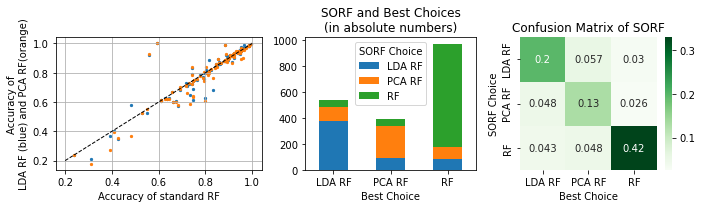

In [9]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(10,3),  gridspec_kw={'width_ratios': [1.2, 1, 1]})
ct = pd.crosstab(df_comparison["best_choice_test"], df_comparison.rename(columns={"choice": "SORF Choice"})["SORF Choice"])

permutation = [1, 2, 0]

# plot comparison of RF against LDA RF and PCA RF
df_rfcomparison = df_comparison.groupby("openmlid")["rf_test", "lda_test", "pca_test"].mean()
ax[0].scatter(df_rfcomparison["rf_test"], df_rfcomparison["lda_test"], color="C0", s=5)
ax[0].scatter(df_rfcomparison["rf_test"], df_rfcomparison["pca_test"], color="C1", s=5)
ax[0].plot([0.2,1], [0.2,1], linewidth=1, linestyle="--", color="black")
ax[0].grid()
ax[0].set_xlabel("Accuracy of standard RF")
ax[0].set_ylabel("Accuracy of\nLDA RF (blue) and PCA RF(orange)")

ct = ct.rename(columns={a: n for a, n in zip(ALGOS, ALGO_NAMES)})
ct.plot(kind='bar', stacked=True, rot=0, ax=ax[1])
ct_normalized = ct.values / np.sum(ct.values)
sns.heatmap(ct_normalized, annot=True, ax = ax[2], vmax=0.33, cmap="Greens")
for a in ax[1:]:
    a.set_xlabel("Best Choice")
ax[1].set_xticklabels([ALGO_NAMES[i] for i in permutation])
ax[1].set_title("SORF and Best Choices\n(in absolute numbers)")

ax[2].set_ylabel("SORF Choice")
ax[2].set_xticklabels([ALGO_NAMES[i] for i in permutation])
ax[2].set_yticklabels([ALGO_NAMES[i] for i in permutation])
ax[2].set_title("Confusion Matrix of SORF")
fig.tight_layout()
fig.savefig("plots/confusion.pdf", bbox_inches='tight')

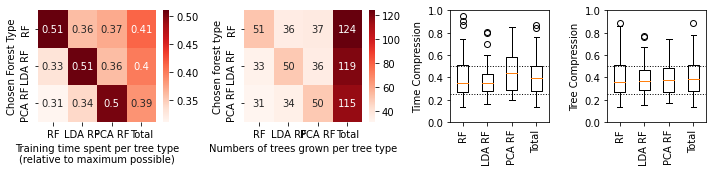

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(10, 2.5),  gridspec_kw={'width_ratios': [1.5, 1.5, 1, 1]})

Z = []
for i, a_choice in enumerate(ALGOS):
    df_selection = df_comparison[(df_comparison["choice"] == a_choice)]
    Z.append([np.mean(df_selection["traintime_" + a_tree + "_act"] / df_selection["traintime_" + a_tree + "_max"]) for a_tree in ALGOS])
Z = np.array(Z)
Z = np.column_stack([Z, np.sum(Z, axis=1) / 3])

ax = axes[0]
sns.heatmap(Z, annot=True, ax = ax, cmap="Reds")
ax.set_xticklabels(ALGO_NAMES + ["Total"])
ax.set_yticklabels(ALGO_NAMES)
ax.set_ylabel("Chosen Forest Type")
ax.set_xlabel("Training time spent per tree type\n(relative to maximum possible)")

Z = []
for i, a_choice in enumerate(ALGOS):
    df_selection = df_comparison[(df_comparison["choice"] == a_choice)]
    Z.append([int(np.round(np.mean(df_selection["trees_" + a_tree]))) for a_tree in ALGOS])
Z = np.array(Z,dtype=int)
Z = np.column_stack([Z, np.sum(Z, axis=1)])
ax = axes[1]
sns.heatmap(Z, annot=True, ax = ax, cmap="Reds", fmt='g')
ax.set_xticklabels(ALGO_NAMES + ["Total"])
ax.set_yticklabels(ALGO_NAMES)
ax.set_ylabel("Chosen forest type")
ax.set_xlabel("Numbers of trees grown per tree type")




compressions_in_time = [[np.mean(g["time_compression"]) for i, g in df_comparison[df_comparison["choice"] == a].groupby("openmlid")] for a in ALGOS] + [[np.mean(g["time_compression"]) for i, g in df_comparison.groupby("openmlid")]]
compressions_in_num_trees = [[np.mean(g["tree_compression"]) for i, g in df_comparison[df_comparison["choice"] == a].groupby("openmlid")] for a in ALGOS] + [[np.mean(g["tree_compression"]) for i, g in df_comparison.groupby("openmlid")]]

for a, values in zip(axes[2:], [compressions_in_time, compressions_in_num_trees]):
    a.boxplot(values)
    a.set_ylim([0, 1])
    a.set_xticklabels(ALGO_NAMES + ["Total"], rotation=90)
    a.axhline(0.5, linestyle="dotted", color="black", linewidth=1)
    a.axhline(0.25, linestyle="dotted", color="black", linewidth=1)
    a.axvline(4.5, color="black", linewidth=1)
axes[2].set_ylabel("Time Compression")
axes[3].set_ylabel("Tree Compression")

fig.tight_layout()
fig.savefig("plots/computations.pdf", bbox_inches='tight')
plt.show()

In [11]:
len(df_comparison.query("choice != 'rf'")) / len(df_comparison)

0.5228826933193056

/home/felix/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/felix/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


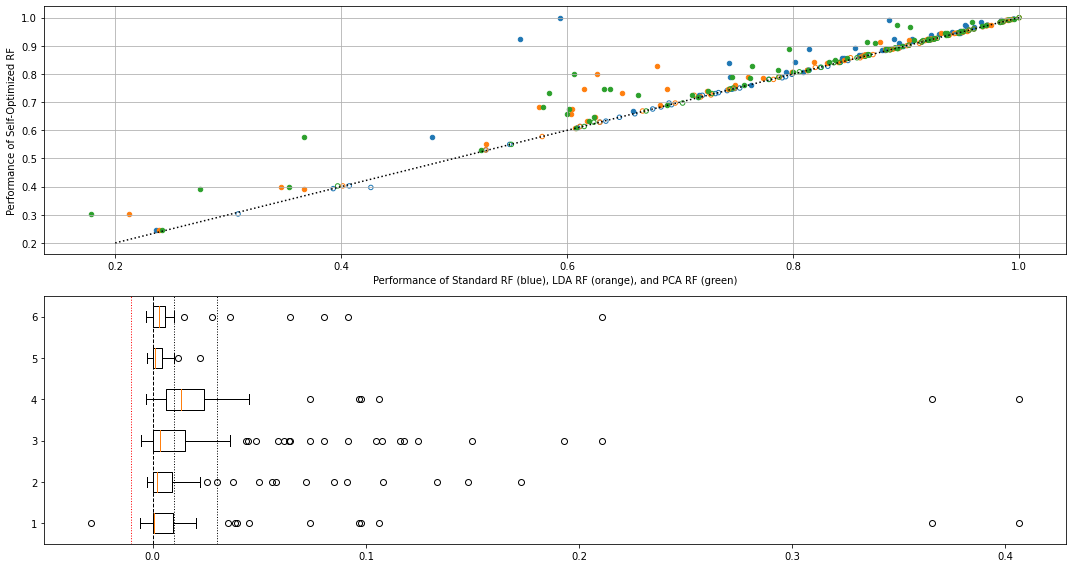

\begin{tabular}{lll}
\toprule
Empty DataFrame
Columns: Index(['openmlid', 'rf_test', 'selfopt_test'], dtype='object')
Index: Index([], dtype='object') \\
\bottomrule
\end{tabular}



In [12]:
def get_figure_and_table_for_paper(df_comparison):
    
    
    algo_names = ["rf", "lda", "pca"]
    
    scores = []
    significances = {a : [] for a in algo_names}
    
    imps = []
    
    rows = []
    for openmlid, df_dataset in df_comparison.groupby("openmlid"):
        perf_selfopt = df_dataset["selfopt_test"]
        
        data_base = []
        for comp in algo_names:
            perf_comp = df_dataset[comp + "_test"]
            data_base.append(perf_comp)
            if np.linalg.norm(perf_comp - perf_selfopt) != 0:
                significant = scipy.stats.wilcoxon(perf_comp, perf_selfopt).pvalue < 0.05
            else:
                significant = False
            significances[comp].append(significant)
        
        data_base.append(perf_selfopt)

        scores_on_dataset = [np.mean(v) for v in data_base]
        imps_on_dataset = [scores_on_dataset[-1] - v for v in scores_on_dataset]
        scores.append(scores_on_dataset)
        imps.append(imps_on_dataset)
        best_score = max(scores_on_dataset)
        best_indices = [i for i in range(len(data_base)) if scores_on_dataset[i] == best_score]
        if False:


            # format entries
            formatted_vals = [f"{np.round(100 * np.mean(v), 2)}$\pm${np.round(100 * np.std(v), 1)}" for i, v in enumerate(data_base)]
            imps.append(scores_on_dataset[1] - scores_on_dataset[0])
            for i, val in enumerate(formatted_vals):
                if i in best_indices:
                    formatted_vals[i] = "\\textbf{" + val + "}"
                elif not significant:
                    formatted_vals[i] = "\\underline{" + val + "}"

            rows.append([openmlid] + formatted_vals)
    
    scores = np.array(scores)
    imps = np.array(imps)
    
    for a in algo_names:
        significances[a] = np.array(significances[a])
    
    
    colors = {
        "rf": "C0",
        "lda": "C1",
        "pca": "C2"
    }
    
    # create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))#,  gridspec_kw={'width_ratios': [3, 1]})
    
    
    for i, a in enumerate(["rf", "lda", "pca"]):
        ax1.scatter(scores[significances[a],i], scores[significances[a],-1], s=20, color=colors[a])
        ax1.scatter(scores[~significances[a],i], scores[~significances[a],-1], s=20, facecolors="None", color=colors[a])
    
    ax1.plot([0.2,1], [0.2,1], linestyle="dotted", color="black")
    ax1.grid()
    ax1.set_xlabel("Performance of Standard RF (blue), LDA RF (orange), and PCA RF (green)")
    ax1.set_ylabel("Performance of Self-Optimized RF")
    
    imp_concated = []
    for i, algo in enumerate(algo_names):
        imp_concated.append(imps[:,i])
    for i, algo in enumerate(algo_names):
        imp_concated.append(imps[significances["rf"],i])
    
    ax2.boxplot(imp_concated, vert=False)
    ax2.axvline(-0.01, linestyle="dotted", color="red", linewidth=1)
    ax2.axvline(0, linestyle="--", color="black", linewidth=1)
    ax2.axvline(0.01, linestyle="dotted", color="black", linewidth=1)
    ax2.axvline(0.03, linestyle="dotted", color="black", linewidth=1)
    #ax2.set_yticklabels(["Improvem.", "Significant Improvem."])
    #ax2.scatter(list(range(len(imps))), imps)
    #ax2.hist(imps, bins=200)
    #ax2.set_yscale("log")
    fig.tight_layout()
    
    return (fig, ax), pd.DataFrame(rows, columns=["openmlid", "rf_test", "selfopt_test"]).to_latex(index = False, escape = False)
    
(fig, ax), df_latex = get_figure_and_table_for_paper(df_comparison)
plt.show()
print(df_latex)

/home/felix/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/felix/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


-0.001013717105263152


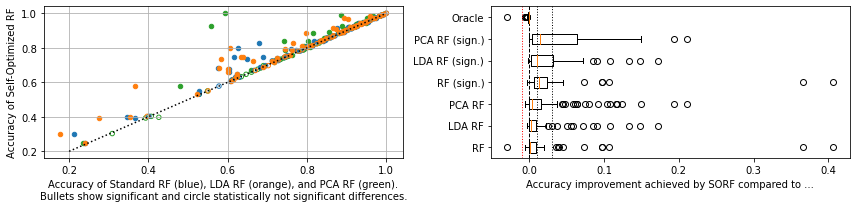

\begin{tabular}{lll}
\toprule
Empty DataFrame
Columns: Index(['openmlid', 'rf_test', 'selfopt_test'], dtype='object')
Index: Index([], dtype='object') \\
\bottomrule
\end{tabular}



In [13]:
def get_figure_and_table_for_paper(df_comparison):
    
    
    algo_names = ["rf", "lda", "pca"]
    
    scores = []
    significances = {a : [] for a in algo_names}
    
    imps = []
    
    rows = []
    for openmlid, df_dataset in df_comparison.groupby("openmlid"):
        perf_selfopt = df_dataset["selfopt_test"]
        
        data_base = []
        for comp in algo_names:
            perf_comp = df_dataset[comp + "_test"]
            data_base.append(perf_comp)
            if np.linalg.norm(perf_comp - perf_selfopt) != 0:
                significant = scipy.stats.wilcoxon(perf_comp, perf_selfopt).pvalue < 0.05
            else:
                significant = False
            significances[comp].append(significant)
        
        data_base.append(perf_selfopt)

        scores_on_dataset = [np.mean(v) for v in data_base]
        imps_on_dataset = [scores_on_dataset[-1] - v for v in scores_on_dataset]
        scores.append(scores_on_dataset)
        imps.append(imps_on_dataset)
        best_score = max(scores_on_dataset)
        best_indices = [i for i in range(len(data_base)) if scores_on_dataset[i] == best_score]
        if False:


            # format entries
            formatted_vals = [f"{np.round(100 * np.mean(v), 2)}$\pm${np.round(100 * np.std(v), 1)}" for i, v in enumerate(data_base)]
            imps.append(scores_on_dataset[1] - scores_on_dataset[0])
            for i, val in enumerate(formatted_vals):
                if i in best_indices:
                    formatted_vals[i] = "\\textbf{" + val + "}"
                elif not significant:
                    formatted_vals[i] = "\\underline{" + val + "}"

            rows.append([openmlid] + formatted_vals)
    
    scores = np.array(scores)
    imps = np.array(imps)
    
    for a in algo_names:
        significances[a] = np.array(significances[a])
    
    
    colors = {
        "rf": "C2",
        "lda": "C0",
        "pca": "C1"
    }
    
    
    
    # create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3),  gridspec_kw={'width_ratios': [1, 1]})
    
    
    for i, a in enumerate(["rf", "lda", "pca"]):
        ax1.scatter(scores[significances[a],i], scores[significances[a],-1], s=20, color=colors[a])
        ax1.scatter(scores[~significances[a],i], scores[~significances[a],-1], s=20, facecolors="None", color=colors[a])
    
    ax1.plot([0.2,1], [0.2,1], linestyle="dotted", color="black")
    ax1.grid()
    ax1.set_xlabel("Accuracy of Standard RF (blue), LDA RF (orange), and PCA RF (green).\nBullets show significant and circle statistically not significant differences.")
    ax1.set_ylabel("Accuracy of Self-Optimized RF")
    
    imp_concated = []
    for i, algo in enumerate(algo_names):
        imp_concated.append(imps[:,i])
    for i, algo in enumerate(algo_names):
        imp_concated.append(imps[significances[algo],i])
    
    imp_concated.append(np.min(imps, axis=1))
    
    ax2.boxplot(imp_concated, vert=False)
    ax2.axvline(-0.01, linestyle="dotted", color="red", linewidth=1)
    ax2.axvline(0, linestyle="--", color="black", linewidth=1)
    ax2.axvline(0.01, linestyle="dotted", color="black", linewidth=1)
    ax2.axvline(0.03, linestyle="dotted", color="black", linewidth=1)
    ax2.set_xlabel("Accuracy improvement achieved by SORF compared to ...")
    ax2.set_yticklabels(ALGO_NAMES + [name + " (sign.)" for name in ALGO_NAMES] + ["Oracle"])
    #ax2.scatter(list(range(len(imps))), imps)
    #ax2.hist(imps, bins=200)
    #ax2.set_yscale("log")
    fig.tight_layout()
    
    print(np.mean(imp_concated[-1]))
    
    return (fig, ax), pd.DataFrame(rows, columns=["openmlid", "rf_test", "selfopt_test"]).to_latex(index = False, escape = False)
    
(fig, ax), df_latex = get_figure_and_table_for_paper(df_comparison)
fig.savefig("plots/performance.pdf", bbox_inches='tight')
plt.show()
print(df_latex)

In [14]:
imps

NameError: name 'imps' is not defined

In [ ]:
def get_figure_and_table_for_paper(df_comparison):
    
    
    algo_names = ["rf", "lda", "pca"]
    
    scores = []
    significances = {a : [] for a in algo_names}
    
    imps = []
    
    rows = []
    for openmlid, df_dataset in df_comparison.groupby("openmlid"):
        perf_selfopt = df_dataset["selfopt_test"]
        
        data_base = []
        for comp in algo_names:
            perf_comp = df_dataset[comp + "_test"]
            data_base.append(perf_comp)
            if np.linalg.norm(perf_comp - perf_selfopt) != 0:
                significant = scipy.stats.wilcoxon(perf_comp, perf_selfopt).pvalue < 0.05
            else:
                significant = False
            significances[comp].append(significant)
        
        data_base.append(perf_selfopt)

        scores_on_dataset = [np.mean(v) for v in data_base]
        imps_on_dataset = [scores_on_dataset[-1] - v for v in scores_on_dataset]
        scores.append(scores_on_dataset)
        imps.append(imps_on_dataset)
        best_score = max(scores_on_dataset)
        best_indices = [i for i in range(len(data_base)) if scores_on_dataset[i] == best_score]
        if False:


            # format entries
            formatted_vals = [f"{np.round(100 * np.mean(v), 2)}$\pm${np.round(100 * np.std(v), 1)}" for i, v in enumerate(data_base)]
            imps.append(scores_on_dataset[1] - scores_on_dataset[0])
            for i, val in enumerate(formatted_vals):
                if i in best_indices:
                    formatted_vals[i] = "\\textbf{" + val + "}"
                elif not significant:
                    formatted_vals[i] = "\\underline{" + val + "}"

            rows.append([openmlid] + formatted_vals)
    
    scores = np.array(scores)
    imps = np.array(imps)
    
    for a in algo_names:
        significances[a] = np.array(significances[a])
    
    
    colors = {
        "rf": "C0",
        "lda": "C1",
        "pca": "C2"
    }
    
    # create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))#,  gridspec_kw={'width_ratios': [3, 1]})
    
    
    for i, a in enumerate(["rf", "lda", "pca"]):
        ax1.scatter(scores[significances[a],i], scores[significances[a],-1], s=20, color=colors[a])
        ax1.scatter(scores[~significances[a],i], scores[~significances[a],-1], s=20, facecolors="None", color=colors[a])
    
    ax1.plot([0.2,1], [0.2,1], linestyle="dotted", color="black")
    ax1.grid()
    ax1.set_xlabel("Performance of Standard RF (blue), LDA RF (orange), and PCA RF (green)")
    ax1.set_ylabel("Performance of Self-Optimized RF")
    
    imp_concated = []
    for i, algo in enumerate(algo_names):
        imp_concated.append(imps[:,i])
    for i, algo in enumerate(algo_names):
        imp_concated.append(imps[significances["rf"],i])
    
    ax2.boxplot(imp_concated, vert=False)
    ax2.axvline(-0.01, linestyle="dotted", color="red", linewidth=1)
    ax2.axvline(0, linestyle="--", color="black", linewidth=1)
    ax2.axvline(0.01, linestyle="dotted", color="black", linewidth=1)
    ax2.axvline(0.03, linestyle="dotted", color="black", linewidth=1)
    #ax2.set_yticklabels(["Improvem.", "Significant Improvem."])
    #ax2.scatter(list(range(len(imps))), imps)
    #ax2.hist(imps, bins=200)
    #ax2.set_yscale("log")
    fig.tight_layout()
    
    return (fig, ax), pd.DataFrame(rows, columns=["openmlid", "rf_test", "selfopt_test"]).to_latex(index = False, escape = False)
    
(fig, ax), df_latex = get_figure_and_table_for_paper(df_comparison)
plt.show()
print(df_latex)

In [ ]:
100* np.round(df_comparison[["openmlid", "rf_test", "selfopt_test"]].groupby("openmlid").mean(), 4)

In [ ]:
print(len(gaps))
fig, ax = plt.subplots(1,2)
ax[0].boxplot(gaps)
ax[1].boxplot(improvements_over_rf)
plt.show()

fig, ax = plt.subplots(1,2)
ax[0].hist(choices)
ax[1].hist(best_choices)

In [ ]:
for openmlid in sorted(pd.unique(bm.cache["openmlid"])):
    fig, ax = plt.subplots()
    sizes = list(range(1,201))
    max_val = 0
    for i, algo in enumerate(["rf", "lda", "pca"]):
        for test, linestyle in zip([True, False], ["solid", "--"]):
            curves = []
            for seed in range(1):
                curve = bm.get_curve(openmlid, algo, seed, oob = not test)
                curves.append(list(curve[1]))
            if not curves:
                continue
            curves = np.array(curves)
            means = np.mean(curves, axis=0)
            q3 = np.percentile(curves, 25, axis=0)
            q7 = np.percentile(curves, 75, axis=0)
            max_val = max(max_val, max(means))
            ax.plot(sizes, means, color=f"C{i}", linestyle=linestyle)
            ax.fill_between(sizes, q3, q7, color=f"C{i}", alpha=0.2)
    #ax.set_ylim([max_val - 0.1, max_val + 0.01])
    ax.set_title(openmlid)
    plt.show()